In [2]:
from __future__ import print_function, division

%matplotlib inline
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator

from matplotlib import pyplot as plt
import seaborn as sns; sns.set(context="poster", style="ticks")
import ipywidgets
import yt

import glob
import os
import warnings
import h5py

import numpy as np
import pandas as pd
import numba

import pickle

from units import M_solar, m_proton, pc, yr, Myr, km, s, gamma

from injection_helpers import get_SNe

from visualize_helpers import \
    get_snapshot_filenames, \
    snapshot_filename_to_number, \
    total_mass_of_snapshot, \
    total_radial_momentum_of_snapshot, \
    map_to_all_snapshots, \
    get_snapshot_times, \
    total_kinetic_energy_of_snapshot, \
    total_internal_energy_of_snapshot, \
    load_snapshots, \
    plot_projected_density, \
    plot_sliced_field, \
    plot_phase_diagram, \
    field_type, \
    plot_profile, \
    yt_plot_saver, \
    mpl_plot_saver, \
    load_ds_from_ts, \
    get_dirs, \
    get_pickle_filename_profile, \
    save_phase_diagram_data_3D, \
    save_phase_diagram_data_1D, \
    is_weight_field_processed, \
    get_closest_1D_snapshot, \
    rbf, \
    RunSummary

import MHD
    
from sql_helpers import add_simulation, \
    open_as_DataFrame, get_db_dirname_tmp

%load_ext autoreload
%autoreload 2

/pfs/home/egentry/anaconda3/envs/sph/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


`grackle_helpers.wrapped_initializer` is setting up grackle assuming code units:
    mass   : 1.0 M_solar
    length : 1.0 pc
    time   : 1.0 Myr

grackle cooling file:  b'/pfs/home/egentry/local/grackle/input/CloudyData_UVB=HM2012.h5'
`grackle_helpers.wrapped_initializer` is setting up grackle assuming code units:
    mass   : 8.41e-58 M_solar
    length : 3.24e-19 pc
    time   : 3.17e-14 Myr

grackle cooling file:  b'/pfs/home/egentry/local/grackle/input/CloudyData_UVB=HM2012.h5'


In [3]:
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['figure.facecolor'] = "white"

In [4]:
publication_plots_dir = "publication_plots"
pickle_save_dir = os.path.join(publication_plots_dir, "data")

In [5]:
save_plots = False

In [6]:
inputs_dir_tmp = "../runs/cluster_cooling_200/inputs/"
SNe = get_SNe(inputs_dir_tmp)
SN_times           = np.array([SN.time          for SN in SNe])
SN_ejecta_masses   = np.array([SN.ejecta_mass   for SN in SNe])
SN_ejecta_masses_Z = np.array([SN.ejecta_mass_Z for SN in SNe])

In [7]:
data_dir_1D = "1D_data/"

run_summary = RunSummary(data_dir_1D, "F5509BF1-3F9E-4008-B795-0482ECED199B")

# Momentum Evolution Figures (1, 2, 5)

In [20]:
db_dir_tmp = get_db_dirname_tmp()
if not os.path.exists(db_dir_tmp):
    print("making temporary database directory: ", db_dir_tmp)
    os.mkdir(db_dir_tmp)


making temporary database directory:  /dev/shm/egentry


In [21]:
def copy_and_get_DataFrames(run_name):
    df = open_as_DataFrame(run_name, copy_first=True)
    
    return df


In [22]:
run_names = [
    "cluster_cooling_600",
    "cluster_cooling_400",
    "cluster_cooling_300",
    "cluster_cooling_200",
    "cluster_cooling_100",
    "cluster_cooling_mhd_large_200",
]
dfs = {run_name : copy_and_get_DataFrames(run_name) 
       for run_name in run_names}

In [23]:
run_name_to_dx = {
    "cluster_cooling_600" : 4/6,
    "cluster_cooling_400" : 1,
    "cluster_cooling_300" : 4/3,
    "cluster_cooling_200" : 2,
    "cluster_cooling_100" : 4,
    "cluster_cooling_mhd_large_200" : 2,
}

In [24]:
class Dx_To_Color(object):
    def __init__(self, 
                 min_dx=min(run_name_to_dx.values())/1.05, 
                 max_dx=max(run_name_to_dx.values())*1.05,
                 colormap_name="viridis",
                ):
        self.min_dx = min_dx
        self.max_dx = max_dx
        
        self.cm = plt.get_cmap(colormap_name)

        
    def __call__(self, dx, verbose=False, invert=False):
        if verbose:
            print("min_dx: ", self.min_dx)
            print("max_dx: ", self.max_dx)

        # log space the colorscale
        x =    (np.log(dx)          - np.log(self.min_dx)) \
             / (np.log(self.max_dx) - np.log(self.min_dx))
        if verbose:
            print("x:     ", x)

        if invert:
            x = 1-x
        

        color = self.cm( x )

        return color

dx_to_color = Dx_To_Color()

In [25]:
dfs["cluster_cooling_400"].head()

number      time         e_kin         e_int  e_mag          mass  \
0       0  0.000000  0.000000e+00  4.939728e+50    0.0  7.097382e+06   
1       1  0.001000  0.000000e+00  1.493973e+51    0.0  7.097388e+06   
2       2  0.127017  1.627410e+50  5.243963e+50    0.0  7.097388e+06   
3       3  0.253034  8.984177e+49  5.014070e+50    0.0  7.097388e+06   
4       4  0.379051  6.745136e+49  4.972623e+50    0.0  7.097388e+06   

       momentum             run_name  
0  0.000000e+00  cluster_cooling_400  
1  0.000000e+00  cluster_cooling_400  
2  4.606760e+43  cluster_cooling_400  
3  4.710492e+43  cluster_cooling_400  
4  4.751914e+43  cluster_cooling_400

In [12]:
def resolution_study_plotter(run_names, 
                             dfs=dfs, run_summary=run_summary,
                             with_1D=True,
                             with_MHD=True,
                             with_rugplot=True,
                             with_log_yscale=True,
                             ):
    
    if with_1D:
        plt.plot((run_summary.times - run_summary.overview.SNe_times[0]) / (Myr),
                 run_summary.momentum / (100 * M_solar * 11 * km / s),
                 label="1D",
                 linestyle="dotted", color="k",
                 )

    for run_name in run_names:
        if "mhd" in run_name.lower():
            continue

        dx = run_name_to_dx[run_name]

        plt.plot(dfs[run_name].time,
                 dfs[run_name].momentum / (100 * M_solar * len(SNe) * km / s),
                 label="3D: $\Delta x = $ {:.1f} pc".format(dx),
                 color=dx_to_color(dx),
                 )

    if with_MHD:
        run_name = "cluster_cooling_mhd_large_200"
        dx = run_name_to_dx[run_name]

        plt.plot(dfs[run_name].time,
                 dfs[run_name].momentum / (100 * M_solar * len(SNe) * km / s),
                 label="3D MHD: $\Delta x = $ {:.1f} pc".format(dx),
                 linestyle="dashed", 
                 color=dx_to_color(dx),
                )

    if with_rugplot:
        sns.rugplot(SN_times, color="k", linewidth=3)

    plt.xlabel(r"$t$ $[\mathrm{Myr}]$")
    plt.ylabel(r"$p / (100$ $M_\odot$ $N_\mathrm{SNe})$ $[\mathrm{km}$ $\mathrm{s}^{-1}]$")


    plt.xlim(xmin=-1,
             xmax=40)
    plt.ylim(ymin=300,
             ymax=3000,
            )

    if with_log_yscale:
        plt.yscale("log")

    plt.legend(loc="best")
    

### Example

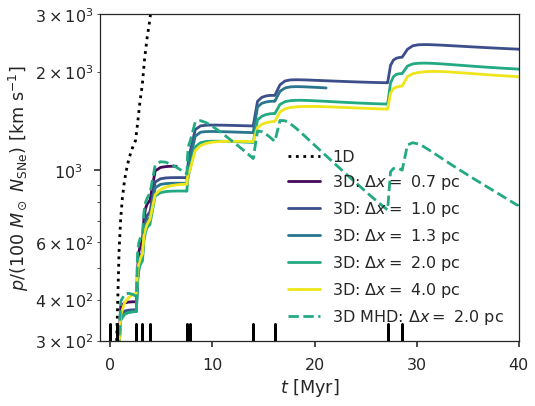

In [13]:
mpl.rcParams['figure.figsize'] = np.array((5,4))*1.5

resolution_study_plotter(run_names)

In [14]:
isolated_SN_momentum = dfs["cluster_cooling_200"].loc[6].momentum / (100 * M_solar * km/s)
isolated_SN_momentum

2351.4539337061497

## Momentum - Figure 1 - 1D vs 3D

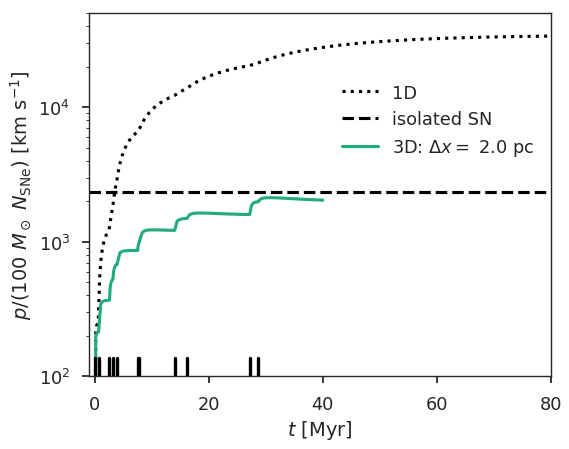

In [19]:
mpl.rcParams['figure.figsize'] = np.array((5,4))*1.5

resolution_study_plotter(["cluster_cooling_200"],
                         with_MHD=False,
                        )

plt.axhline(isolated_SN_momentum, linestyle="dashed", color="black", label="isolated SN")

handles, labels = plt.gca().get_legend_handles_labels()
new_legend_order = [0,2,1]
plt.legend([handles[i] for i in new_legend_order], 
           [labels[i] for i in new_legend_order],
           loc="upper right", bbox_to_anchor=(1, 0.85))

plt.xlim(xmax=80)
plt.ylim(100,50000)

plt.tight_layout()
plot_filename = os.path.join(publication_plots_dir, "momentum_evolution-1D_vs_3D")
plt.savefig(plot_filename + ".eps")
plt.savefig(plot_filename + ".pdf")
plt.savefig(plot_filename + ".png")

## Momentum - Figure 2 - 3D resolution study

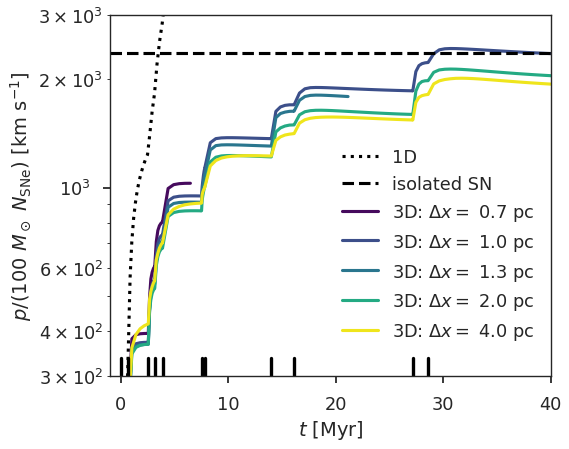

In [20]:
mpl.rcParams['figure.figsize'] = np.array((5,4))*1.5

resolution_study_plotter([
                          "cluster_cooling_600",
                          "cluster_cooling_400",
                          "cluster_cooling_300",
                          "cluster_cooling_200",
                          "cluster_cooling_100",
                          ],
                         with_MHD=False,
                        )

plt.axhline(isolated_SN_momentum, linestyle="dashed", color="black", label="isolated SN")

handles, labels = plt.gca().get_legend_handles_labels()
new_legend_order = [0, -1] + list(range(1, len(labels)-1))
plt.legend([handles[i] for i in new_legend_order], 
           [labels[i] for i in new_legend_order],
           loc="lower right", 
           bbox_to_anchor=(1, 0.05),
          )

plt.tight_layout()
plot_filename = os.path.join(publication_plots_dir, "momentum_evolution-3D_resolution-HD")
plt.savefig(plot_filename + ".eps")
plt.savefig(plot_filename + ".pdf")
plt.savefig(plot_filename + ".png")

## Momentum - Figure 6 - with MHD

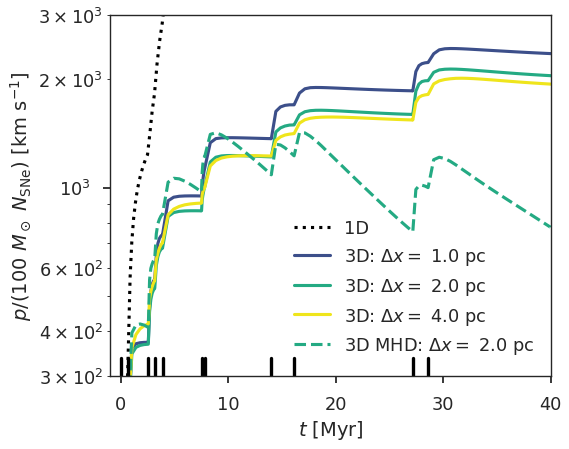

In [21]:
mpl.rcParams['figure.figsize'] = np.array((5,4))*1.5

resolution_study_plotter([
#                           "cluster_cooling_600",
                          "cluster_cooling_400",
#                           "cluster_cooling_300",
                          "cluster_cooling_200",
                          "cluster_cooling_100",
                          "cluster_cooling_mhd_large_200",
                          ],
                         with_MHD=True)

plt.legend(loc="upper right", bbox_to_anchor=(1,.48))

plt.tight_layout()
plot_filename = os.path.join(publication_plots_dir, "momentum_evolution-3D_resolution-MHD")
plt.savefig(plot_filename + ".eps")
plt.savefig(plot_filename + ".pdf")
plt.savefig(plot_filename + ".png")

## Momentum - Figure 5 - with MHD + ratchet filter

In [22]:
def ratchet_filter(data):
    derivatives = np.append(0, np.diff(data))
    mask = derivatives < 0
    derivatives[mask] = 0
    
    return derivatives.cumsum()

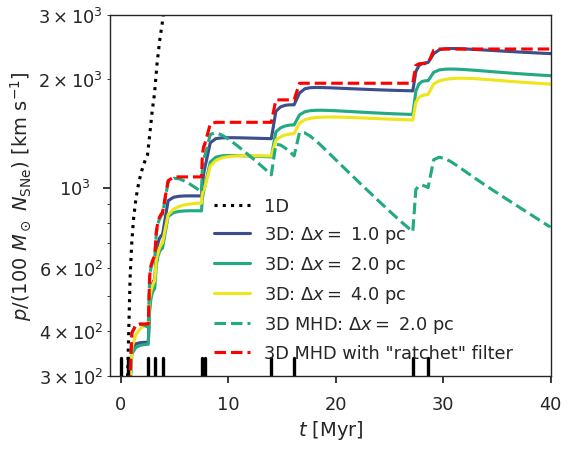

In [23]:
mpl.rcParams['figure.figsize'] = np.array((5,4))*1.5

resolution_study_plotter([
#                           "cluster_cooling_600",
                          "cluster_cooling_400",
#                           "cluster_cooling_300",
                          "cluster_cooling_200",
                          "cluster_cooling_100",
                          "cluster_cooling_mhd_large_200",
                          ],
                         with_MHD=True)

df = dfs["cluster_cooling_mhd_large_200"]
plt.plot(df.time,
         ratchet_filter(df.momentum) / (100 * M_solar * len(SNe) * km / s),
         label="3D MHD with \"ratchet\" filter",
         linestyle="dashed", 
         color="red",
        )
    
plt.legend(loc="upper left", 
           bbox_to_anchor=(.20, .54))


plt.tight_layout()
plot_filename = os.path.join(publication_plots_dir, "momentum_evolution-3D_resolution-MHD-ratchet")
plt.savefig(plot_filename + ".eps")
plt.savefig(plot_filename + ".pdf")
plt.savefig(plot_filename + ".png")

# Figure 3 -- momentum vs resolution
This doesn't add any new information from the plots above -- it simply makes it easier to see the trend.

In [26]:
time_for_resolution_comparison = dfs["cluster_cooling_600"].time.max()
time_for_resolution_comparison

6.461011094091502

In [28]:
momentum_by_res = dict()

for run_name in run_names:
    df = dfs[run_name]
    closest_snapshot = np.argmin(np.abs(df.time - time_for_resolution_comparison))
    if "mhd" in run_name:
        print("MHD: ", df.momentum[closest_snapshot] / (100 * M_solar * km / s * 11))    
        continue
    momentum_by_res[run_name_to_dx[run_name]] = df.momentum[closest_snapshot]


MHD:  1020.3166420481449


/pfs/home/egentry/anaconda3/envs/sph/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


In [31]:
for key in momentum_by_res:
    print("{} : {}".format(key, momentum_by_res[key] / (100 * M_solar * km / s * 11)))
    

0.6666666666666666 : 1027.4752858071788
1 : 948.2032541924959
1.3333333333333333 : 911.1781313295454
2 : 862.3325090088317
4 : 900.720875367674


In [32]:
import sklearn
import sklearn.linear_model

In [34]:
linfit = sklearn.linear_model.LinearRegression()
x = np.log(np.array(list(momentum_by_res.keys())))
y = np.log(np.array(list(momentum_by_res.values())) / (100 * M_solar * km / s * 11))


mask = (x <= np.log(2))
x = x[mask]
y = y[mask]

x = x.reshape(-1, 1)

linfit.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [36]:
linfit.coef_

array([-0.15814115])

/pfs/home/egentry/anaconda3/envs/sph/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


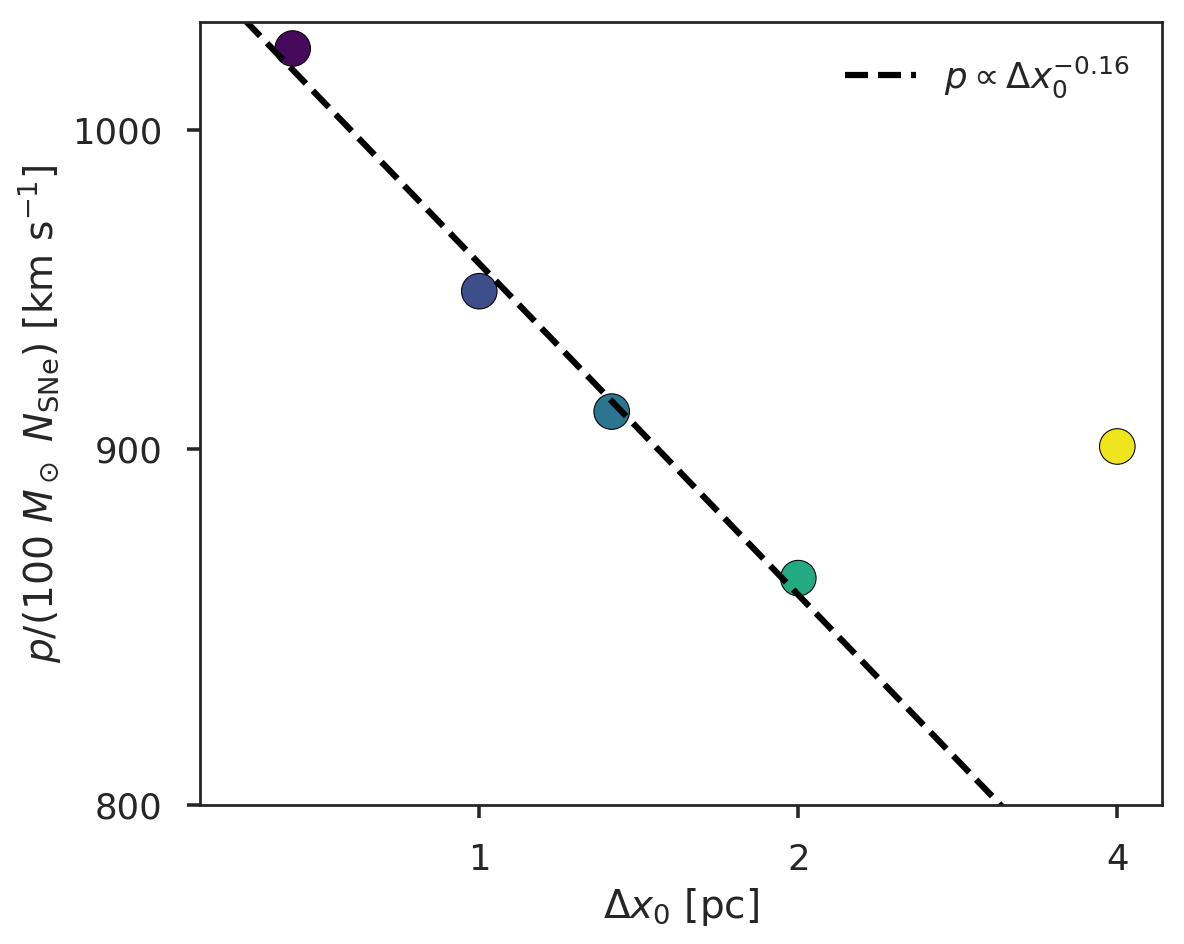

In [48]:
# plot: the color image

with mpl.rc_context(rc={"figure.dpi":160, "savefig.dpi":160,
                        'figure.figsize': np.array((5,4))*1.5}):

    plt.scatter(np.array(list(momentum_by_res.keys())),
                np.array(list(momentum_by_res.values())) / (100 * M_solar * km / s * 11),
                c=[dx_to_color(dx) for dx in momentum_by_res],
                edgecolors="black",
                s=256,
               )

    plt.xscale("log")
    plt.yscale("log")


    plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
    plt.gca().xaxis.set_minor_formatter(plt.NullFormatter())
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().xaxis.set_minor_locator(plt.NullLocator())

    plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
    plt.gca().yaxis.set_minor_formatter(plt.NullFormatter())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_minor_locator(plt.NullLocator())

    ax = plt.gca()

    x_tick_locs = [.5, 1, 2, 4]
    plt.xticks(x_tick_locs, [str(x_tick_loc) for x_tick_loc in x_tick_locs])

    y_tick_locs = [800, 900, 1000]
    plt.yticks(y_tick_locs, [str(y_tick_loc) for y_tick_loc in y_tick_locs])

    plt.xlabel(r"$\Delta x_0$ [pc]")
    plt.ylabel(r"$p / (100$ $M_\odot$ $N_\mathrm{SNe})$ $[\mathrm{km}$ $\mathrm{s}^{-1}]$")

    plt.ylim(
        ymin=8e2,
    #     ymax=1.5e3,
    )

    x_best_fit = np.logspace(np.log10(.6), np.log10(4)).reshape(-1, 1)
    y_best_fit = np.exp(linfit.predict(np.log(x_best_fit)))
    plt.plot(x_best_fit, y_best_fit, 
             label=r"$p \propto \Delta x_0^{{{:.2f}}}$".format(linfit.coef_[0]),
             linestyle="dashed",
             color="black"
            )

    plt.legend(loc="best")

    # plt.title("t = {:.2f} Myr".format(time_for_resolution_comparison))

    plt.tight_layout()
    plot_filename = os.path.join(publication_plots_dir, "momentum_vs_resolution")
    plt.savefig(plot_filename + ".eps")
    plt.savefig(plot_filename + ".pdf")
    plt.savefig(plot_filename + ".png")

In [83]:
import ipywidgets


@ipywidgets.interact(plotted_time = ipywidgets.FloatSlider(min=0.01, max=10, step=0.25),
                           )
def plot_resolution_study_at_time(plotted_time):
    momentum_by_res_early = dict()
    for run_name in run_names:
        if "mhd" in run_name:
            continue

        df = dfs[run_name]
        closest_snapshot = np.argmin(np.abs(df.time - plotted_time))
        if np.abs(df.time[closest_snapshot] - plotted_time) > 0.6:
            continue # closest snapshot too far away - simulation probably ended early
        momentum_by_res[run_name_to_dx[run_name]] = df.momentum[closest_snapshot]
        momentum_by_res_early[run_name_to_dx[run_name]] = df.momentum[closest_snapshot]

    plt.scatter(np.array(list(momentum_by_res_early.keys())),
                np.array(list(momentum_by_res_early.values())) / (100 * M_solar * km / s * 11),
                c=[dx_to_color(dx) for dx in momentum_by_res_early]
               )

    plt.xscale("log")
    plt.yscale("log")


    plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
    plt.gca().xaxis.set_minor_formatter(plt.NullFormatter())
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().xaxis.set_minor_locator(plt.NullLocator())

    # plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
    # plt.gca().yaxis.set_minor_formatter(plt.NullFormatter())
    # plt.gca().yaxis.set_major_locator(plt.NullLocator())
    # plt.gca().yaxis.set_minor_locator(plt.NullLocator())

    ax = plt.gca()

    x_tick_locs = [.5, 1, 2, 4]
    plt.xticks(x_tick_locs, [str(x_tick_loc) for x_tick_loc in x_tick_locs])

#     y_tick_locs = [210, 220, 230]
#     plt.yticks(y_tick_locs, [str(y_tick_loc) for y_tick_loc in y_tick_locs])

    plt.xlabel(r"$\Delta x$ [pc]")
    plt.ylabel(r"$p / (100$ $M_\odot$ $N_\mathrm{SNe})$ $[\mathrm{km}$ $\mathrm{s}^{-1}]$")

    plt.ylim(
#         ymin=3e2,
#         ymax=5e2,
    )
    
    SNe_so_far = (SN_times < plotted_time).sum()
    plt.title("SN{} so far: {}".format(
        "e" if SNe_so_far>1 else "",
        SNe_so_far))

    # plt.title("t = {:.2f} Myr".format(time_for_resolution_comparison))

    # plt.tight_layout()
    # plot_filename = os.path.join(publication_plots_dir, "momentum_vs_resolution")
    # plt.savefig(plot_filename + ".eps")
    # plt.savefig(plot_filename + ".pdf")
    # plt.savefig(plot_filename + ".png")


interactive(children=(FloatSlider(value=0.01, description='plotted_time', max=10.0, min=0.01, step=0.25), Output()), _dom_classes=('widget-interact',))

In [88]:
import ipywidgets


@ipywidgets.interact(snapshot_num = ipywidgets.IntSlider(min=0, max=20, step=1),
                           )
def plot_resolution_study_at_snapshot(snapshot_num):
    momentum_by_res_early = dict()
    for run_name in run_names:
        if "mhd" in run_name:
            continue

        df = dfs[run_name]
#         closest_snapshot = np.argmin(np.abs(df.time - plotted_time))
#         if np.abs(df.time[closest_snapshot] - plotted_time) > 0.6:
#             continue # closest snapshot too far away - simulation probably ended early
        try:
            momentum_by_res_early[run_name_to_dx[run_name]] = df.momentum[snapshot_num]
            plotted_time = df.time[snapshot_num]
        except:
            pass

    plt.scatter(np.array(list(momentum_by_res_early.keys())),
                np.array(list(momentum_by_res_early.values())) / (100 * M_solar * km / s * 11),
                c=[dx_to_color(dx) for dx in momentum_by_res_early]
               )

    plt.xscale("log")
    plt.yscale("log")


    plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
    plt.gca().xaxis.set_minor_formatter(plt.NullFormatter())
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().xaxis.set_minor_locator(plt.NullLocator())

    # plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
    # plt.gca().yaxis.set_minor_formatter(plt.NullFormatter())
    # plt.gca().yaxis.set_major_locator(plt.NullLocator())
    # plt.gca().yaxis.set_minor_locator(plt.NullLocator())

    ax = plt.gca()

    x_tick_locs = [.5, 1, 2, 4]
    plt.xticks(x_tick_locs, [str(x_tick_loc) for x_tick_loc in x_tick_locs])

#     y_tick_locs = [210, 220, 230]
#     plt.yticks(y_tick_locs, [str(y_tick_loc) for y_tick_loc in y_tick_locs])

    plt.xlabel(r"$\Delta x$ [pc]")
    plt.ylabel(r"$p / (100$ $M_\odot$ $N_\mathrm{SNe})$ $[\mathrm{km}$ $\mathrm{s}^{-1}]$")

    plt.ylim(
#         ymin=3e2,
#         ymax=5e2,
    )
    
    SNe_so_far = (SN_times < plotted_time).sum()
    plt.title("SN{} so far: {} (t={:.2f})".format(
        "e" if SNe_so_far>1 else "",
        SNe_so_far,
        plotted_time))

    # plt.title("t = {:.2f} Myr".format(time_for_resolution_comparison))

    # plt.tight_layout()
    # plot_filename = os.path.join(publication_plots_dir, "momentum_vs_resolution")
    # plt.savefig(plot_filename + ".eps")
    # plt.savefig(plot_filename + ".pdf")
    # plt.savefig(plot_filename + ".png")


interactive(children=(IntSlider(value=0, description='snapshot_num', max=20), Output()), _dom_classes=('widget-interact',))

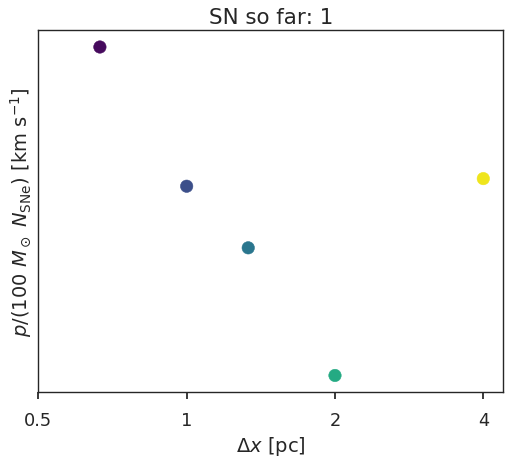

In [87]:
plot_resolution_study_at_time(0.5)

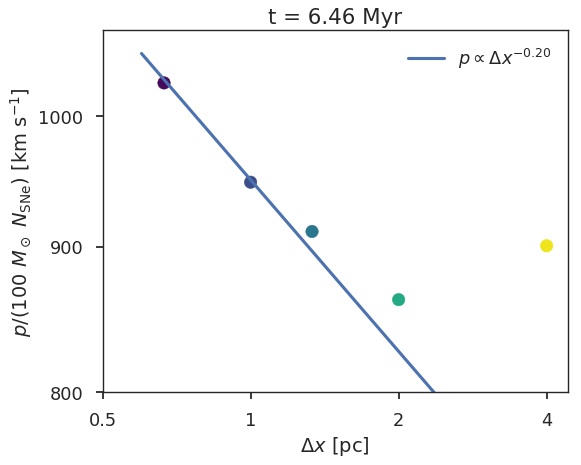

In [31]:
plt.scatter(np.array(list(momentum_by_res.keys())),
            np.array(list(momentum_by_res.values())) / (100 * M_solar * km / s * 11),
            c=[dx_to_color(dx) for dx in momentum_by_res]
           )

plt.xscale("log")
plt.yscale("log")

xs = np.logspace(np.log10(.6), np.log10(4))
slope = -0.2
ys = 9.5e2 * xs**(slope)
plt.plot(xs, ys, label="$p \propto \Delta x^{{{:.2f}}}$".format(slope))

plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
plt.gca().xaxis.set_minor_formatter(plt.NullFormatter())
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().xaxis.set_minor_locator(plt.NullLocator())

plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
plt.gca().yaxis.set_minor_formatter(plt.NullFormatter())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_minor_locator(plt.NullLocator())

ax = plt.gca()

x_tick_locs = [.5, 1, 2, 4]
plt.xticks(x_tick_locs, [str(x_tick_loc) for x_tick_loc in x_tick_locs])

y_tick_locs = [800, 900, 1000]
plt.yticks(y_tick_locs, [str(y_tick_loc) for y_tick_loc in y_tick_locs])

plt.xlabel(r"$\Delta x$ [pc]")
plt.ylabel(r"$p / (100$ $M_\odot$ $N_\mathrm{SNe})$ $[\mathrm{km}$ $\mathrm{s}^{-1}]$")

plt.ylim(
    ymin=8e2,
#     ymax=1.5e3,
)

plt.title("t = {:.2f} Myr".format(time_for_resolution_comparison))

plt.legend(loc="best")



In [115]:
momentum_by_res

{0.6666666666666666: 2.2474202802646187e+44,
 1: 2.074026745675943e+44,
 1.3333333333333333: 1.9930408444568066e+44,
 2: 1.8861996934120124e+44,
 4: 1.9701674484255193e+44}

# Figure 4 - HD Slice

**Note:** these slice plots use a currently-beta version of `yt` to do a better job with plotting particle based data.

For background motivation/information: https://www.youtube.com/watch?v=pkZgQIGac6I

For installation instructions:
 - [a link to what I used, but which might change](https://nbviewer.jupyter.org/url/trident-project.org/agora/yt_Trident_AGORA_Tutorial.ipynb#Installing-the-beta-%22demeshened%22-version-of-yt)
 - [a permalink that _might_ be the same as what I used](https://gist.github.com/chummels/4f1092ce810a0fe97243f47bed029b41/ed2e06e76703112b6b2f6425c15e8c151791af50). It seems to be struggling in [nbviewer](nbviewer.jupyter.org), so you might need to download it and open it on your own machine. ¯\\\_(ツ)_/¯
 
In the event of any breaking changes to Nathan's `sph-viz` branch, I have a `yt` fork frozen at the version that I used to make these plots. To use it, follow the instructions above, but with instead of using `ngoldbaum/yt`, use `egentry/yt`.

Hopefully the "demeshened" branch of `yt` will be released soon, and these plots should just automatically look nice.

In [6]:
run_name = "cluster_cooling_200-small_steps"
inputs_dir, outputs_dir = get_dirs(run_name)

In [7]:
ts = load_snapshots(outputs_dir)
snapshot_filenames = get_snapshot_filenames(outputs_dir)

snapshot_number_to_index_map = {snapshot_filename_to_number(filename) : i
                                for i,filename in enumerate(snapshot_filenames) }

uncompressed_snapshot_numbers = sorted(list(snapshot_number_to_index_map.keys()))


In [14]:
snapshot_number = 39
ds = load_ds_from_ts(ts, snapshot_number_to_index_map[snapshot_number])
center = ds.domain_center.value[0]

radius = 150
radius *= 1.1 * np.sqrt(3) # to get the corners + provide enough margin
region = ds.sphere([center,center,center], (radius, "pc"))

coords = region["all", "Coordinates"].value - center
x, y, z = coords.T
scales = region["all", "smoothing_length"].value
temps = region["all", "temperature"].value
densities = region["all", "density"].value / m_proton

from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=32, n_jobs=4)
knn = knn.fit(coords)

yt : [INFO     ] 2018-10-01 20:15:59,739 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2018-10-01 20:15:59,777 Parameters: current_time              = 7.529999999973149
yt : [INFO     ] 2018-10-01 20:15:59,778 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2018-10-01 20:15:59,780 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2018-10-01 20:15:59,782 Parameters: domain_right_edge         = [600. 600. 600.]
yt : [INFO     ] 2018-10-01 20:15:59,784 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2018-10-01 20:16:01,019 Allocating for 2.700e+07 particles
Initializing refined index: 100%|██████████| 103/103 [00:05<00:00, 17.88it/s]


In [15]:
y_out = np.linspace(-150, 150, num=800)
z_out = np.linspace(-150, 150, num=800)

YY, ZZ = np.meshgrid(y_out, z_out, indexing="xy")
XX = np.full_like(YY, 0)

coords_test = np.array([XX.flatten(), YY.flatten(), ZZ.flatten()]).T

distances, indices = knn.kneighbors(X=coords_test)
densities_interp = np.array([rbf(distances[i], indices[i], 
                                 densities, scales,
                                 knn)
                         for i in range(distances.shape[0])
])
densities_interp = densities_interp.reshape(y_out.size, z_out.size)


# plot: the color image
with mpl.rc_context(rc={"figure.dpi":160, "savefig.dpi":160,
                        'figure.figsize': np.array((5,4))*2}):

    ax = plt.subplot(111, aspect="equal", adjustable='box')

    min_value = 1e1
    max_value = 1e-3
    pcm = ax.pcolor(YY, ZZ, densities_interp, 
#                     cmap=plt.cm.viridis, 
                         cmap=plt.get_cmap("arbre"),
                    norm=LogNorm(vmin=min_value, vmax=max_value),
                    edgecolors="none")

    pcm.set_rasterized(True)

    cbr = plt.colorbar(pcm, 
                       label=r"$\rho$ [$m_\mathrm{H}$ cm$^{-3}$]",
                       pad=0,
                )

    tick_step = 20
    ticks = np.arange(min(y_out), max(y_out) + tick_step, tick_step)
    plt.gca().set_xticks(ticks)
    plt.gca().set_yticks(ticks)

    plt.xlim(min(ticks), max(ticks))
    plt.ylim(min(ticks), max(ticks))

    plt.xlabel("y [pc]")
    plt.ylabel("z [pc]")

#     plt.tight_layout()
#     plot_filename = os.path.join("publication_plots",
#                                  "slice-density-rbf-snapshot_008-600_HD")
# #     plt.savefig(plot_filename + ".eps")
#     plt.savefig(plot_filename + ".pdf")
#     plt.savefig(plot_filename + ".png")



TypeError: 'tuple' object cannot be interpreted as an integer

In [ ]:
snapshot_number = 39
# ds = load_ds_from_ts(ts, snapshot_number_to_index_map[snapshot_number])
# l = [ds]

sp = plot_sliced_field(
    ts = (ts),
    snapshot_number = snapshot_number,
    snapshot_number_to_index_map = (snapshot_number_to_index_map),
    field ="density",
    SN_times  = (SN_times),
    plots_dir = (publication_plots_dir),
    save_plot = (False),
    show_plot = (False),
    seaborn_style = ("ticks"),
    add_magnetic_field_lines = (False),
    font_size=24,
    SlicePlot_kwargs={"width":((2*200,"pc"))}
);

sp.set_zlim("density", 1e-3, 1e1)

p = sp.plots[("gas", "density")]

im = p.axes.get_images()[0]

old_arr = im.get_array()
old_arr[old_arr < 1e-3] = 1e-3 # clip at bottom of colormap


sp.show()

# yt_plot_saver(sp, "density_slice-snapshot_{:03}-200_HD.yt".format(snapshot_number),
#               publication_plots_dir)


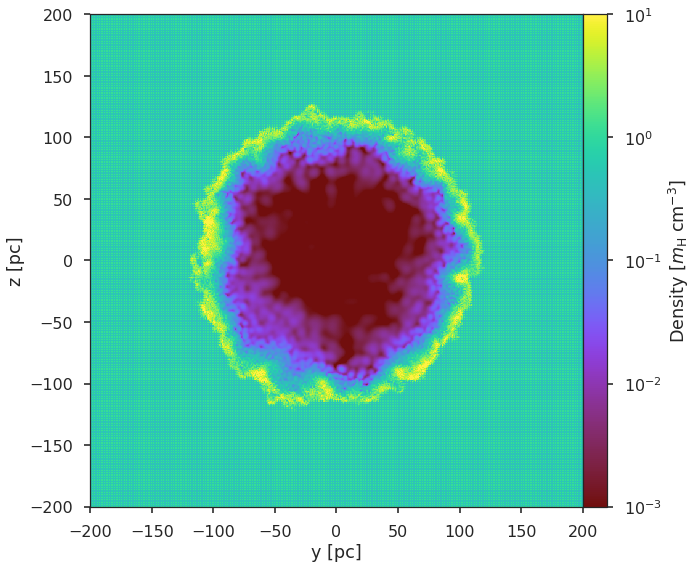

In [18]:
mpl.rcParams['figure.figsize'] = np.array((5,4))*2

# snapshot number *only affects the filename*.
# the density slice is stored in-memory from above.
snapshot_number = 39

with sns.plotting_context(font_scale=.5):
    x = np.linspace(-200, 200, old_arr.shape[0])
    y = np.linspace(-200, 200, old_arr.shape[1])

    ax = plt.subplot(111, aspect="equal", adjustable='box')

    pcm = ax.pcolormesh(x, y, old_arr,
                         cmap=plt.get_cmap("arbre"),
                         norm=LogNorm(1e-3, 1e1),
                        )
    pcm.set_rasterized(True)

    cbr = plt.colorbar(pcm,
                       ticks=[10**i for i in range(-3, 2)],
                       label="Density $ [ m_\mathrm{H} \; \mathrm{cm}^{-3} ] $",
                       pad=0,
        )

    tick_step = 50
    ticks = np.arange(min(x), max(x) + tick_step, tick_step)
    plt.gca().set_xticks(ticks)
    plt.gca().set_yticks(ticks)

    plt.xlim(min(ticks), max(ticks))
    plt.ylim(min(ticks), max(ticks))

    plt.xlabel("y [pc]")
    plt.ylabel("z [pc]")

    plt.tight_layout()
    plot_filename = os.path.join(publication_plots_dir, "density_slice-snapshot_{:03}-200_HD".format(snapshot_number))
    plt.savefig(plot_filename + ".eps", dpi=200)
    plt.savefig(plot_filename + ".pdf")
    plt.savefig(plot_filename + ".png")
    
    plot_filename = os.path.join(publication_plots_dir, "density_slice-snapshot_{:03}-200_HD.lowres".format(snapshot_number))
    plt.savefig(plot_filename + ".eps", dpi=130)
    plt.savefig(plot_filename + ".pdf")
    plt.savefig(plot_filename + ".png")

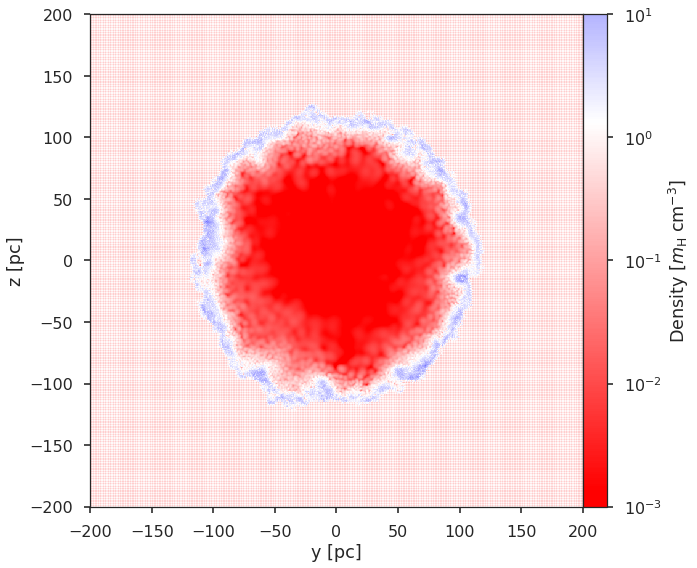

In [19]:
mpl.rcParams['figure.figsize'] = np.array((5,4))*2

with sns.plotting_context(font_scale=.5):
    x = np.linspace(-200, 200, old_arr.shape[0])
    y = np.linspace(-200, 200, old_arr.shape[1])

    ax = plt.subplot(111, aspect="equal", adjustable='box')

    pcm = ax.pcolormesh(x, y, old_arr,
                         cmap=plt.get_cmap("bwr_r"),
                         norm=LogNorm(1.33*1e-3, 1.33*1e3),
                        )

    cbr = plt.colorbar(pcm,
                       boundaries=np.logspace(-3, 1, num=256),
                       ticks=[10**i for i in range(-3, 2)],
                       label="Density $ [ m_\mathrm{H} \; \mathrm{cm}^{-3} ] $",
                       pad=0,
        )

    tick_step = 50
    ticks = np.arange(min(x), max(x) + tick_step, tick_step)
    plt.gca().set_xticks(ticks)
    plt.gca().set_yticks(ticks)

    plt.xlim(min(ticks), max(ticks))
    plt.ylim(min(ticks), max(ticks))

    plt.xlabel("y [pc]")
    plt.ylabel("z [pc]")

    plt.tight_layout()

# Figure 5 - Phase Plots for ever

In [45]:
run_names_profile = [
    "cluster_cooling_400-small_steps",
    "cluster_cooling_200-small_steps",
    "cluster_cooling_100-small_steps",
    "cluster_cooling_mhd_large_200-small_steps",
]

run_names_profile_early = [
    "cluster_cooling_200-small_steps-early",
    "cluster_cooling_mhd_large_200-small_steps-early",
]

snapshot_numbers_early = [13, 14, 15, 16, 17, 18, 19]


In [46]:
weight_fields = np.array(["particle_mass", "cooling_rate"])

In [47]:
def rebin(a, factor):
    """Rebin `a` to a matrix that is `factor` times smaller in each dim
    `factor` must be a positive integer
    
    The bins are combined using the `sum` reduction"""
    sh = a.shape[0]//factor, factor, a.shape[1]//factor, factor
    return a.reshape(sh).sum(-1).sum(1)

In [48]:
z_bounds_from_weight_field = {
    "cooling_rate" : np.array((1e47, 1e51)),
    "particle_mass" : np.array((1e1, 1e6)),
}

In [49]:
z_label_from_weight_field = {
    "cooling_rate" : "Cooling rate distribution\n[erg Myr$^{-1}$ dex$^{-2}$]",
    "particle_mass" : "Mass distribution\n[$M_\odot$ dex$^{-2}$]",
}

In [50]:
# `rebin_factor` must be positive integer factor 
# of both the respective dimensions of Z.shape
rebin_factors = {
    "1D" : 25,
    "cluster_cooling_400-small_steps" : 10,
    "cluster_cooling_200-small_steps" : 10,
    "cluster_cooling_100-small_steps" : 10,
    "cluster_cooling_mhd_large_200-small_steps" : 10,
}

for key in list(rebin_factors.keys()):
    rebin_factors[key + "-early"] = rebin_factors[key]

In [51]:
weight_units = {
    "particle_mass" : "Msun",
    "cooling_rate" : "erg / Myr",
}

In [13]:
snapshot_number = 39
mask = np.array([not is_weight_field_processed(run_names_profile[1], 
                                               snapshot_number, 
                                               weight_field,
                                               pickle_save_dir)
                 for weight_field in weight_fields])

print(mask)

weight_fields[mask]

[False False]


array([], 
      dtype='<U13')

In [20]:
snapshot_numbers = [39, 40]

save_phase_diagram_data_3D(
    run_names_profile,
    snapshot_numbers,
    weight_fields,
    weight_units,
    pickle_save_dir,
)

skipping already-processed fields ['particle_mass' 'cooling_rate'] for snapshot 39, run cluster_cooling_400-small_steps
skipping already-processed fields ['particle_mass' 'cooling_rate'] for snapshot 40, run cluster_cooling_400-small_steps
skipping already-processed fields ['particle_mass' 'cooling_rate'] for snapshot 39, run cluster_cooling_200-small_steps
skipping already-processed fields ['particle_mass' 'cooling_rate'] for snapshot 40, run cluster_cooling_200-small_steps
skipping already-processed fields ['particle_mass' 'cooling_rate'] for snapshot 39, run cluster_cooling_100-small_steps
skipping already-processed fields ['particle_mass' 'cooling_rate'] for snapshot 40, run cluster_cooling_100-small_steps
skipping already-processed fields ['particle_mass' 'cooling_rate'] for snapshot 39, run cluster_cooling_mhd_large_200-small_steps
skipping already-processed fields ['particle_mass' 'cooling_rate'] for snapshot 40, run cluster_cooling_mhd_large_200-small_steps


In [91]:
save_phase_diagram_data_3D(
    run_names_profile_early,
    snapshot_numbers_early,
    weight_fields,
    weight_units,
    pickle_save_dir,
)

skipping already-processed fields [] for snapshot 13, run cluster_cooling_200-small_steps-early


yt : [INFO     ] 2018-01-02 12:36:27,922 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2018-01-02 12:36:27,961 Parameters: current_time              = 2.54415283799
yt : [INFO     ] 2018-01-02 12:36:27,963 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2018-01-02 12:36:27,966 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2018-01-02 12:36:27,969 Parameters: domain_right_edge         = [ 600.  600.  600.]
yt : [INFO     ] 2018-01-02 12:36:27,972 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2018-01-02 12:36:27,981 Allocating for 2.700e+07 particles (index particle type 'all')
yt : [INFO     ] 2018-01-02 12:36:32,444 Identified 2.355e+06 octs


creating save file: publication_plots/data/cluster_cooling_200-small_steps-early-snapshot_013-particle_mass.pickle
creating save file: publication_plots/data/cluster_cooling_200-small_steps-early-snapshot_013-cooling_rate.pickle
skipping already-processed fields ['particle_mass' 'cooling_rate'] for snapshot 14, run cluster_cooling_200-small_steps-early
skipping already-processed fields ['particle_mass' 'cooling_rate'] for snapshot 15, run cluster_cooling_200-small_steps-early
skipping already-processed fields ['particle_mass' 'cooling_rate'] for snapshot 16, run cluster_cooling_200-small_steps-early
skipping already-processed fields ['particle_mass' 'cooling_rate'] for snapshot 17, run cluster_cooling_200-small_steps-early
skipping already-processed fields ['particle_mass' 'cooling_rate'] for snapshot 18, run cluster_cooling_200-small_steps-early
skipping already-processed fields ['particle_mass' 'cooling_rate'] for snapshot 19, run cluster_cooling_200-small_steps-early
skipping alread

### Create phase diagram of 1D

#### Get current time

In [14]:
run_name = run_names_profile[2]

snapshot_number_1D = 39

inputs_dir, outputs_dir = get_dirs(run_name)
ts = load_snapshots(outputs_dir)
snapshot_filenames = get_snapshot_filenames(outputs_dir)

snapshot_number_to_index_map = {snapshot_filename_to_number(filename) : i
                                for i,filename in enumerate(snapshot_filenames) }

uncompressed_snapshot_numbers = sorted(list(snapshot_number_to_index_map.keys()))

current_time = load_ds_from_ts(ts, 
                               snapshot_number_to_index_map[snapshot_number_1D]
                              ).current_time.value
current_time = float(current_time)
current_time

yt : [INFO     ] 2018-01-11 18:24:55,371 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2018-01-11 18:24:55,432 Parameters: current_time              = 7.52999999997
yt : [INFO     ] 2018-01-11 18:24:55,434 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2018-01-11 18:24:55,438 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2018-01-11 18:24:55,441 Parameters: domain_right_edge         = [ 600.  600.  600.]
yt : [INFO     ] 2018-01-11 18:24:55,445 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2018-01-11 18:24:55,454 Allocating for 3.375e+06 particles (index particle type 'all')
yt : [INFO     ] 2018-01-11 18:24:56,270 Identified 2.903e+05 octs


7.529999999973149

#### Find 1D snapshot closest in time

In [15]:
df_1D_snapshot = get_closest_1D_snapshot(current_time, verbose=True, very_verbose=True)
df_1D_snapshot.head()

corrected_times:  [ 0.          0.13062147  0.26545111  0.40466956  0.54840039  0.69677352
  0.84996324  1.00812483  1.1714072   1.33998149  1.51402198  1.69370611
  1.87920818  2.07071831  2.2684488   2.4725803   2.68332193  2.90090184
  3.12553236  3.35744163  3.59687048  3.84405658  4.0992566   4.3627272
  4.63473775  4.91556392  5.20549408  5.50481976  5.81384516  6.13288717
  6.46226899  6.80232971  6.80528304  6.80823637  6.8111897   6.81414303
  6.81709636  6.82005286  6.82300935  6.82596902  6.82892552  6.83188519
  6.83484486  6.83780769  6.84076736  6.84373019  6.84669303  6.84965904
  6.85262187  6.85558788  6.85855388  6.86152306  6.86448906  6.86745824
  6.87042741  6.87339975  6.87636893  6.87934127  6.88231361  6.88528912
  6.88826463  6.89124015  6.89421566  6.89719117  6.90016985  6.90314853
  6.90612721  6.90910906  6.91208774  6.91506959  6.9180546   6.92103645
  6.92402147  6.92700649  6.92999151  6.93297969  6.93596788  6.93895607
  6.94194425  6.94493561  6.947923

/pfs/home/egentry/data/gizmo-clustered-SNe/scripts/visualize_helpers.py:613: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_1D_snapshot["grackle_Temperature"] = grackle_temperature_1D(df_1D_snapshot)
/pfs/home/egentry/data/gizmo-clustered-SNe/scripts/visualize_helpers.py:614: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_1D_snapshot["grackle_cooling_rate"] = grackle_cooling_rate_1D(df_1D_snapshot)


Radius        dR            dV       Density      Pressure      Velocity  \
i                                                                               
0  0.967674  0.277242  7.100905e+55  1.530713e-33  7.925072e-16  1.680211e+06   
1  1.116684  0.149010  5.985489e+55  1.593453e-33  7.924768e-16  1.979521e+06   
2  1.306602  0.189919  1.031494e+56  1.865808e-33  7.941786e-16  2.292224e+06   
3  1.516731  0.210129  1.548863e+56  2.381269e-33  7.938584e-16  2.978378e+06   
4  1.736841  0.220109  2.153885e+56  3.452063e-33  7.933177e-16  3.779304e+06   

          Z          Mass         M_int   Temperature        Energy  \
i                                                                     
0  0.101972  5.466221e-11  5.466221e-11  3.727941e+09  7.766061e+17   
1  0.101972  4.796437e-11  1.026266e-10  3.581019e+09  7.459994e+17   
2  0.101972  9.678622e-11  1.994128e-10  3.064860e+09  6.384728e+17   
3  0.101972  1.854818e-10  3.848946e-10  2.400458e+09  5.000643e+17   
4  0.101972  3.739220e-10  7.588167e-10  1.654733e+09  3.447146e+17   

      Entropy          C_ad  Crossing_time  zones  grackle_Temperature  \
i                                                                        
0  101.763392  9.289218e+08   9.192748e+08      0         3.863033e+09   
1  101.662909  9.104330e+08   5.049465e+08      1         3.710787e+09   
2  101.271650  8.422673e+08   6.956447e+08      2         3.175923e+09   
3  100.661197  7.454039e+08   8.694508e+08      3         2.487445e+09   
4   99.731828  6.188830e+08   1.096729e+09      4         1.714696e+09   

   grackle_cooling_rate  
i                        
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0

In [16]:
df_1D_snapshot[["Temperature", "grackle_Temperature", "grackle_cooling_rate"]].head()

Temperature  grackle_Temperature  grackle_cooling_rate
i                                                         
0  3.727941e+09         3.863033e+09                   0.0
1  3.581019e+09         3.710787e+09                   0.0
2  3.064860e+09         3.175923e+09                   0.0
3  2.400458e+09         2.487445e+09                   0.0
4  1.654733e+09         1.714696e+09                   0.0

In [17]:
affected = (np.abs(df_1D_snapshot.Velocity) > 100)
df_1D_snapshot[["grackle_cooling_rate"]][affected].sum() * Myr

grackle_cooling_rate    2.238016e+50
dtype: float64

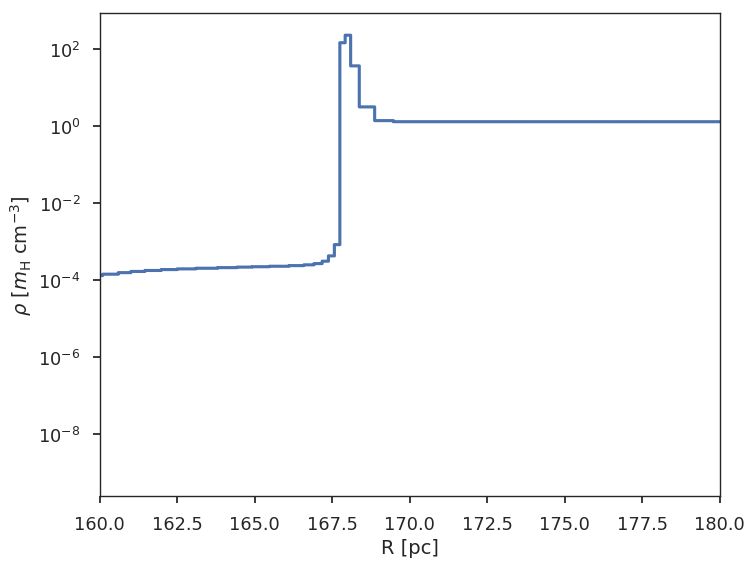

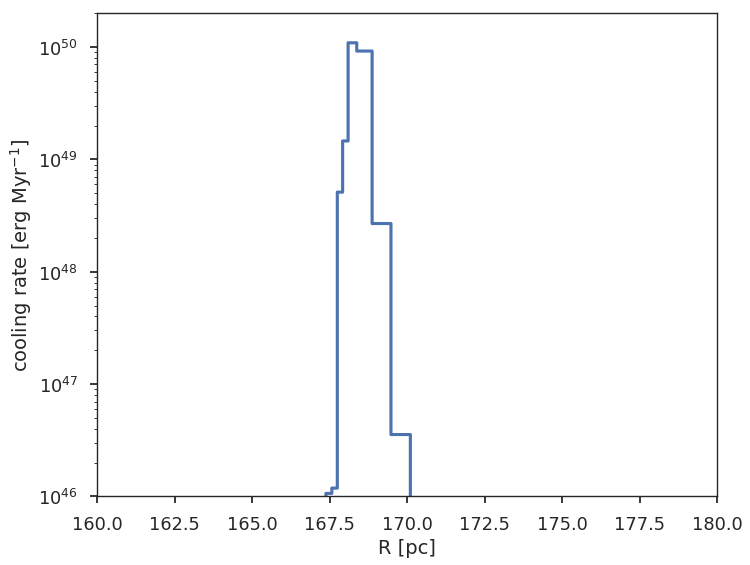

In [18]:
mpl.rcParams['figure.figsize'] = np.array((5,4))*2

plt.plot(
    df_1D_snapshot["Radius"],
    df_1D_snapshot["Density"] / m_proton,
    drawstyle="steps-mid",
)

plt.yscale("log")

plt.xlim(
    xmin=160,
    xmax=180,
)

plt.xlabel("R [pc]")
plt.ylabel(r"$\rho$ [$m_\mathrm{H}$ cm$^{-3}$]")

plt.figure()

plt.plot(
    df_1D_snapshot["Radius"],
    df_1D_snapshot["grackle_cooling_rate"] * Myr,
    drawstyle="steps-mid",
)

plt.ylim(
    ymin=1e46, 
    ymax=2e50,
)
plt.yscale("log")

plt.xlim(
    xmin=160,
    xmax=180,
)

plt.xlabel("R [pc]")
plt.ylabel(r"cooling rate [erg Myr$^{-1}$]")

(10.0, 1000000000.0)

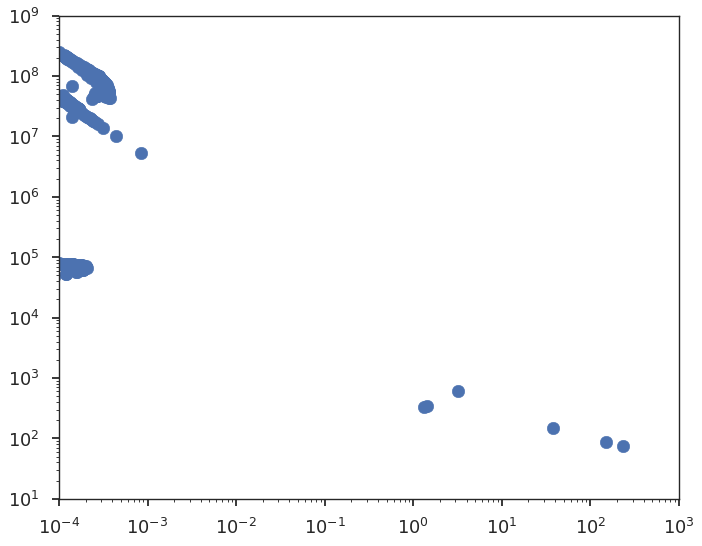

In [19]:
plt.scatter(
    df_1D_snapshot["Density"][affected] / (m_proton),
    df_1D_snapshot["grackle_Temperature"][affected]
)

plt.xscale("log")
plt.yscale("log")

plt.xlim(1e-4, 1e3)
plt.ylim(1e1, 1e9)

#### Create + save a batch of 1D histogram'd data

In [25]:
snapshot_numbers = [14, 37, 38, 39, 40, 41]
snapshot_numbers = [37, 38, 39, 40, 41]


save_phase_diagram_data_1D(
    snapshot_numbers,
    weight_fields,
    pickle_save_dir,
    run_names_profile[2])

yt : [INFO     ] 2018-01-11 18:30:16,155 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2018-01-11 18:30:16,203 Parameters: current_time              = 7.50999999995
yt : [INFO     ] 2018-01-11 18:30:16,205 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2018-01-11 18:30:16,209 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2018-01-11 18:30:16,213 Parameters: domain_right_edge         = [ 600.  600.  600.]
yt : [INFO     ] 2018-01-11 18:30:16,216 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2018-01-11 18:30:16,226 Allocating for 3.375e+06 particles (index particle type 'all')
yt : [INFO     ] 2018-01-11 18:30:17,306 Identified 2.903e+05 octs


37 7.509999999946298
using snapshot: 263 at time 7.509 Myr


/pfs/home/egentry/data/gizmo-clustered-SNe/scripts/visualize_helpers.py:613: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_1D_snapshot["grackle_Temperature"] = grackle_temperature_1D(df_1D_snapshot)
/pfs/home/egentry/data/gizmo-clustered-SNe/scripts/visualize_helpers.py:614: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_1D_snapshot["grackle_cooling_rate"] = grackle_cooling_rate_1D(df_1D_snapshot)
yt : [INFO     ] 2018-01-11 18:30:24,707 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2018-01-11 18:30:24,726 Para

38 7.519999999912882
using snapshot: 266 at time 7.519 Myr


/pfs/home/egentry/data/gizmo-clustered-SNe/scripts/visualize_helpers.py:613: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_1D_snapshot["grackle_Temperature"] = grackle_temperature_1D(df_1D_snapshot)
/pfs/home/egentry/data/gizmo-clustered-SNe/scripts/visualize_helpers.py:614: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_1D_snapshot["grackle_cooling_rate"] = grackle_cooling_rate_1D(df_1D_snapshot)
yt : [INFO     ] 2018-01-11 18:30:33,515 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2018-01-11 18:30:33,534 Para

39 7.529999999973149
using snapshot: 270 at time 7.531 Myr


/pfs/home/egentry/data/gizmo-clustered-SNe/scripts/visualize_helpers.py:613: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_1D_snapshot["grackle_Temperature"] = grackle_temperature_1D(df_1D_snapshot)
/pfs/home/egentry/data/gizmo-clustered-SNe/scripts/visualize_helpers.py:614: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_1D_snapshot["grackle_cooling_rate"] = grackle_cooling_rate_1D(df_1D_snapshot)
yt : [INFO     ] 2018-01-11 18:30:41,920 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2018-01-11 18:30:41,957 Para

40 7.539999999939733
using snapshot: 273 at time 7.541 Myr


/pfs/home/egentry/data/gizmo-clustered-SNe/scripts/visualize_helpers.py:613: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_1D_snapshot["grackle_Temperature"] = grackle_temperature_1D(df_1D_snapshot)
/pfs/home/egentry/data/gizmo-clustered-SNe/scripts/visualize_helpers.py:614: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_1D_snapshot["grackle_cooling_rate"] = grackle_cooling_rate_1D(df_1D_snapshot)
yt : [INFO     ] 2018-01-11 18:30:50,613 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2018-01-11 18:30:50,634 Para

41 7.55
using snapshot: 276 at time 7.550 Myr


/pfs/home/egentry/data/gizmo-clustered-SNe/scripts/visualize_helpers.py:613: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_1D_snapshot["grackle_Temperature"] = grackle_temperature_1D(df_1D_snapshot)
/pfs/home/egentry/data/gizmo-clustered-SNe/scripts/visualize_helpers.py:614: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_1D_snapshot["grackle_cooling_rate"] = grackle_cooling_rate_1D(df_1D_snapshot)


#### Make some plots to check the data are good

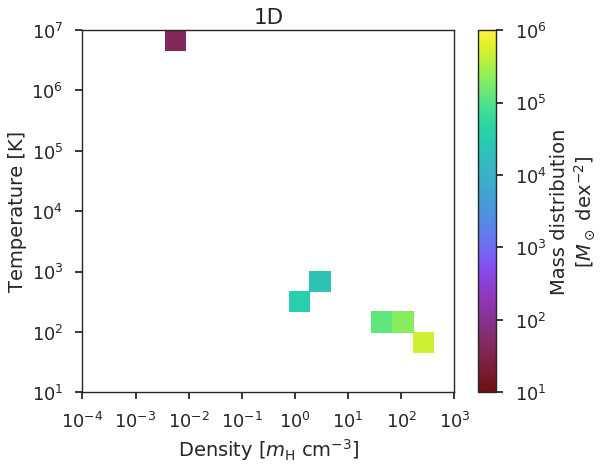

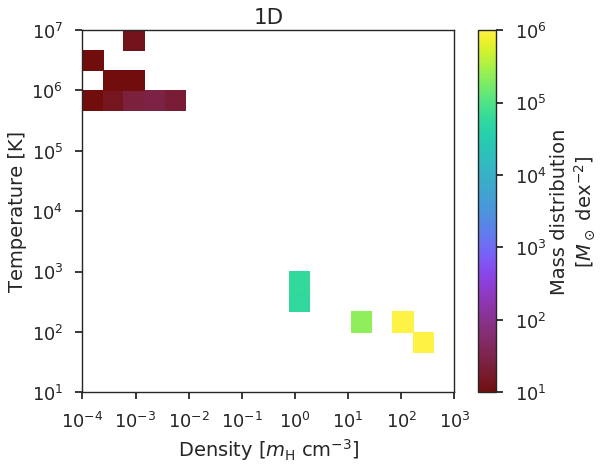

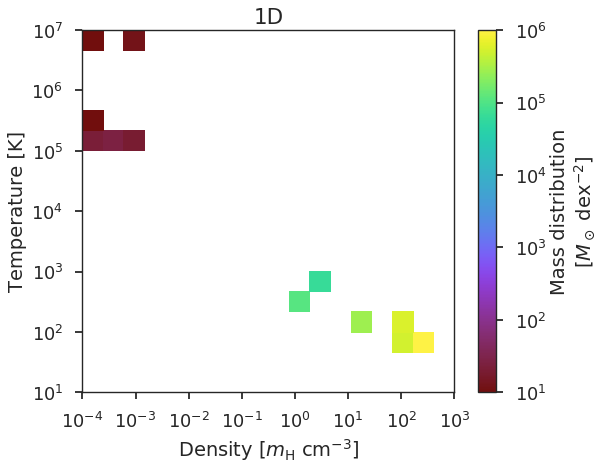

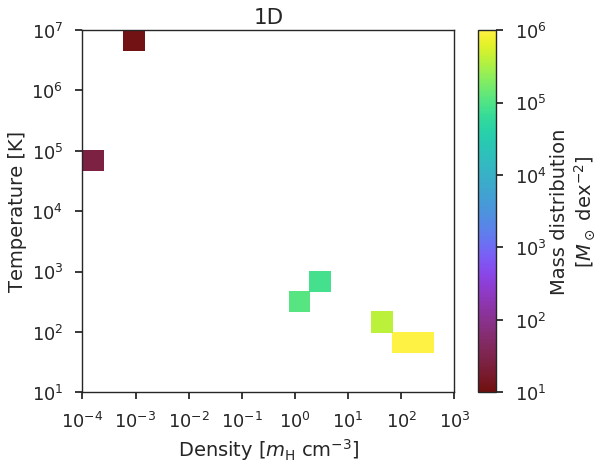

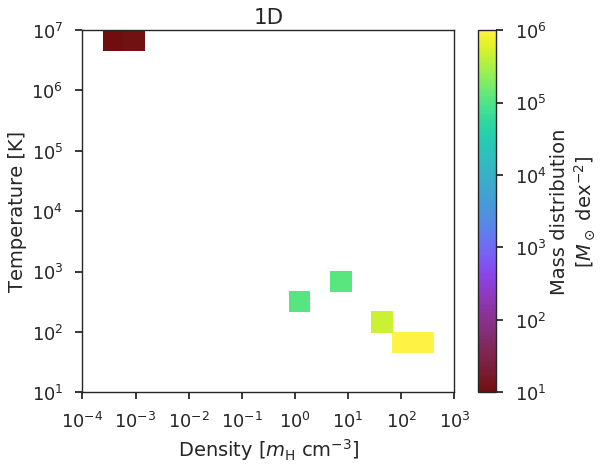

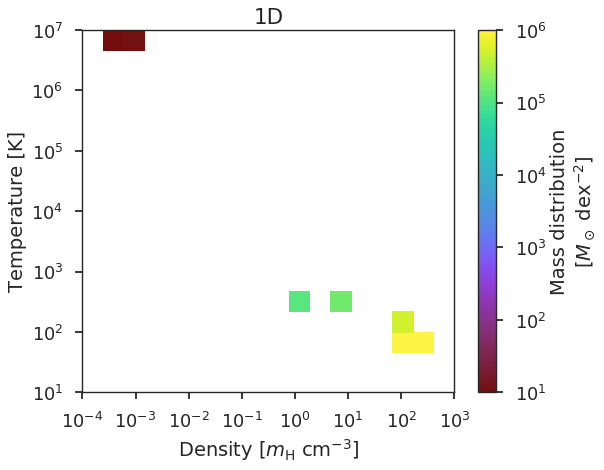

In [26]:
mpl.rcParams['figure.figsize'] = np.array((5,4))*1.5

snapshot_numbers = [14, 37, 38, 39, 40, 41]

for snapshot_number in snapshot_numbers:
    pickle_filename = get_pickle_filename_profile("1D", snapshot_number, "particle_mass", pickle_save_dir)
    with open(pickle_filename, mode="rb") as pf:
        x, y, Z = pickle.load(pf)
        
    rebin_factor = rebin_factors["1D"]
    x = x[::rebin_factor]
    y = y[::rebin_factor]
    Z = rebin(Z, rebin_factor)
    
    Z *= Z.size / np.log10(x.max() / x.min()) / np.log10(y.max() / y.min())

    plt.figure()
    plt.pcolor(x, y, Z.T,
        norm=LogNorm(
            *z_bounds_from_weight_field["particle_mass"]
        ),
        edgecolors="none",
        cmap=plt.get_cmap("arbre"), 
              )

    plt.colorbar(label=z_label_from_weight_field["particle_mass"],
                 ticks=LogLocator())

    plt.xlabel("Density $ [ m_\mathrm{H} \; \mathrm{cm}^{-3} ] $")
    plt.ylabel("Temperature [K]")

    plt.xscale("log")
    plt.yscale("log")
    plt.title("1D")

    plt.minorticks_off()


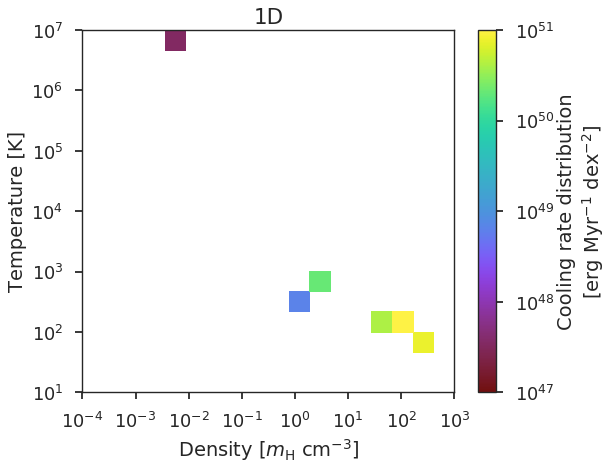

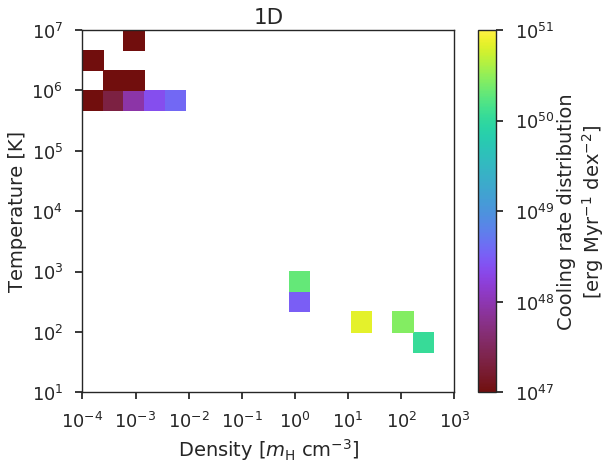

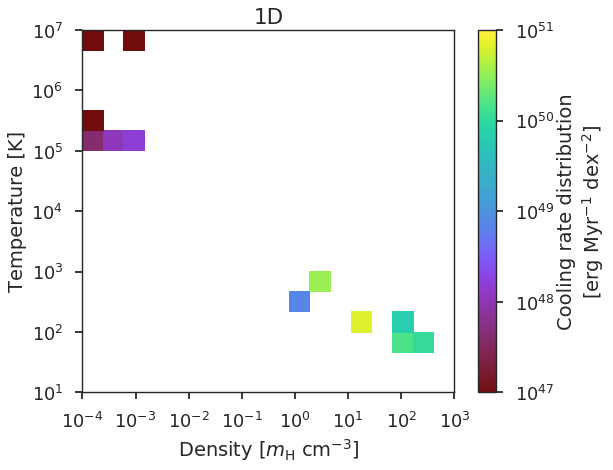

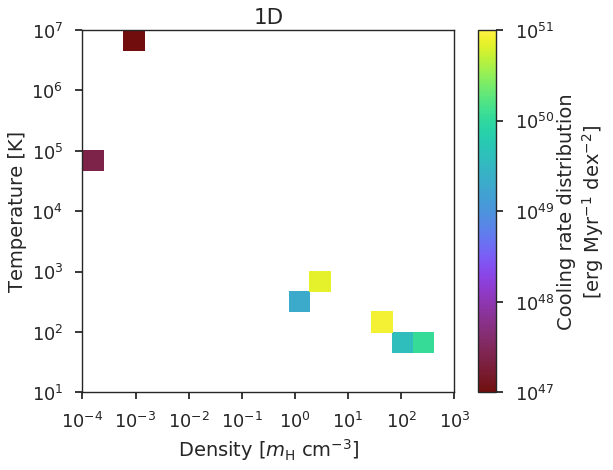

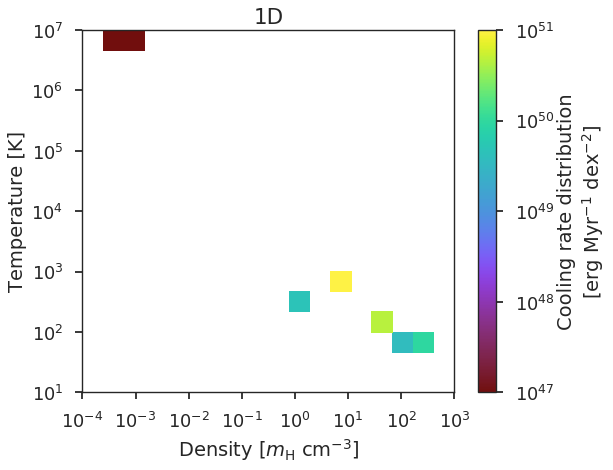

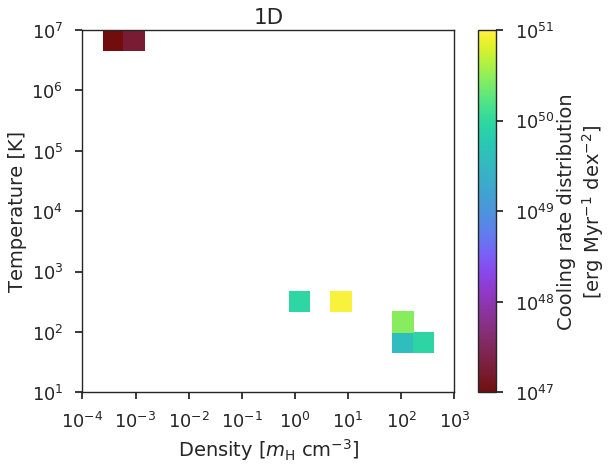

In [27]:
mpl.rcParams['figure.figsize'] = np.array((5,4))*1.5

snapshot_numbers = [14, 37, 38, 39, 40, 41]

for snapshot_number in snapshot_numbers:
    pickle_filename = get_pickle_filename_profile("1D", snapshot_number, "cooling_rate", pickle_save_dir)
    with open(pickle_filename, mode="rb") as pf:
        x, y, Z = pickle.load(pf)

    rebin_factor = rebin_factors["1D"]
    x = x[::rebin_factor]
    y = y[::rebin_factor]
    Z = rebin(Z, rebin_factor)
    
    # normalize Z to per dex**2, not per bin, to allow for different bin sizes
    Z *= Z.size / np.log10(x.max() / x.min()) / np.log10(y.max() / y.min())
        
    plt.figure()

    plt.pcolor(x, y, Z.T,
        norm=LogNorm(
            *z_bounds_from_weight_field["cooling_rate"]
        ),
        edgecolors="none",
        cmap=plt.get_cmap("arbre"), 
              )

    plt.colorbar(label=z_label_from_weight_field["cooling_rate"],
                 ticks=LogLocator())

    plt.xlabel("Density $ [ m_\mathrm{H} \; \mathrm{cm}^{-3} ] $")
    plt.ylabel("Temperature [K]")

    plt.xscale("log")
    plt.yscale("log")
    plt.title("1D")

    plt.minorticks_off()


### Plot single figures

In [20]:
title_map = {
    "1D" : "1D_06_HD",
    "cluster_cooling_400-small_steps" :  "3D_10_HD",
    "cluster_cooling_200-small_steps" :  "3D_20_HD",
    "cluster_cooling_100-small_steps" :  "3D_40_HD",
    "cluster_cooling_mhd_large_200-small_steps" :  "3D_20_MHD",
}

for key in list(title_map.keys()):
    title_map[key + "-early"] = title_map[key]

In [ ]:
run_summary_hi_res = RunSummary("1D_data-high_time_res/",
                                "F5509BF1-3F9E-4008-B795-0482ECED199B")

In [28]:
def get_total_cooling_rate(run_name, snapshot_number):
    pickle_filename = get_pickle_filename_profile(run_name, 
                                                  snapshot_number, 
                                                  "cooling_rate",
                                                  pickle_save_dir)
    with open(pickle_filename, "rb") as pickle_file:
        x, y, Z = pickle.load(pickle_file)
    total_cooling_rate = Z.sum()
    
    return total_cooling_rate  

def get_total_internal_energy(run_name, snapshot_number, verbose=True):
    if "1D".lower() in run_name.lower():
        assert(snapshot_number == snapshot_number_1D)
        first_1D_snapshot = get_closest_1D_snapshot(0, verbose=verbose, very_verbose=verbose)

        first_snapshot_energy = (first_1D_snapshot.Energy * first_1D_snapshot.Mass).sum() * M_solar
        first_SN_energy = 1e51
        
        initial_background_energy = first_snapshot_energy - first_SN_energy
        
        later_snapshot_energy = (df_1D_snapshot.Energy * df_1D_snapshot.Mass).sum() * M_solar
        
        delta_E_int = later_snapshot_energy - initial_background_energy
        return delta_E_int
        
    else:
        add_simulation(run_name, verbose=verbose)
        df = open_as_DataFrame(run_name)
        return float((df.e_int[df.number==snapshot_number] - df.e_int.loc[0]).values)
    

def get_total_cooling_time(run_name, snapshot_number, verbose=True):
    """returns value in units of Myr"""
    cooling_rate = get_total_cooling_rate(run_name, snapshot_number)
    internal_energy = get_total_internal_energy(run_name, snapshot_number, verbose=verbose)
    
    return internal_energy / cooling_rate
    



snapshot_number = 39
print("----------- snapshot {} -------------".format(snapshot_number))
for run_name in ["1D"] + run_names_profile:
    print("for {}, cooling rate = {:.1e} erg / Myr".format(run_name, 
                                                           get_total_cooling_rate(run_name, 
                                                                                  snapshot_number)))
print()
    
snapshot_number = 15
print("----------- snapshot {} -------------".format(snapshot_number))
for run_name in run_names_profile_early:
    print("for {}, cooling rate = {:.1e} erg / Myr".format(run_name, 
                                                           get_total_cooling_rate(run_name, 
                                                                                  snapshot_number)))

    
snapshot_number = 39
print("----------- snapshot {} -------------".format(snapshot_number))
for run_name in ["1D"] + run_names_profile:
    print("for {}, E_int = {:.1e} erg".format(run_name, 
                                              get_total_internal_energy(run_name, 
                                                                        snapshot_number, 
                                                                        verbose=False)))
print()
    
snapshot_number = 15
print("----------- snapshot {} -------------".format(snapshot_number))
for run_name in run_names_profile_early:
    print("for {}, E_int = {:.1e} erg".format(run_name, 
                                              get_total_internal_energy(run_name, 
                                                                        snapshot_number,
                                                                        verbose=False)))


----------- snapshot 39 -------------
for 1D, cooling rate = 2.2e+50 erg / Myr
for cluster_cooling_400-small_steps, cooling rate = 2.6e+49 erg / Myr
for cluster_cooling_200-small_steps, cooling rate = 1.4e+50 erg / Myr
for cluster_cooling_100-small_steps, cooling rate = 1.9e+51 erg / Myr
for cluster_cooling_mhd_large_200-small_steps, cooling rate = 8.7e+50 erg / Myr

----------- snapshot 15 -------------
for cluster_cooling_200-small_steps-early, cooling rate = 6.8e+50 erg / Myr
for cluster_cooling_mhd_large_200-small_steps-early, cooling rate = 5.3e+50 erg / Myr
----------- snapshot 39 -------------


/pfs/home/egentry/data/gizmo-clustered-SNe/scripts/visualize_helpers.py:613: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_1D_snapshot["grackle_Temperature"] = grackle_temperature_1D(df_1D_snapshot)
/pfs/home/egentry/data/gizmo-clustered-SNe/scripts/visualize_helpers.py:614: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_1D_snapshot["grackle_cooling_rate"] = grackle_cooling_rate_1D(df_1D_snapshot)


for 1D, E_int = 1.5e+51 erg
for cluster_cooling_400-small_steps, E_int = 7.2e+50 erg
for cluster_cooling_200-small_steps, E_int = 7.1e+50 erg
for cluster_cooling_100-small_steps, E_int = 5.9e+50 erg
for cluster_cooling_mhd_large_200-small_steps, E_int = 7.5e+50 erg

----------- snapshot 15 -------------
for cluster_cooling_200-small_steps-early, E_int = 4.6e+50 erg
for cluster_cooling_mhd_large_200-small_steps-early, E_int = 7.6e+50 erg


In [29]:

snapshot_number = 39
print("----------- snapshot {} -------------".format(snapshot_number))
for run_name in ["1D"] + run_names_profile:
    print("for {}, t_cool = {:.1f} Myr".format(run_name, 
                                              get_total_cooling_time(run_name,
                                                                     snapshot_number,
                                                                     verbose=False)))
print()
    
snapshot_number = 15
print("----------- snapshot {} -------------".format(snapshot_number))
for run_name in run_names_profile_early:
    print("for {}, t_cool = {:.1f} Myr".format(run_name, 
                                              get_total_cooling_time(run_name,
                                                                     snapshot_number,
                                                                     verbose=False)))


----------- snapshot 39 -------------


/pfs/home/egentry/data/gizmo-clustered-SNe/scripts/visualize_helpers.py:613: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_1D_snapshot["grackle_Temperature"] = grackle_temperature_1D(df_1D_snapshot)
/pfs/home/egentry/data/gizmo-clustered-SNe/scripts/visualize_helpers.py:614: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_1D_snapshot["grackle_cooling_rate"] = grackle_cooling_rate_1D(df_1D_snapshot)


for 1D, t_cool = 6.5 Myr
for cluster_cooling_400-small_steps, t_cool = 27.3 Myr
for cluster_cooling_200-small_steps, t_cool = 5.1 Myr
for cluster_cooling_100-small_steps, t_cool = 0.3 Myr
for cluster_cooling_mhd_large_200-small_steps, t_cool = 0.9 Myr

----------- snapshot 15 -------------
for cluster_cooling_200-small_steps-early, t_cool = 0.7 Myr
for cluster_cooling_mhd_large_200-small_steps-early, t_cool = 1.4 Myr


In [30]:
def plot_phase_diagram_subplots(ax, run_name, snapshot_number, weight_field,
                                rebin_factor=1):
        pickle_filename = get_pickle_filename_profile(run_name, 
                                                      snapshot_number, 
                                                      weight_field,
                                                      pickle_save_dir)
        with open(pickle_filename, "rb") as pickle_file:
            x, y, Z = pickle.load(pickle_file)
            
        # `rebin_factor` must be positive integer factor of x.size *and* y.size
        x = x[::rebin_factor]
        y = y[::rebin_factor]
        Z = rebin(Z, rebin_factor)
        
        if weight_field == "cooling_rate":
            print("total cooling rate: {:.1e} erg/Myr for {}".format(float(Z.sum()), run_name))
            
        # normalize Z to per dex**2, not per bin, to allow for different bin sizes
        Z *= Z.size / np.log10(x.max() / x.min()) / np.log10(y.max() / y.min())
        
        if weight_field == "cooling_rate":
            # remap zones with net heating to the minimum of the colorbar
            print("cooling bounds (per dex): {:.2e}, {:.2e}".format(Z[Z>0].min(), 
                                                          Z.max()))
            Z[Z<0] = z_bounds_from_weight_field[weight_field][0]         

        im = ax.pcolor(x, y, Z.T,
                   cmap=plt.get_cmap("arbre"), 
                   norm=LogNorm(*z_bounds_from_weight_field[weight_field]),
                   edgecolors="none")

        ax.set_xscale("log")
        ax.set_yscale("log")
        
        ax.minorticks_off()

        return im
            

total cooling rate: 2.6e+49 erg/Myr for cluster_cooling_400-small_steps
cooling bounds (per dex): 4.10e+44, 4.38e+49
total cooling rate: 1.4e+50 erg/Myr for cluster_cooling_200-small_steps
cooling bounds (per dex): 1.20e+44, 1.85e+50
total cooling rate: 1.9e+51 erg/Myr for cluster_cooling_100-small_steps
cooling bounds (per dex): 4.17e+45, 5.61e+51
total cooling rate: 8.7e+50 erg/Myr for cluster_cooling_mhd_large_200-small_steps
cooling bounds (per dex): 5.84e+44, 1.14e+51


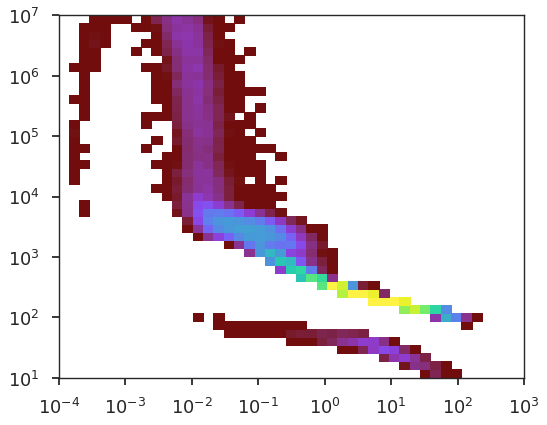

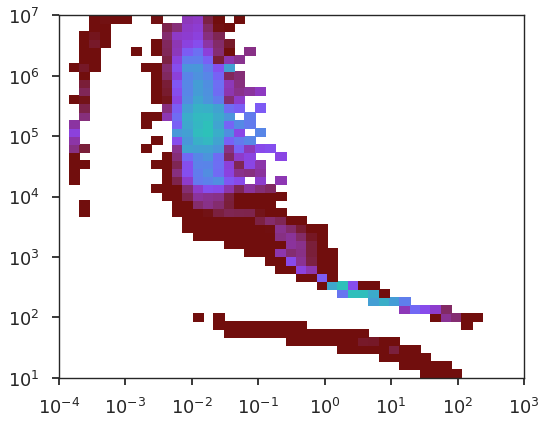

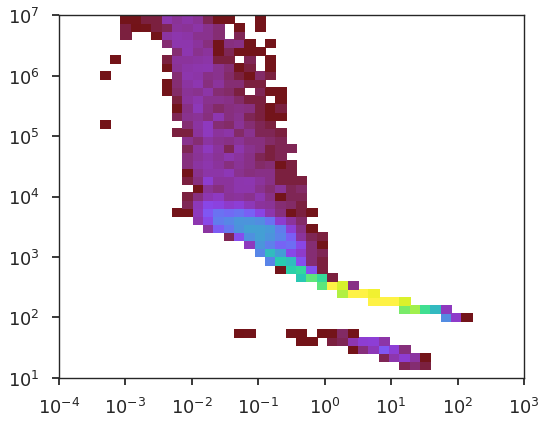

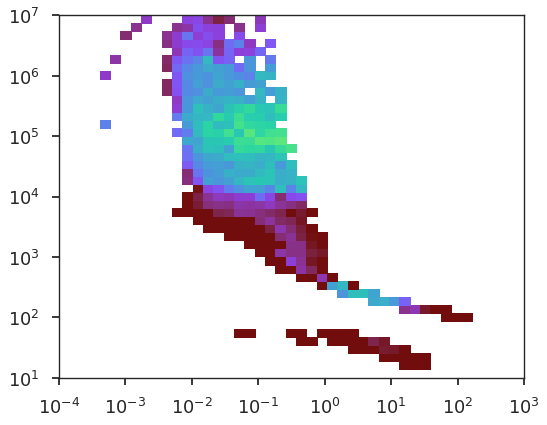

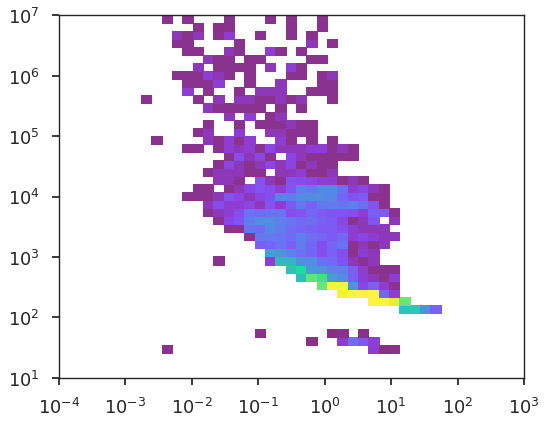

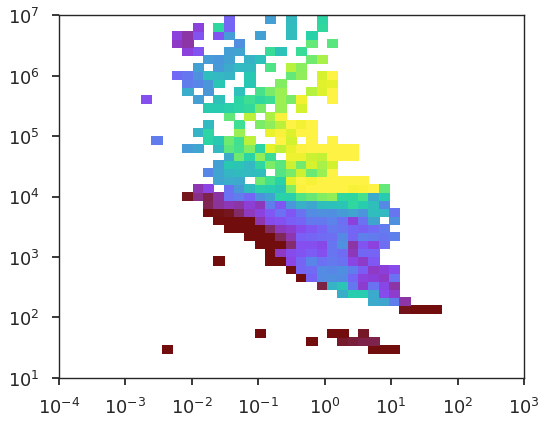

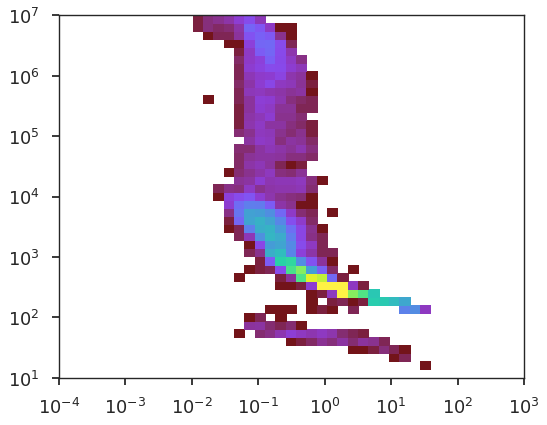

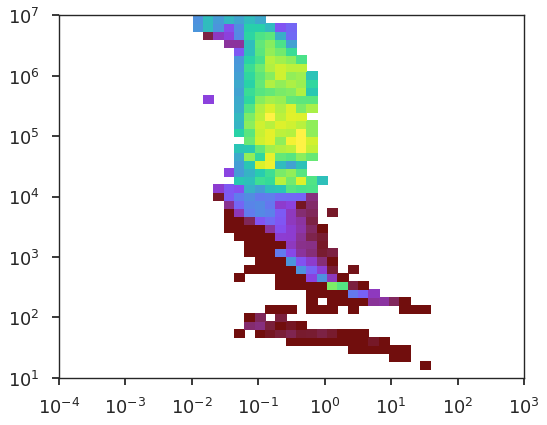

In [31]:
mpl.rcParams['figure.figsize'] = np.array((5,4))*1.5

from matplotlib.colors import LogNorm

snapshot_number = 39
for run_name in run_names_profile:
    for weight_field in weight_fields:
        plt.figure()
        plot_phase_diagram_subplots(plt.gca(), run_name, snapshot_number, weight_field,
                                    rebin_factor=rebin_factors[run_name])

### Plot as subplots

In [32]:
# def plot_phase_diagram_combined_horizontal(run_names, snapshot_number):
#     import warnings
#     warnings.warn("This function is no longer supported; see `plot_phase_diagram_combined_vertical` instead")
    
#     mpl.rcParams['figure.figsize'] = np.array((5*len(run_names)/2,4))*1.5

#     f, axarr = plt.subplots(nrows=2, ncols=len(run_names),
#                             sharex="col", sharey="row")

#     reference_color_mappables = {} # for making the colorbars at the very end
#     for i_col, run_name in enumerate(run_names):
#         for j_row, weight_field in enumerate(weight_fields):
#             ax = axarr[j_row, i_col]
#             reference_color_mappables[weight_field] = plot_phase_diagram_subplots(
#                 ax, 
#                 run_name, snapshot_number, weight_field,
#                 rebin_factor=rebin_factors[run_name],
#             )

#     left_pad = .08
#     bottom_pad=.16
#     top_pad = .12
#     f.subplots_adjust(hspace=.15, wspace=.17, 
#                       bottom=bottom_pad, 
#                       left=left_pad,
#                       top =1 - top_pad,
#                      )


#     # make room for the colorbars.
#     # if you just add a colorbar to the rightmost `ax`, it'll shrink that plot,
#     # making the aspect ratio different from the other plots
#     width_of_real_axes = 0.87 - left_pad
#     f.subplots_adjust(right=width_of_real_axes + left_pad)

#     colorbar_height = .335 # This is a guess; I really wish I could just solve this correctly...
#     colorbar_width = 0.01 # this is pretty flexible

#     # Add colorbar for particle mass
#     cbar_ax = f.add_axes([width_of_real_axes + left_pad + .01,
#                           1 - top_pad - colorbar_height,
#                           colorbar_width,
#                           colorbar_height])
#     weight_field = weight_fields[0]
#     cb = plt.colorbar(reference_color_mappables[weight_field],
#                       label=z_label_from_weight_field[weight_field], 
#                       cax=cbar_ax,
#                       ticks=LogLocator(),)

#     # Add colorbar for cooling_rate
#     cbar_ax = f.add_axes([width_of_real_axes + left_pad + .01,
#                           bottom_pad,
#                           colorbar_width,
#                           colorbar_height])
#     weight_field = weight_fields[1]
#     cb = plt.colorbar(reference_color_mappables[weight_field],
#                       label=z_label_from_weight_field[weight_field], 
#                       cax=cbar_ax,
#                       ticks=LogLocator(),)


#     # Now add x and y labels, so that they're shared between rows + cols 
#     new_left = 0.03
#     real_axes_center_width = (width_of_real_axes)/2 + left_pad
#     new_width = 2*(real_axes_center_width - new_left) 
#     new_bottom = 0.07
#     real_axes_center_height = (1 - top_pad - bottom_pad)*.5 + bottom_pad
#     new_height = 2*(real_axes_center_height - new_bottom) 
#     big_ax = f.add_axes([new_left, new_bottom, new_width, new_height], frameon=False)
#     big_ax.xaxis.set_ticks([])
#     big_ax.yaxis.set_ticks([])
#     big_ax.set_xlabel(r"Density $ \left[ m_\mathrm{H} \; \mathrm{cm}^{-3} \right] $")
#     big_ax.set_ylabel("Temperature [K]")

#     plot_filename = os.path.join(publication_plots_dir, 
#                                  "phase_diagrams-snapshot_{:03}".format(snapshot_number))
#     print("saving: ", plot_filename)
#     plt.savefig(plot_filename + ".eps")
#     plt.savefig(plot_filename + ".pdf")
#     plt.savefig(plot_filename + ".png")

In [33]:
def to_scientific_notation(number):
    exp_format = "{:.1e}".format(number)
    scientific_notation = r"{} $\times$ 10$^{{{}}}$".format(*exp_format.replace("+", "").split("e"))
    return scientific_notation
    
    
to_scientific_notation(1.3e51)

'1.3 $\\times$ 10$^{51}$'

In [34]:
def plot_phase_diagram_combined_vertical(run_names, snapshot_number, 
                                         save=True,
                                         left_pad=.12,
                                         bottom_pad=0.06,
                                         top_pad=0.1,
                                         right_pad=0.23,
                                         colorbar_width=0.302,
                                         colorbar_height=.01,
                                         new_bottom=0.03,
                                         new_left=0.05,
                                        ):
    """Creates a combined set of subplots for `run_names` at `snapshot_number`
    where the rows are different simulations (`run_names`),
    and the columns are phase diagrams weighted by mass and cooling rate.
    
    The `*_pad` parameters are padding parameters for the *core* subplots
    (the actual phase diagrams, sans axes labels, text to the right, or colorbars).
    
    The `colorbar_(width|height)` parameters are for the *actual colorbar*,
    the part which is colorful, *not* the ticks or labels.
    In theory you could calculate the correct `colorbar_width` from the geometry,
    but it's a pain, because the padding parameters are set in fraction of figure,
    whereas `hspace` and `wspace` (space between subplots) are set by fraction of
    average subplot width.
    
    The `new_*` parameters set the [invisible] axes which are used for the
    shared x and y axis labels. If you just used the default subplots, the
    label would be repeated for each plot, which just gets a little distracting.
    
    """
    mpl.rcParams['figure.figsize'] = np.array((7.5, 4*(len(run_names)+1)/2))*1.5

    f, axarr = plt.subplots(nrows=len(run_names), ncols=2,
                            sharex="col", sharey="row")
    
    left_pad = left_pad
    bottom_pad = bottom_pad
    top_pad = top_pad
    right_pad = right_pad
    f.subplots_adjust(hspace=.14, wspace=.16, 
                      bottom=bottom_pad, 
                      left=left_pad,
                      top =1 - top_pad,
                      right = 1 - right_pad,
                     )

    reference_color_mappables = {} # for making the colorbars at the very end
    for j_col, run_name in enumerate(run_names):
        for i_row, weight_field in enumerate(weight_fields):
            ax = axarr[j_col, i_row]
            reference_color_mappables[weight_field] = plot_phase_diagram_subplots(
                ax, 
                run_name, snapshot_number, weight_field,
                rebin_factor=rebin_factors[run_name],
            )
            
            x_lim = ax.get_xlim()
            x_tick_locs = [10**i
                           for i in np.arange(np.log10(x_lim[0]), 
                                              np.log10(x_lim[1])+1)]
            ax.xaxis.set_ticks(x_tick_locs)
            label_stride = 2 
            x_tick_labels = ["$10^{{{:.0f}}}$".format(np.log10(x_tick_locs[i])) if i%label_stride==0
                             else ""
                             for i in range(len(x_tick_locs))
            ]
            ax.xaxis.set_ticklabels(x_tick_labels)
            
            y_lim = ax.get_ylim()
            y_tick_locs = [10**i
                           for i in np.arange(np.log10(y_lim[0]), 
                                              np.log10(y_lim[1])+1)]
            ax.yaxis.set_ticks(y_tick_locs)
            label_stride = 2
            y_tick_labels = ["$10^{{{:.0f}}}$".format(np.log10(y_tick_locs[i])) if i%label_stride==0
                             else ""
                             for i in range(len(y_tick_locs))
            ]
            ax.yaxis.set_ticklabels(y_tick_labels)

#             ax.set_facecolor("black")

        total_cooling_rate = get_total_cooling_rate(run_name, snapshot_number)
        total_cooling_time = get_total_cooling_time(run_name, snapshot_number, verbose=False)
        
        
#         ax.text(1.1, .7, title_map[run_name] \
#                 + "\n" \
#                 + r"$\dot{{E}}_\mathrm{{cool}}$ = {}".format(
#                         to_scientific_notation(total_cooling_rate)
#                     )
#                 + "\n            erg Myr$^{{-1}}$",
#                 transform=ax.transAxes, verticalalignment='top', 
#                )


        ax.text(1.1, .6, title_map[run_name] \
                + "\n" \
                + r"$t_\mathrm{{cool}}$ = {:.1f}".format(
                        total_cooling_time
                    )
                + " Myr",
                transform=ax.transAxes, verticalalignment='top', 
               )

    # make room for the colorbars.
    # if you just add a colorbar to the rightmost `ax`, it'll shrink that plot,
    # making the aspect ratio different from the other plots

    colorbar_height = colorbar_height # This is a guess; I really wish I could just solve this correctly...
    colorbar_width = colorbar_width # this is pretty flexible

    # Add colorbar for particle mass
    cbar_ax = f.add_axes([left_pad,
                          1 - top_pad + .5*colorbar_height,
                          colorbar_width,
                          colorbar_height])
    weight_field = weight_fields[0]
    cb = plt.colorbar(reference_color_mappables[weight_field],
                      label=z_label_from_weight_field[weight_field], 
                      cax=cbar_ax,
                      ticks=LogLocator(),
                      orientation='horizontal')
    cb.ax.xaxis.set_ticks_position('top')
    cb.ax.xaxis.set_label_position('top')

    # Add colorbar for cooling_rate
    cbar_ax = f.add_axes([1-right_pad - colorbar_width,
                          1-top_pad + .5*colorbar_height,
                          colorbar_width,
                          colorbar_height])
    weight_field = weight_fields[1]
    cb = plt.colorbar(reference_color_mappables[weight_field],
                      label=z_label_from_weight_field[weight_field], 
                      cax=cbar_ax,
                      ticks=LogLocator(),
                      orientation='horizontal')
    cb.ax.xaxis.set_ticks_position('top')
    cb.ax.xaxis.set_label_position('top')


    # Now add x and y labels, so that they're shared between rows + cols 
    new_left = 0.05
    real_axes_center_width = (1 - left_pad - right_pad)*.5 + left_pad
    new_width = 2*(real_axes_center_width - new_left) 
    new_bottom = new_bottom
    real_axes_center_height = (1 - top_pad - bottom_pad)*.5 + bottom_pad
    new_height = 2*(real_axes_center_height - new_bottom) 
    big_ax = f.add_axes([new_left, new_bottom, new_width, new_height], frameon=False)
    big_ax.xaxis.set_ticks([])
    big_ax.yaxis.set_ticks([])
    big_ax.set_xlabel(r"Density $ \left[ m_\mathrm{H} \; \mathrm{cm}^{-3} \right] $")
    big_ax.set_ylabel("Temperature [K]")
    
    if save:
        plot_filename = os.path.join(publication_plots_dir, 
                                     "phase_diagrams-snapshot_{:03}".format(snapshot_number))
        print("saving: ", plot_filename)
        plt.savefig(plot_filename + ".eps")
        plt.savefig(plot_filename + ".pdf")
        plt.savefig(plot_filename + ".png")

total cooling rate: 2.2e+50 erg/Myr for 1D
cooling bounds (per dex): 9.15e+46, 8.42e+50


/pfs/home/egentry/data/gizmo-clustered-SNe/scripts/visualize_helpers.py:613: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_1D_snapshot["grackle_Temperature"] = grackle_temperature_1D(df_1D_snapshot)
/pfs/home/egentry/data/gizmo-clustered-SNe/scripts/visualize_helpers.py:614: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_1D_snapshot["grackle_cooling_rate"] = grackle_cooling_rate_1D(df_1D_snapshot)


total cooling rate: 2.6e+49 erg/Myr for cluster_cooling_400-small_steps
cooling bounds (per dex): 4.10e+44, 4.38e+49
total cooling rate: 1.4e+50 erg/Myr for cluster_cooling_200-small_steps
cooling bounds (per dex): 1.20e+44, 1.85e+50
total cooling rate: 1.9e+51 erg/Myr for cluster_cooling_100-small_steps
cooling bounds (per dex): 4.17e+45, 5.61e+51
total cooling rate: 8.7e+50 erg/Myr for cluster_cooling_mhd_large_200-small_steps
cooling bounds (per dex): 5.84e+44, 1.14e+51


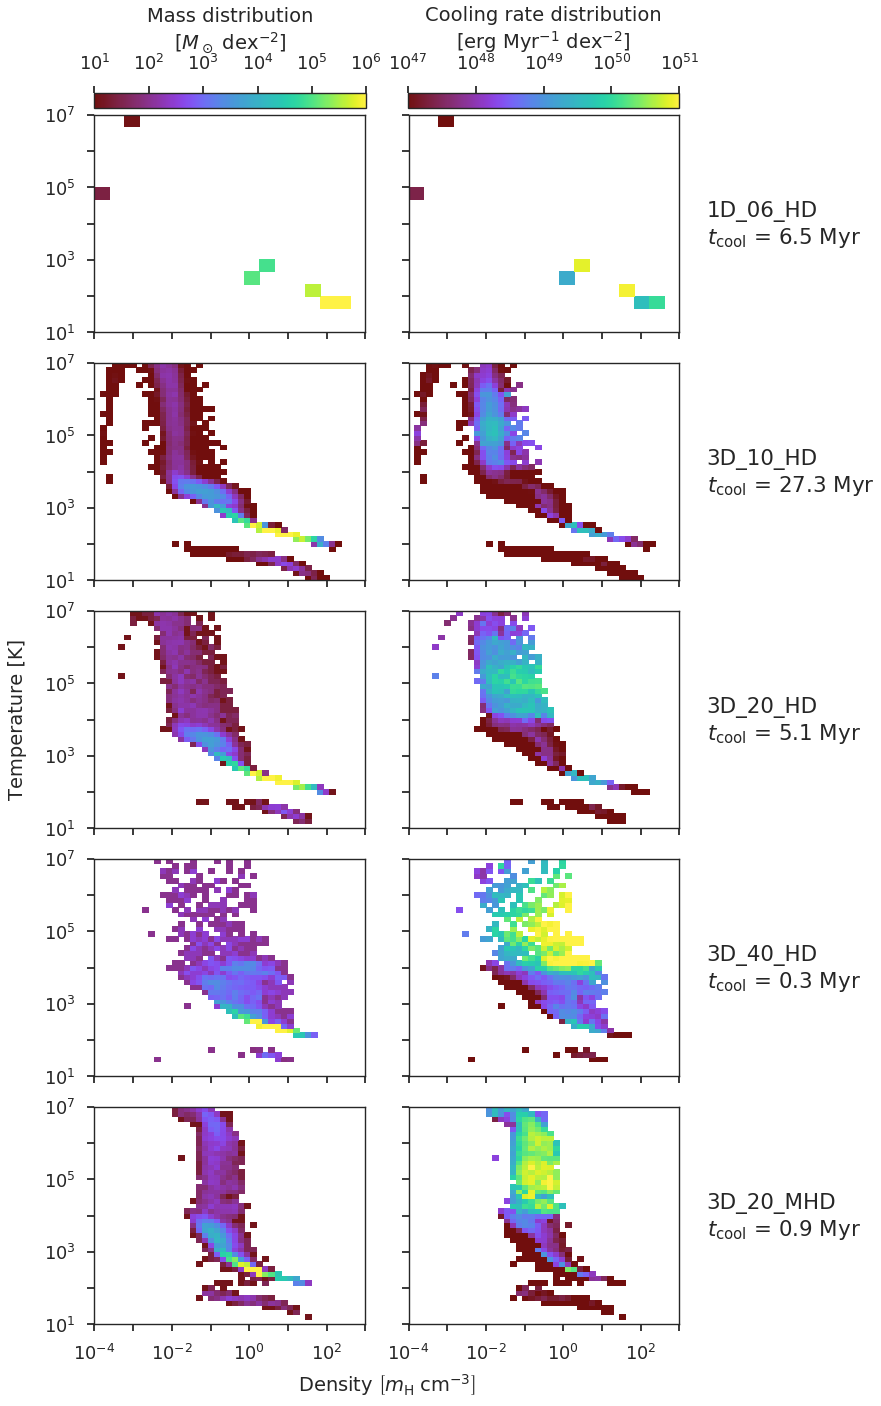

In [35]:
snapshot_number=39

plot_phase_diagram_combined_vertical(["1D"] + run_names_profile, snapshot_number, save=False)

total cooling rate: 2.2e+50 erg/Myr for 1D
cooling bounds (per dex): 9.15e+46, 8.42e+50


/pfs/home/egentry/data/gizmo-clustered-SNe/scripts/visualize_helpers.py:613: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_1D_snapshot["grackle_Temperature"] = grackle_temperature_1D(df_1D_snapshot)
/pfs/home/egentry/data/gizmo-clustered-SNe/scripts/visualize_helpers.py:614: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_1D_snapshot["grackle_cooling_rate"] = grackle_cooling_rate_1D(df_1D_snapshot)


total cooling rate: 2.6e+49 erg/Myr for cluster_cooling_400-small_steps
cooling bounds (per dex): 4.10e+44, 4.38e+49
total cooling rate: 1.4e+50 erg/Myr for cluster_cooling_200-small_steps
cooling bounds (per dex): 1.20e+44, 1.85e+50
total cooling rate: 1.9e+51 erg/Myr for cluster_cooling_100-small_steps
cooling bounds (per dex): 4.17e+45, 5.61e+51
saving:  publication_plots/phase_diagrams-snapshot_039


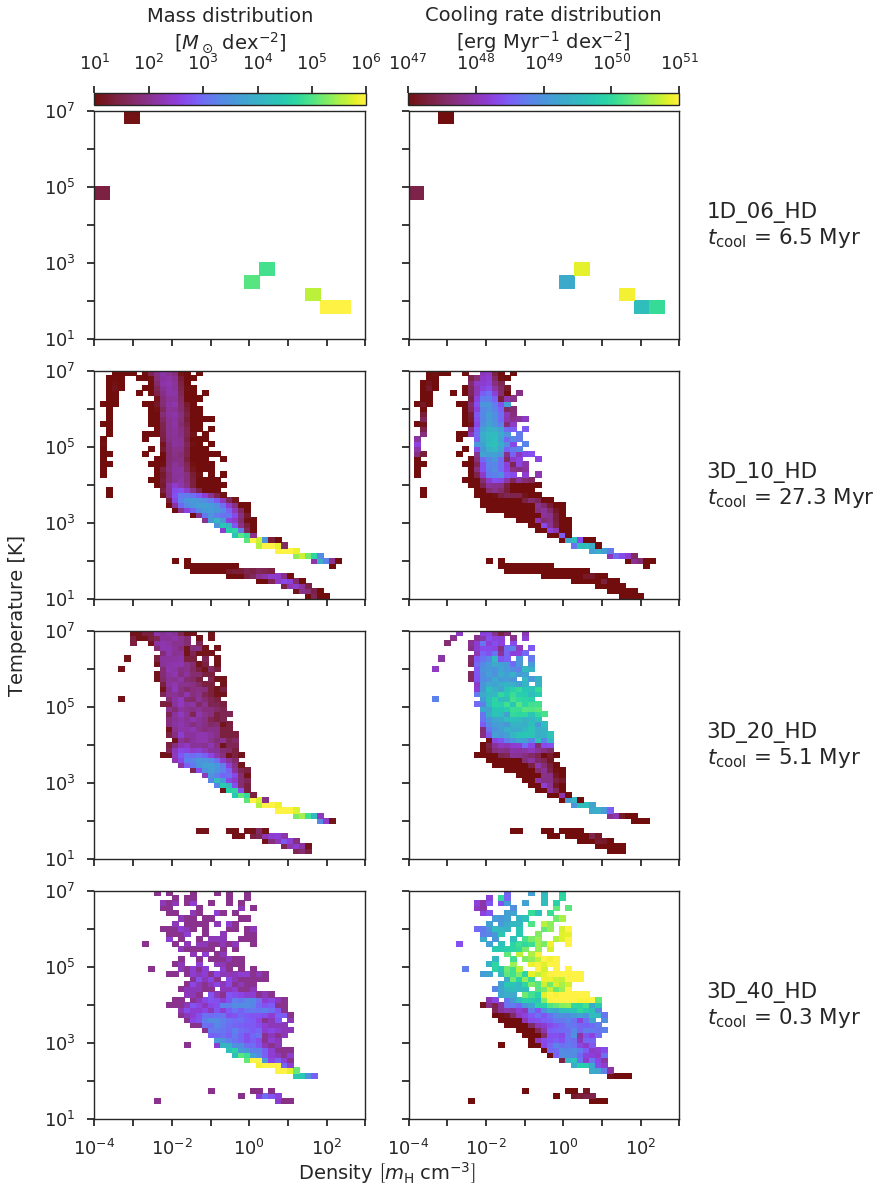

In [36]:
## Exclude the MHD simulation at this later snapshot.

snapshot_number=39

plot_phase_diagram_combined_vertical(["1D"] + run_names_profile[:-1], snapshot_number, save=True,
#                                      right_pad = .23,
#                                      colorbar_width=.302,
                                     )

total cooling rate: 6.8e+50 erg/Myr for cluster_cooling_200-small_steps-early
cooling bounds (per dex): 1.24e+45, 1.26e+51
total cooling rate: 5.3e+50 erg/Myr for cluster_cooling_mhd_large_200-small_steps-early
cooling bounds (per dex): 1.17e+45, 1.78e+51
saving:  publication_plots/phase_diagrams-snapshot_015


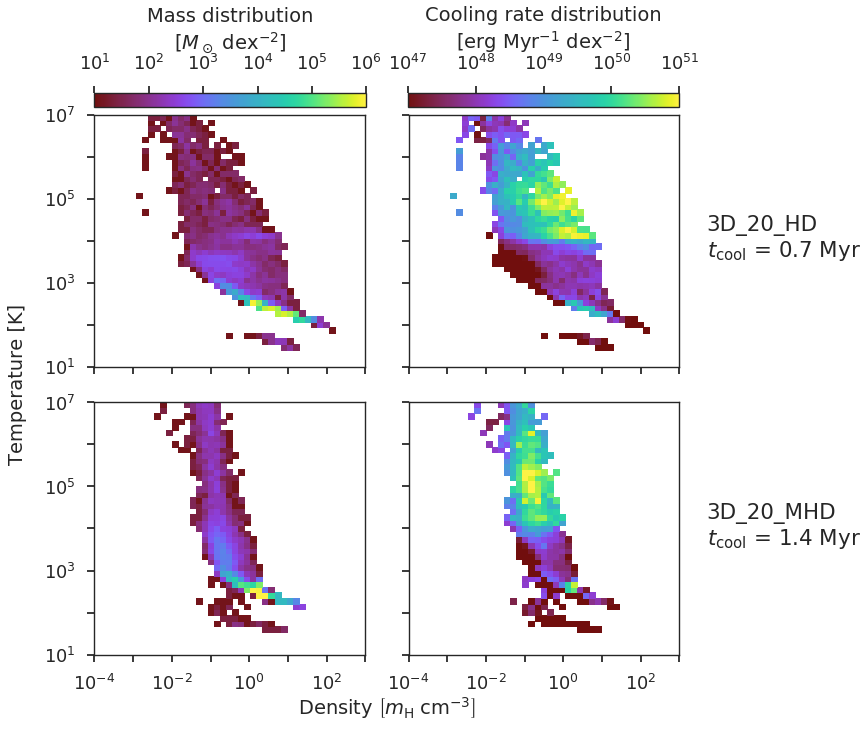

In [87]:
snapshot_number=15

plot_phase_diagram_combined_vertical(run_names_profile_early,
                                     snapshot_number, 
                                     save=True,
                                     top_pad=0.15,
                                     bottom_pad=0.1,
                                     colorbar_width=.302,
                                     colorbar_height=.02,
                                     new_bottom=0.05,
                                     new_left=0.03,
                                    )

### Get mass + cooling fractions of phases

In [107]:
snapshot_number = 39

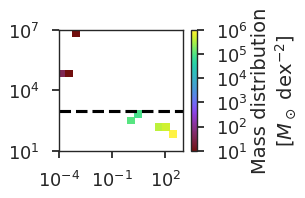

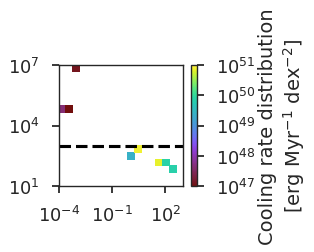

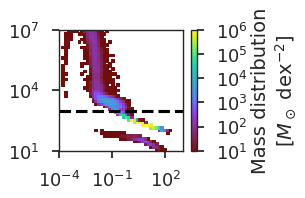

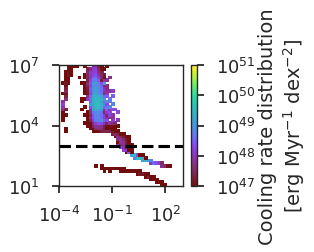

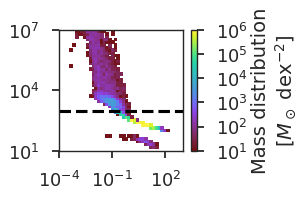

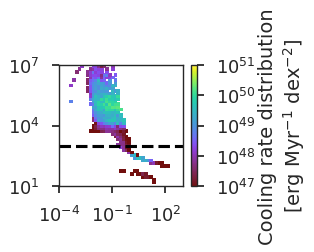

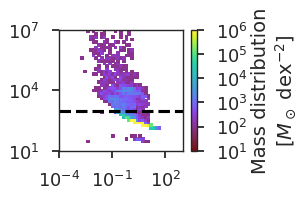

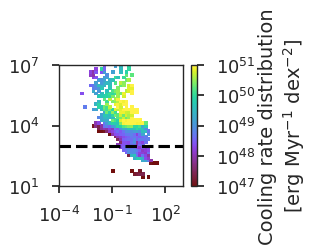

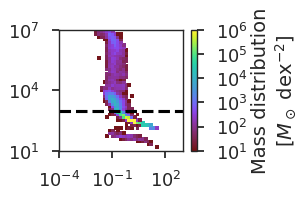

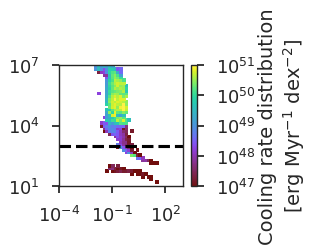

In [108]:
mpl.rcParams['figure.figsize'] = np.array((5,4))*.5

# elements in this list should be formatted as tuples of:
# (run_name, weight_field, phase_name, <quantity>)
# then I'll use this list to create a dataframe, so you don't
# have to remember the order
summed_quantities_list = list()

for run_name in ["1D"] + run_names_profile:
    for weight_field in weight_fields:
        pickle_filename = get_pickle_filename_profile(run_name, 
                                                      snapshot_number, 
                                                      weight_field,
                                                      pickle_save_dir)    
        with open(pickle_filename, "rb") as pickle_file:
            x, y, Z = pickle.load(pickle_file)

        cold = (y[:-1] < 1e3)
        hot = ~cold
        
        summed_quantities_list += [(run_name, weight_field, "cold", Z[:, cold].sum())]
        summed_quantities_list += [(run_name, weight_field, "hot",  Z[:, hot ].sum())]

#         Z[:, cold] = 0

        # `rebin_factor` must be positive integer factor of x.size *and* y.size
        rebin_factor = rebin_factors[run_name]
        x = x[::rebin_factor]
        y = y[::rebin_factor]
        Z = rebin(Z, rebin_factor)

        Z *= Z.size / np.log10(x.max() / x.min()) / np.log10(y.max() / y.min())

        plt.figure()
        plt.pcolor(x, y, Z.T,
            norm=LogNorm(
                *z_bounds_from_weight_field[weight_field]
            ),
            edgecolors="none",
            cmap=plt.get_cmap("arbre"), 
                  )

        plt.colorbar(label=z_label_from_weight_field[weight_field],
                     ticks=LogLocator())

        plt.xscale("log")
        plt.yscale("log")
        
        plt.axhline(1e3, linestyle="dashed", color="black")

        cold_cooling_rate = Z.sum()


In [109]:
columns = ["run_name", "weight_field", "phase_name", "quantity"]
df_summed_phases = pd.DataFrame(data={
    col : [elem[i] for elem in summed_quantities_list]
    for i, col in enumerate(columns)
})

df_summed_phases = df_summed_phases[columns] # fix order

df_summed_phases

run_name   weight_field phase_name  \
0                                          1D  particle_mass       cold   
1                                          1D  particle_mass        hot   
2                                          1D   cooling_rate       cold   
3                                          1D   cooling_rate        hot   
4             cluster_cooling_400-small_steps  particle_mass       cold   
5             cluster_cooling_400-small_steps  particle_mass        hot   
6             cluster_cooling_400-small_steps   cooling_rate       cold   
7             cluster_cooling_400-small_steps   cooling_rate        hot   
8             cluster_cooling_200-small_steps  particle_mass       cold   
9             cluster_cooling_200-small_steps  particle_mass        hot   
10            cluster_cooling_200-small_steps   cooling_rate       cold   
11            cluster_cooling_200-small_steps   cooling_rate        hot   
12            cluster_cooling_100-small_steps  particle_mass       cold   
13            cluster_cooling_100-small_steps  particle_mass        hot   
14            cluster_cooling_100-small_steps   cooling_rate       cold   
15            cluster_cooling_100-small_steps   cooling_rate        hot   
16  cluster_cooling_mhd_large_200-small_steps  particle_mass       cold   
17  cluster_cooling_mhd_large_200-small_steps  particle_mass        hot   
18  cluster_cooling_mhd_large_200-small_steps   cooling_rate       cold   
19  cluster_cooling_mhd_large_200-small_steps   cooling_rate        hot   

        quantity  
0   6.739159e+05  
1   5.852985e+00  
2   2.262673e+50  
3   7.553985e+46  
4   2.713644e+05  
5   2.306059e+03  
6   4.933505e+48  
7   2.135460e+49  
8   2.756112e+05  
9   2.268034e+03  
10  4.402696e+48  
11  1.343837e+50  
12  3.747499e+05  
13  3.148050e+03  
14  8.985007e+48  
15  1.930384e+51  
16  6.924582e+05  
17  3.659295e+03  
18  5.177133e+48  
19  8.694328e+50

In [110]:
for weight_field in df_summed_phases.weight_field.drop_duplicates():
    print("================ % of {} in cold phase ================".format(weight_field))
    for run_name in df_summed_phases.run_name.drop_duplicates():
        df_tmp = df_summed_phases.set_index("run_name").loc[run_name]
        df_tmp = df_tmp.set_index("weight_field").loc[weight_field]
        df_tmp = df_tmp.set_index("phase_name")
        
        percentage_in_cold = df_tmp.loc["cold"] / df_tmp.sum() * 100
        percentage_in_cold = percentage_in_cold.quantity

        print("{:<43} : {:>6.2f}".format(
            run_name,
            percentage_in_cold
            )
        )
    
    print()
    print()

================ % of particle_mass in cold phase ================
1D                                          : 100.00
cluster_cooling_400-small_steps             :  99.16
cluster_cooling_200-small_steps             :  99.18
cluster_cooling_100-small_steps             :  99.17
cluster_cooling_mhd_large_200-small_steps   :  99.47


================ % of cooling_rate in cold phase ================
1D                                          :  99.97
cluster_cooling_400-small_steps             :  18.77
cluster_cooling_200-small_steps             :   3.17
cluster_cooling_100-small_steps             :   0.46
cluster_cooling_mhd_large_200-small_steps   :   0.59




In [111]:
# same info as above, just repackaged for the hot phase
# you could have done the math in your head pretty easily, but whatever

for weight_field in df_summed_phases.weight_field.drop_duplicates():
    print("================ % of {} in hot phase ================".format(weight_field))
    for run_name in df_summed_phases.run_name.drop_duplicates():
        df_tmp = df_summed_phases.set_index("run_name").loc[run_name]
        df_tmp = df_tmp.set_index("weight_field").loc[weight_field]
        df_tmp = df_tmp.set_index("phase_name")
        
        percentage_in_hot = df_tmp.loc["hot"] / df_tmp.sum() * 100
        percentage_in_hot = percentage_in_hot.quantity

        print("{:<43} : {:>6.2f}".format(
            run_name,
            percentage_in_hot
            )
        )
    
    print()
    print()

================ % of particle_mass in hot phase ================
1D                                          :   0.00
cluster_cooling_400-small_steps             :   0.84
cluster_cooling_200-small_steps             :   0.82
cluster_cooling_100-small_steps             :   0.83
cluster_cooling_mhd_large_200-small_steps   :   0.53


================ % of cooling_rate in hot phase ================
1D                                          :   0.03
cluster_cooling_400-small_steps             :  81.23
cluster_cooling_200-small_steps             :  96.83
cluster_cooling_100-small_steps             :  99.54
cluster_cooling_mhd_large_200-small_steps   :  99.41




**Wow!** Those phase breakdowns are pretty crazy!

### Get mass-weighted median density of peak-cooling material

---------- 1D -------------
median density = 1.482897e-04
mean density = 1.525164e-04

---------- cluster_cooling_400-small_steps -------------
median density = 1.304835e-02
mean density = 1.530772e-02

---------- cluster_cooling_200-small_steps -------------
median density = 2.576980e-02
mean density = 4.624901e-02

---------- cluster_cooling_100-small_steps -------------
median density = 1.387466e-01
mean density = 3.191483e-01

---------- cluster_cooling_mhd_large_200-small_steps -------------
median density = 1.387466e-01
mean density = 1.972914e-01



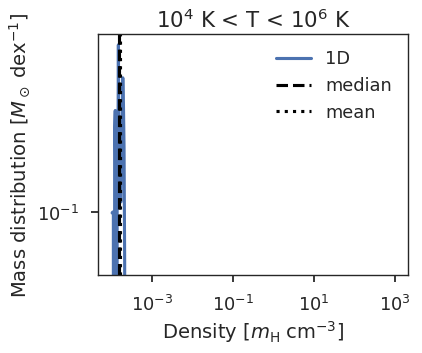

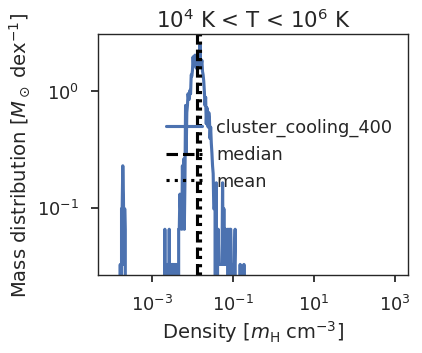

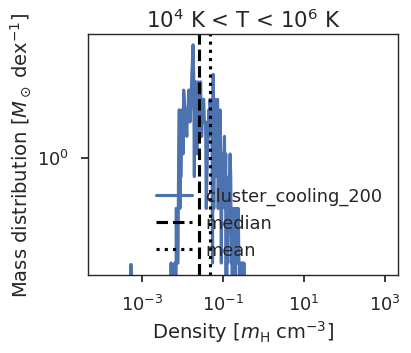

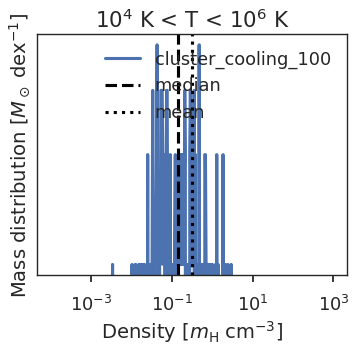

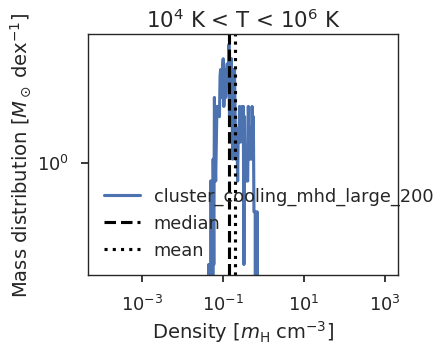

In [60]:
mpl.rcParams['figure.figsize'] = np.array((5,4))

snapshot_number = 39
summed_quantities_list = list()

for run_name in ["1D"] + run_names_profile:
    weight_field = "particle_mass"
    pickle_filename = get_pickle_filename_profile(run_name, 
                                                  snapshot_number, 
                                                  weight_field,
                                                  pickle_save_dir)
    with open(pickle_filename, "rb") as pickle_file:
        x, y, Z = pickle.load(pickle_file)

    cold = (y[:-1] < 1e3)
    # define "hot" as 10^5 K +/- 0.5 dex (~peak of cooling curve)
    hot = (y[:-1] > 3e4) & (y[:-1] < 3e5)
#     hot = (y[:-1] > 10**(4.5)) & (y[:-1] < 10**(5.5))
#     hot = (y[:-1] > 10**(4)) & (y[:-1] < 10**(6))

    y_hot = (y[:-1])[hot]
    x_hot = x[:-1]

    summed_quantities_list += [(run_name, weight_field, "cold", Z[:, cold].sum())]
    summed_quantities_list += [(run_name, weight_field, "hot",  Z[:, hot ].sum())]

    # collapse into a 1D histogram, marginalizing out Temperature
    Z_flat = Z[:,hot].sum(axis=1)

    plt.figure()
    plt.plot(x_hot, Z_flat, label=run_name.replace("-small_steps", ""))
    plt.xscale("log")
    plt.yscale("log")
    plt.minorticks_off()
    plt.xlabel("Density $ [ m_\mathrm{H} \; \mathrm{cm}^{-3} ] $")
    plt.ylabel("Mass distribution $ [M_\odot \; \mathrm{dex}^{-1}]$")
    plt.title("$10^4$ K < T < $10^6$ K")

    cdf = np.cumsum(Z_flat) / Z_flat.sum()
    i_median = np.argmin(np.abs(cdf - 0.5))
    x_mean = (Z_flat * x_hot).sum() / np.sum(Z_flat)

    print("---------- {} -------------".format(run_name))
    print("median density = {:e}".format(x_hot[i_median]))
    print("mean density = {:e}".format(x_mean))
    print()

    plt.axvline(x_hot[i_median], linestyle="dashed", color="black", label="median")
    plt.axvline(x_mean, linestyle="dotted", color="black", label="mean")
    
    
    plt.legend()


### Get mass-weighted median density of peak-cooling material (again, at earlier time)

---------- cluster_cooling_200-small_steps-early -------------
median density = 1.720107e-01
mean density = 3.218202e-01

---------- cluster_cooling_mhd_large_200-small_steps-early -------------
median density = 1.387466e-01
mean density = 1.546158e-01



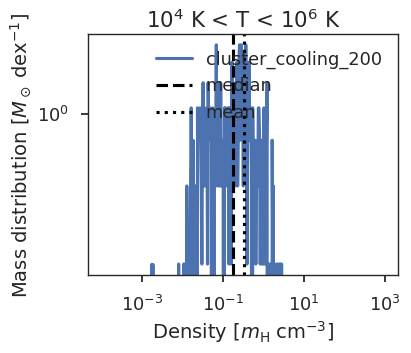

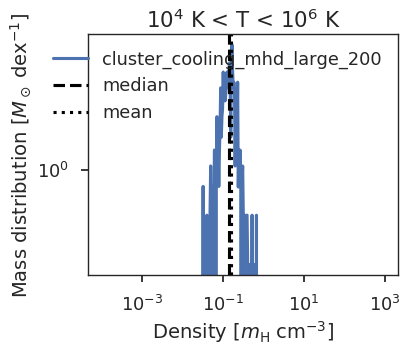

In [61]:
mpl.rcParams['figure.figsize'] = np.array((5,4))

snapshot_number = 15
summed_quantities_list = list()

for run_name in run_names_profile_early:
    weight_field = "particle_mass"
    pickle_filename = get_pickle_filename_profile(run_name, 
                                                  snapshot_number, 
                                                  weight_field,
                                                  pickle_save_dir)
    with open(pickle_filename, "rb") as pickle_file:
        x, y, Z = pickle.load(pickle_file)

    cold = (y[:-1] < 1e3)
    # define "hot" as 10^5 K +/- 0.5 dex (~peak of cooling curve)
    hot = (y[:-1] > 3e4) & (y[:-1] < 3e5)
#     hot = (y[:-1] > 10**(4.5)) & (y[:-1] < 10**(5.5))
#     hot = (y[:-1] > 10**(4)) & (y[:-1] < 10**(6))

    y_hot = (y[:-1])[hot]
    x_hot = x[:-1]

    summed_quantities_list += [(run_name, weight_field, "cold", Z[:, cold].sum())]
    summed_quantities_list += [(run_name, weight_field, "hot",  Z[:, hot ].sum())]

    # collapse into a 1D histogram, marginalizing out Temperature
    Z_flat = Z[:,hot].sum(axis=1)

    plt.figure()
    plt.plot(x_hot, Z_flat, label=run_name.replace("-small_steps-early", ""))
    plt.xscale("log")
    plt.yscale("log")
    plt.minorticks_off()
    plt.xlabel("Density $ [ m_\mathrm{H} \; \mathrm{cm}^{-3} ] $")
    plt.ylabel("Mass distribution $ [M_\odot \; \mathrm{dex}^{-1}]$")
    plt.title("$10^4$ K < T < $10^6$ K")

    cdf = np.cumsum(Z_flat) / Z_flat.sum()
    i_median = np.argmin(np.abs(cdf - 0.5))
    x_mean = (Z_flat * x_hot).sum() / np.sum(Z_flat)

    print("---------- {} -------------".format(run_name))
    print("median density = {:e}".format(x_hot[i_median]))
    print("mean density = {:e}".format(x_mean))
    print()

    plt.axvline(x_hot[i_median], linestyle="dashed", color="black", label="median")
    plt.axvline(x_mean, linestyle="dotted", color="black", label="mean")
    
    
    plt.legend()


# Figure 7 - MHD Slice (at early time!)

**Note:** these slice plots use a currently-beta version of `yt` to do a better job with plotting particle based data.

See the note above for Figure 4

In [17]:
run_name = "cluster_cooling_mhd_large_200-small_steps-early"
inputs_dir, outputs_dir = get_dirs(run_name)

In [18]:
ts = load_snapshots(outputs_dir)
snapshot_filenames = get_snapshot_filenames(outputs_dir)

snapshot_number_to_index_map = {snapshot_filename_to_number(filename) : i
                                for i,filename in enumerate(snapshot_filenames) }

uncompressed_snapshot_numbers = sorted(list(snapshot_number_to_index_map.keys()))


In [19]:
num_lines = 12
df_lines = pd.read_csv("publication_plots/field_lines/field_lines_snapshot_015.{}.csv".format(
    num_lines))
df_lines.head()


In [20]:
run_name = "cluster_cooling_mhd_large_200-small_steps-early"
inputs_dir, outputs_dir = get_dirs(run_name)


ts = load_snapshots(outputs_dir)
snapshot_filenames = get_snapshot_filenames(outputs_dir)

snapshot_number_to_index_map = {snapshot_filename_to_number(filename) : i
                                for i,filename in enumerate(snapshot_filenames) }

uncompressed_snapshot_numbers = sorted(list(snapshot_number_to_index_map.keys()))


snapshot_number = 15
ds = load_ds_from_ts(ts, snapshot_number_to_index_map[snapshot_number])
center = ds.domain_center.value[0]

radius = 125
radius *= 1.1 * np.sqrt(3) # to get the corners + provide enough margin
region = ds.sphere([center,center,center], (radius, "pc"))

coords = region["all", "Coordinates"].value - center
x, y, z = coords.T
scales = region["all", "smoothing_length"].value
temps = region["all", "temperature"].value
densities = region["all", "density"].value / m_proton

from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=32, n_jobs=4)
knn = knn.fit(coords)


yt : [INFO     ] 2018-10-01 20:18:30,293 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2018-10-01 20:18:30,331 Parameters: current_time              = 2.5599999999834107
yt : [INFO     ] 2018-10-01 20:18:30,332 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2018-10-01 20:18:30,334 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2018-10-01 20:18:30,336 Parameters: domain_right_edge         = [1200. 1200. 1200.]
yt : [INFO     ] 2018-10-01 20:18:30,338 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2018-10-01 20:18:39,089 Allocating for 2.160e+08 particles
Initializing refined index: 100%|██████████| 824/824 [01:17<00:00, 11.05it/s]


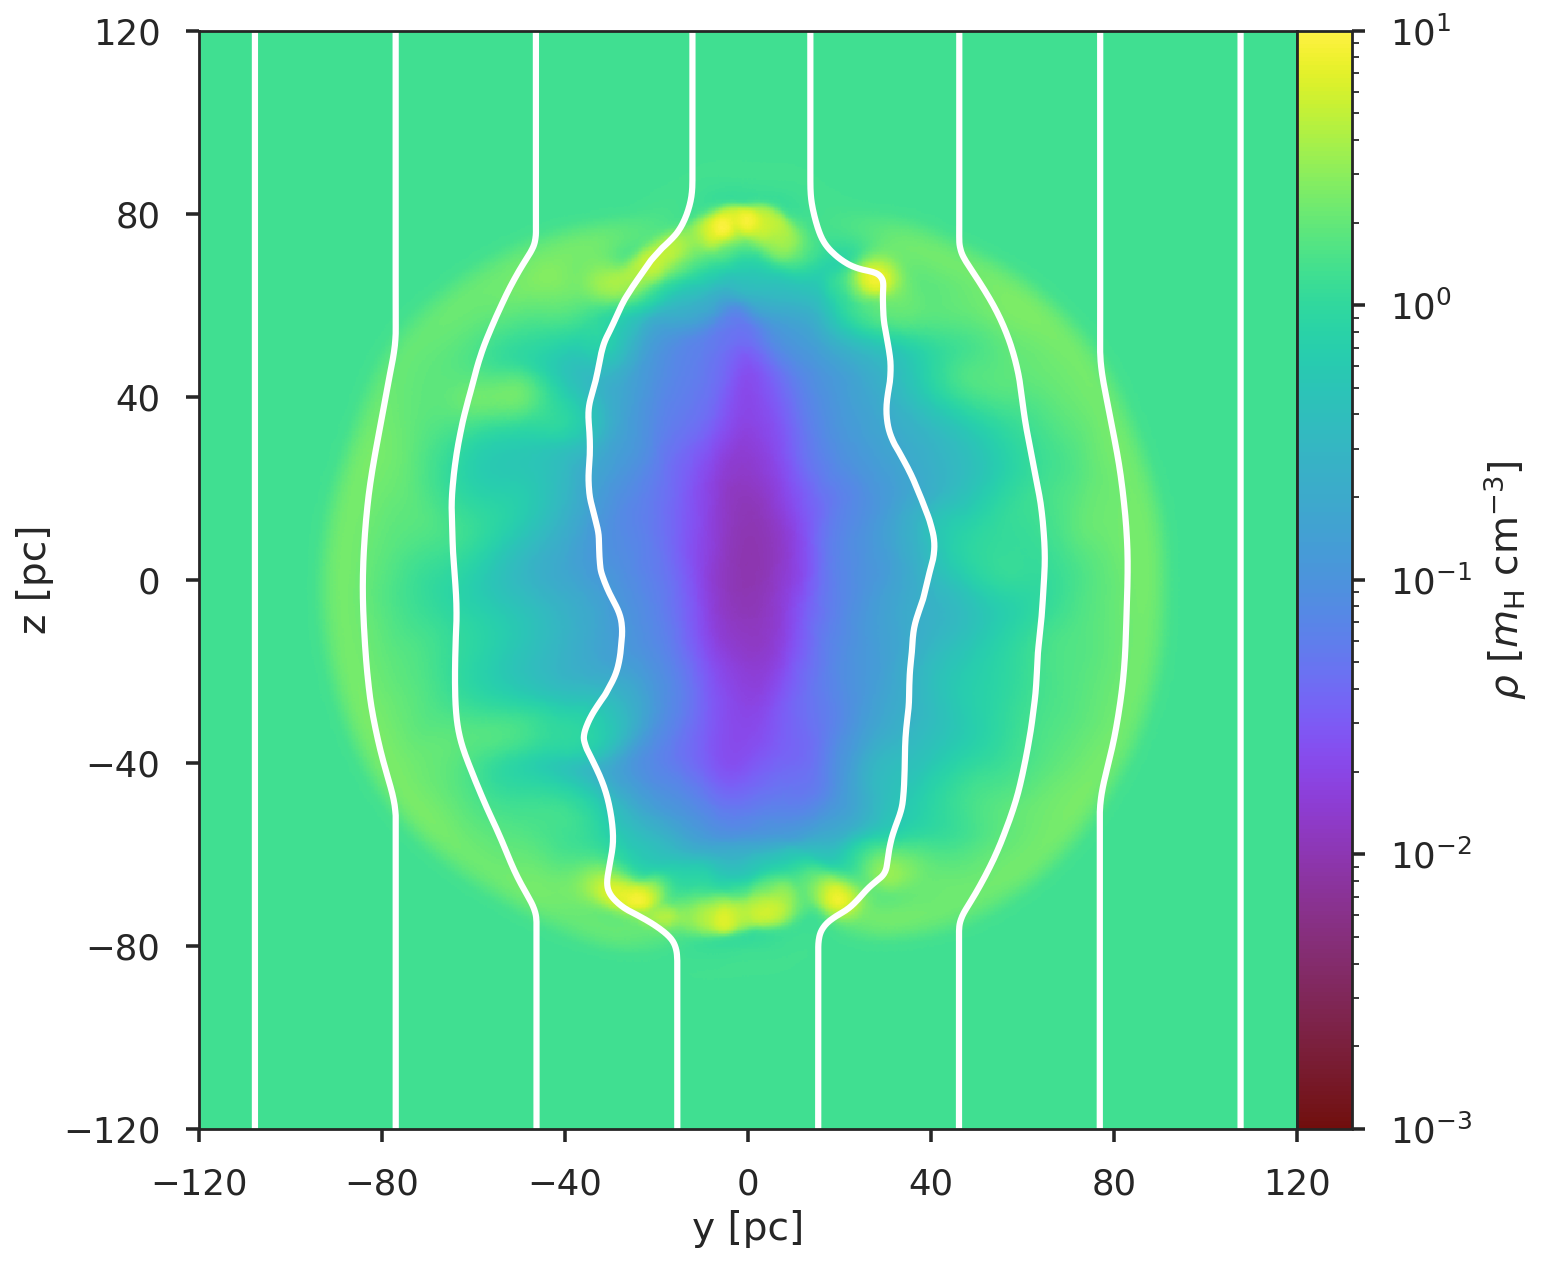

In [31]:
y_out = np.linspace(-120, 120, num=800)
z_out = np.linspace(-120, 120, num=800)

YY, ZZ = np.meshgrid(y_out, z_out, indexing="xy")
XX = np.full_like(YY, 0)

coords_test = np.array([XX.flatten(), YY.flatten(), ZZ.flatten()]).T

distances, indices = knn.kneighbors(X=coords_test)
densities_interp = np.array([rbf(distances[i], indices[i], 
                                 densities, scales,
                                 knn)
                         for i in range(distances.shape[0])
])
densities_interp = densities_interp.reshape(y_out.size, z_out.size)


# plot: the color image
with mpl.rc_context(rc={"figure.dpi":160, "savefig.dpi":160,
                        'figure.figsize': np.array((5,4))*2}):

    ax = plt.subplot(111, aspect="equal", adjustable='box')

    min_value = 1e1
    max_value = 1e-3
    pcm = ax.pcolor(YY, ZZ, densities_interp, 
#                     cmap=plt.cm.viridis, 
                         cmap=plt.get_cmap("arbre"),
                    norm=LogNorm(vmin=min_value, vmax=max_value),
                    edgecolors="none")

    pcm.set_rasterized(True)

    cbr = plt.colorbar(pcm, 
                       label=r"$\rho$ [$m_\mathrm{H}$ cm$^{-3}$]",
                       pad=0,
                )

    tick_step = 40
    ticks = np.arange(min(y_out), max(y_out) + tick_step, tick_step)
    plt.gca().set_xticks(ticks)
    plt.gca().set_yticks(ticks)

    plt.xlim(min(ticks), max(ticks))
    plt.ylim(min(ticks), max(ticks))

    plt.xlabel("y [pc]")
    plt.ylabel("z [pc]")

    filename = "publication_plots/field_lines/field_lines_snapshot_{:03}.{}.csv".format(snapshot_number, num_lines)
    df_lines = pd.read_csv(filename)
    MHD.plot_field_lines(df_lines, plt.gca(),
                         replace_nans=True)

    plt.tight_layout()
    plot_filename = os.path.join(publication_plots_dir, "density_slice-snapshot_{:03}-200_MHD_{}".format(snapshot_number, num_lines))
#     plt.savefig(plot_filename + ".eps", dpi=200)
    plt.savefig(plot_filename + ".pdf")
    plt.savefig(plot_filename + ".png")
    




In [32]:
run_name = "cluster_cooling_200-small_steps-early"
inputs_dir, outputs_dir = get_dirs(run_name)


ts = load_snapshots(outputs_dir)
snapshot_filenames = get_snapshot_filenames(outputs_dir)

snapshot_number_to_index_map = {snapshot_filename_to_number(filename) : i
                                for i,filename in enumerate(snapshot_filenames) }

uncompressed_snapshot_numbers = sorted(list(snapshot_number_to_index_map.keys()))


snapshot_number = 15
ds = load_ds_from_ts(ts, snapshot_number_to_index_map[snapshot_number])
center = ds.domain_center.value[0]

radius = 125
radius *= 1.1 * np.sqrt(3) # to get the corners + provide enough margin
region = ds.sphere([center,center,center], (radius, "pc"))

coords = region["all", "Coordinates"].value - center
x, y, z = coords.T
scales = region["all", "smoothing_length"].value
temps = region["all", "temperature"].value
densities = region["all", "density"].value / m_proton

from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=32, n_jobs=4)
knn = knn.fit(coords)


yt : [INFO     ] 2018-10-01 20:42:05,264 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2018-10-01 20:42:05,304 Parameters: current_time              = 2.5599999999691407
yt : [INFO     ] 2018-10-01 20:42:05,305 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2018-10-01 20:42:05,307 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2018-10-01 20:42:05,309 Parameters: domain_right_edge         = [600. 600. 600.]
yt : [INFO     ] 2018-10-01 20:42:05,310 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2018-10-01 20:42:06,768 Allocating for 2.700e+07 particles
Initializing refined index: 100%|██████████| 103/103 [00:05<00:00, 19.32it/s]


In [44]:
np.median(scales)

3.940150553186772

(array([4.9000e+01, 1.3750e+03, 1.1483e+04, 3.3208e+04, 5.0622e+04,
        5.1848e+04, 3.9896e+04, 2.7186e+04, 2.0248e+04, 2.2653e+04]),
 array([0.82730649, 1.13193543, 1.43656436, 1.7411933 , 2.04582223,
        2.35045117, 2.6550801 , 2.95970903, 3.26433797, 3.5689669 ,
        3.87359584]),
 <a list of 10 Patch objects>)

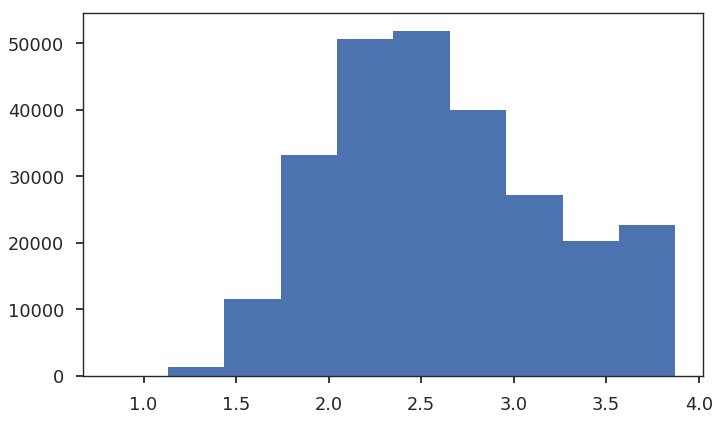

In [43]:
mask = densities > 1.4
plt.hist(scales[mask])

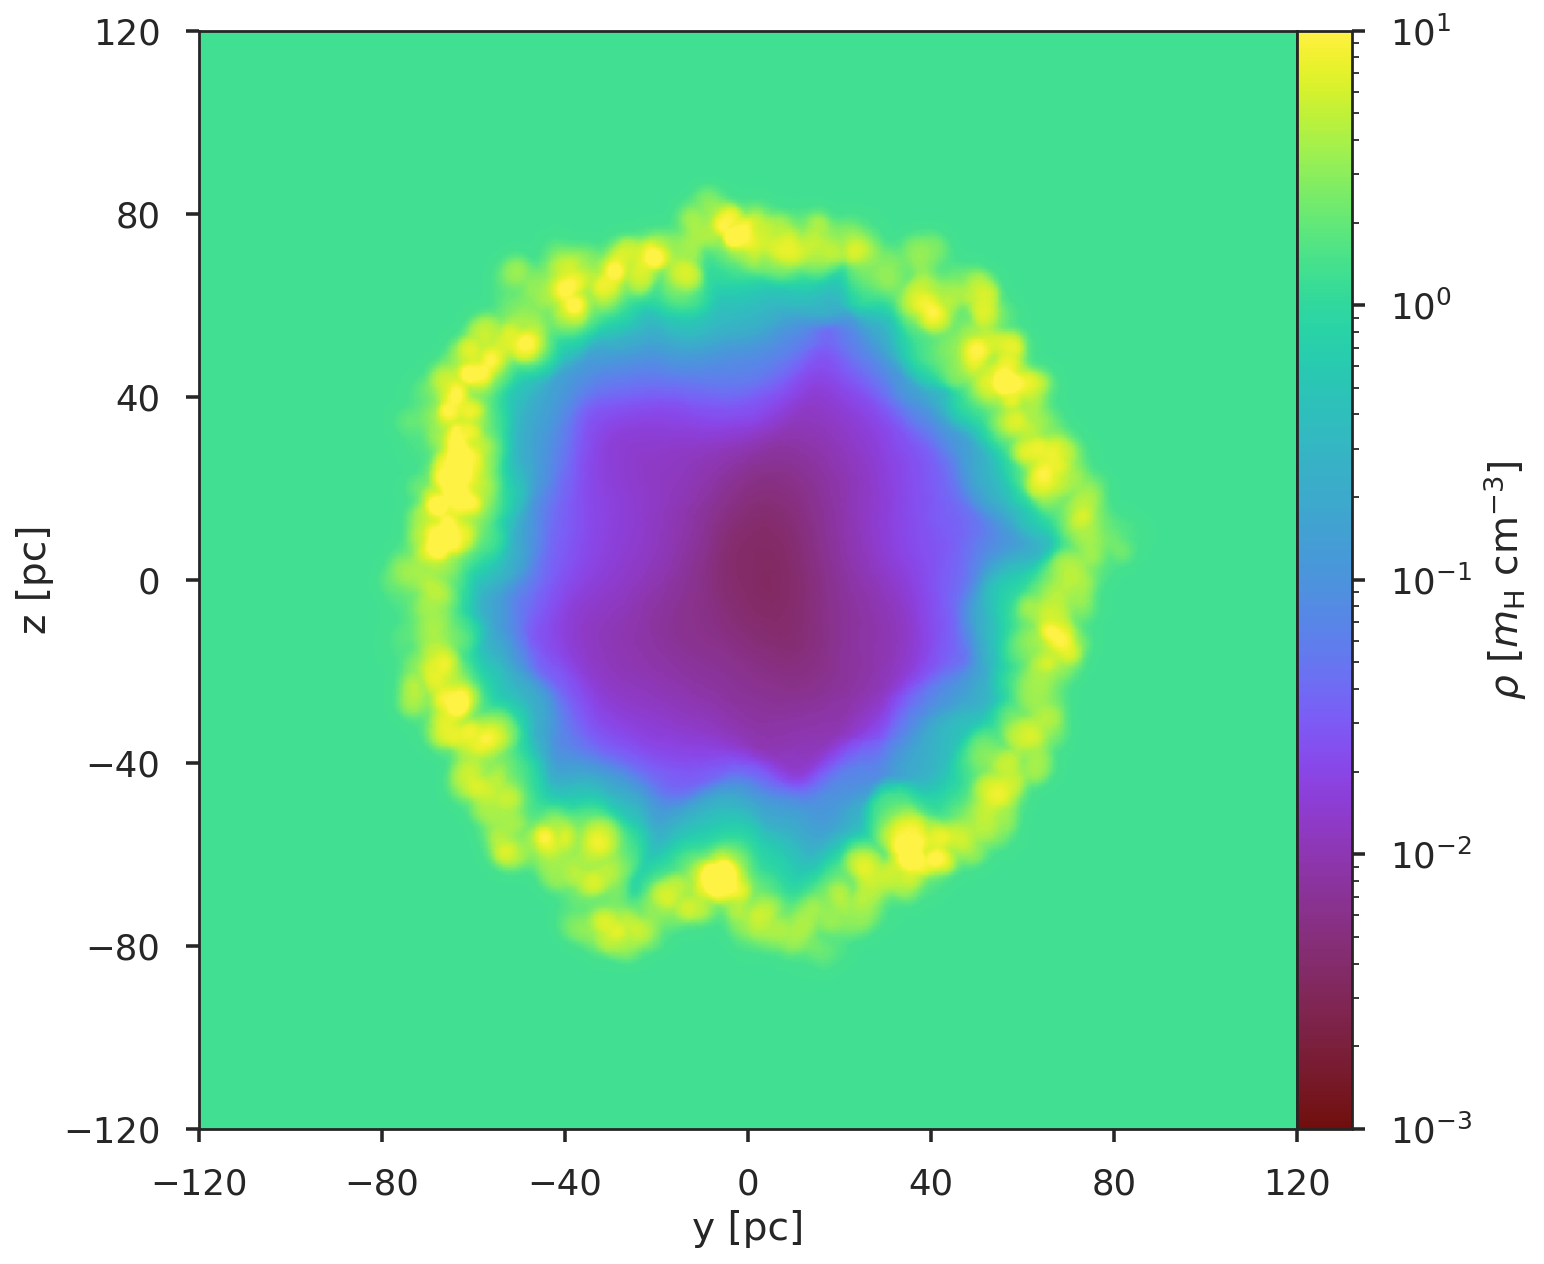

In [33]:
y_out = np.linspace(-120, 120, num=800)
z_out = np.linspace(-120, 120, num=800)

YY, ZZ = np.meshgrid(y_out, z_out, indexing="xy")
XX = np.full_like(YY, 0)

coords_test = np.array([XX.flatten(), YY.flatten(), ZZ.flatten()]).T

distances, indices = knn.kneighbors(X=coords_test)
densities_interp = np.array([rbf(distances[i], indices[i], 
                                 densities, scales,
                                 knn)
                         for i in range(distances.shape[0])
])
densities_interp = densities_interp.reshape(y_out.size, z_out.size)


# plot: the color image
with mpl.rc_context(rc={"figure.dpi":160, "savefig.dpi":160,
                        'figure.figsize': np.array((5,4))*2}):

    ax = plt.subplot(111, aspect="equal", adjustable='box')

    min_value = 1e1
    max_value = 1e-3
    pcm = ax.pcolor(YY, ZZ, densities_interp, 
#                     cmap=plt.cm.viridis, 
                         cmap=plt.get_cmap("arbre"),
                    norm=LogNorm(vmin=min_value, vmax=max_value),
                    edgecolors="none")

    pcm.set_rasterized(True)

    cbr = plt.colorbar(pcm, 
                       label=r"$\rho$ [$m_\mathrm{H}$ cm$^{-3}$]",
                       pad=0,
                )

    tick_step = 40
    ticks = np.arange(min(y_out), max(y_out) + tick_step, tick_step)
    plt.gca().set_xticks(ticks)
    plt.gca().set_yticks(ticks)

    plt.xlim(min(ticks), max(ticks))
    plt.ylim(min(ticks), max(ticks))

    plt.xlabel("y [pc]")
    plt.ylabel("z [pc]")

    plt.tight_layout()
    plot_filename = os.path.join(publication_plots_dir, "density_slice-snapshot_{:03}-200_HD".format(snapshot_number))
#     plt.savefig(plot_filename + ".eps", dpi=200)
    plt.savefig(plot_filename + ".pdf")
    plt.savefig(plot_filename + ".png")
    




yt : [INFO     ] 2018-01-02 15:20:33,349 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2018-01-02 15:20:33,394 Parameters: current_time              = 2.55999999998
yt : [INFO     ] 2018-01-02 15:20:33,397 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2018-01-02 15:20:33,399 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2018-01-02 15:20:33,403 Parameters: domain_right_edge         = [ 1200.  1200.  1200.]
yt : [INFO     ] 2018-01-02 15:20:33,406 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2018-01-02 15:20:33,415 Allocating for 2.160e+08 particles (index particle type 'all')
yt : [INFO     ] 2018-01-02 15:21:26,663 Identified 1.890e+07 octs


publication_plots/field_lines/field_lines_snapshot_015.12.csv


/pfs/home/egentry/data/gizmo-clustered-SNe/scripts/MHD.py:38: RuntimeWarning: invalid value encountered in greater
  By_Bz[By_Bz > max_value] = np.nan


(400, 400, 3)


/pfs/home/egentry/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


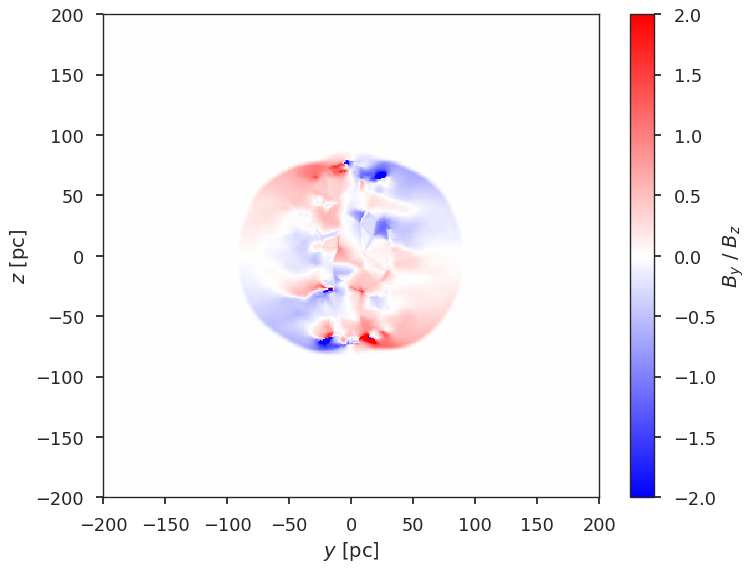

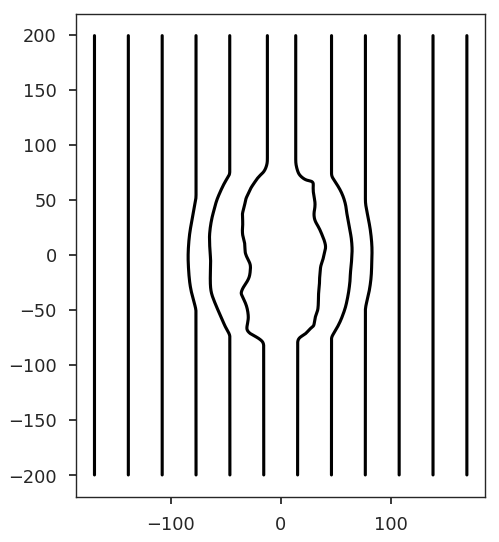

In [185]:
snapshot_number = 15
ds = load_ds_from_ts(ts, snapshot_number_to_index_map[snapshot_number])

num_lines = 12

field_lines_filename = os.path.join(publication_plots_dir,
                                    "field_lines",
                                    "field_lines_snapshot_{:03}.{}.csv".format(snapshot_number, num_lines))
print(field_lines_filename)
df_lines = MHD.calculate_magnetic_field_lines(ds, publication_plots_dir,
                                              num_lines=num_lines, 
                                              box_size_for_lines=400,
                                              filename=field_lines_filename)

yt : [INFO     ] 2018-02-16 14:13:30,824 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2018-02-16 14:13:30,878 Parameters: current_time              = 2.55999999998
yt : [INFO     ] 2018-02-16 14:13:30,879 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2018-02-16 14:13:30,882 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2018-02-16 14:13:30,885 Parameters: domain_right_edge         = [ 1200.  1200.  1200.]
yt : [INFO     ] 2018-02-16 14:13:30,887 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2018-02-16 14:13:39,448 Allocating for 2.160e+08 particles
Initializing refined index: 100%|██████████| 824/824 [01:27<00:00,  9.45it/s]
yt : [INFO     ] 2018-02-16 14:19:35,657 xlim = 400.000000 800.000000
yt : [INFO     ] 2018-02-16 14:19:35,669 ylim = 400.000000 800.000000
yt : [INFO     ] 2018-02-16 14:19:35,673 xlim = 400.000000 800.000000
yt : [INFO     ] 2018-02-16 14:19:35,675 ylim = 400.000000 800.000000
yt : 


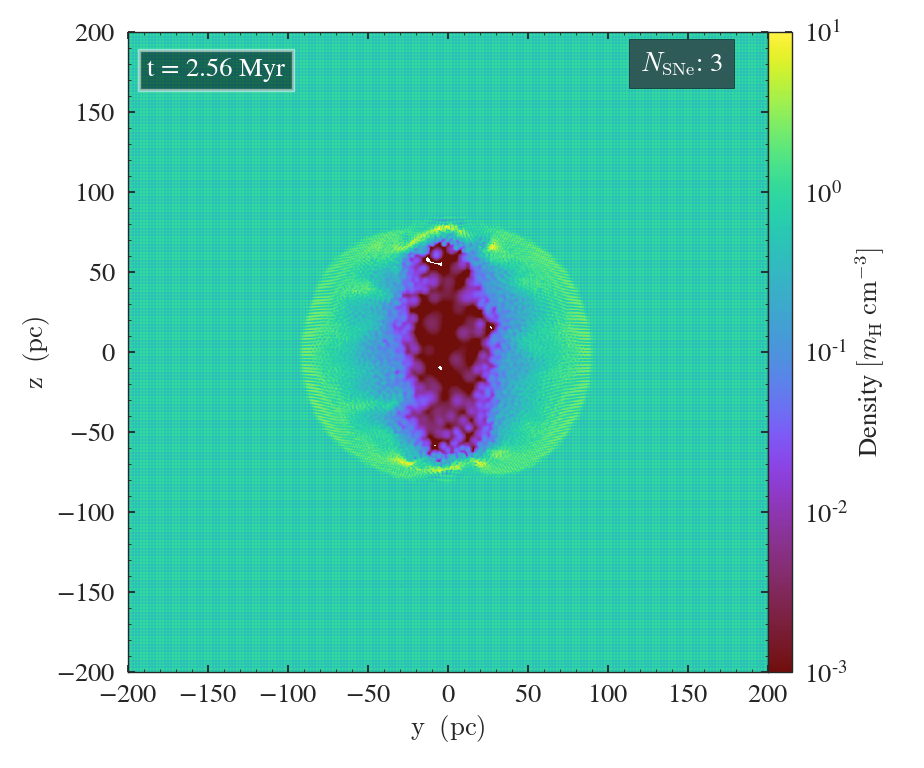

In [22]:
snapshot_number = 15

sp = plot_sliced_field(
    ts = (ts),
    snapshot_number = snapshot_number,
    snapshot_number_to_index_map = (snapshot_number_to_index_map),
    field = "density",
    SN_times  = (SN_times),
    plots_dir = (publication_plots_dir),
    save_plot = (False),
    show_plot = (False),
    seaborn_style = ("ticks"),
    add_magnetic_field_lines = (False), # I'll handle this on my own
    font_size=24,
    SlicePlot_kwargs={"width":((2*200,"pc"))}
);

sp.set_zlim("density", 1e-3, 1e1)
p = sp.plots[("gas", "density")]

im = p.axes.get_images()[0]

old_arr_mhd = im.get_array()
old_arr_mhd[old_arr_mhd < 1e-3] = 1e-3 # clip at bottom of colormap

sp.show() # this has to be done before adding magnetic field lines
    

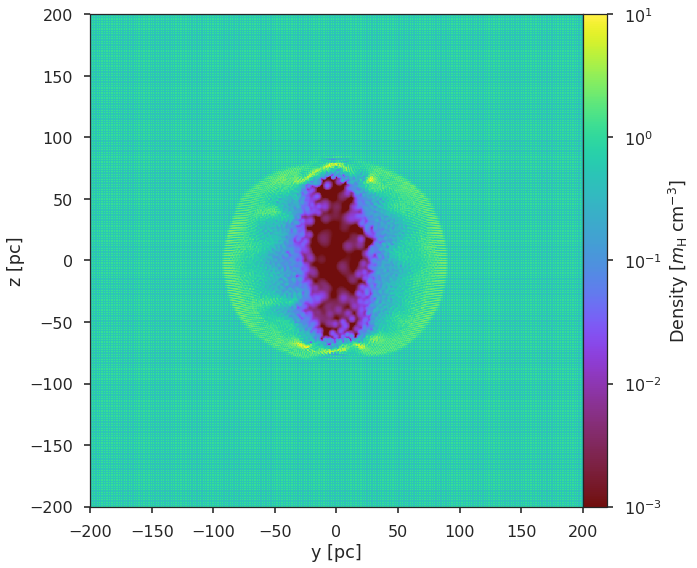

In [23]:
mpl.rcParams['figure.figsize'] = np.array((5,4))*2

with sns.plotting_context(font_scale=.5):
    x = np.linspace(-200, 200, old_arr_mhd.shape[0])
    y = np.linspace(-200, 200, old_arr_mhd.shape[1])

    ax = plt.subplot(111, aspect="equal", adjustable='box')

    pcm = ax.pcolormesh(x, y, old_arr_mhd,
                         cmap=plt.get_cmap("arbre"),
                         norm=LogNorm(1e-3, 1e1),
                        )

    cbr = plt.colorbar(pcm,
                       ticks=[10**i for i in range(-3, 2)],
                       label="Density $ [ m_\mathrm{H} \; \mathrm{cm}^{-3} ] $",
                       pad=0,
        )

    tick_step = 50
    ticks = np.arange(min(x), max(x) + tick_step, tick_step)
    plt.gca().set_xticks(ticks)
    plt.gca().set_yticks(ticks)

    plt.xlim(min(ticks), max(ticks))
    plt.ylim(min(ticks), max(ticks))

    plt.xlabel("y [pc]")
    plt.ylabel("z [pc]")

    plt.tight_layout()

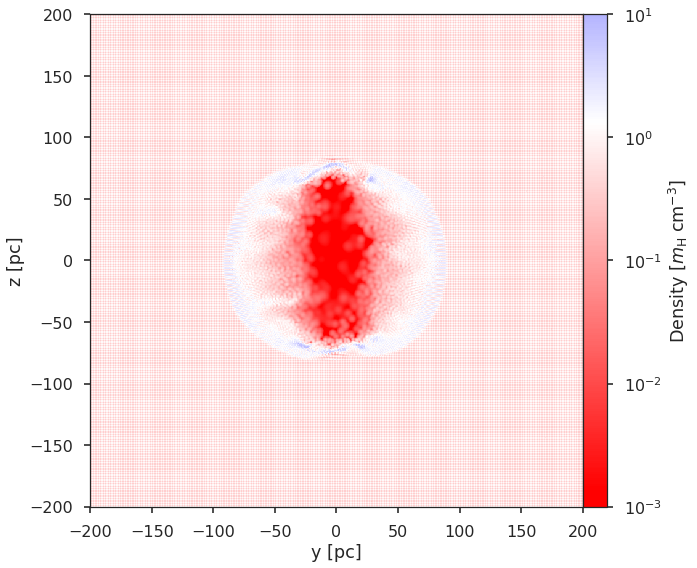

In [24]:
mpl.rcParams['figure.figsize'] = np.array((5,4))*2

with sns.plotting_context(font_scale=.5):
    x = np.linspace(-200, 200, old_arr_mhd.shape[0])
    y = np.linspace(-200, 200, old_arr_mhd.shape[1])

    ax = plt.subplot(111, aspect="equal", adjustable='box')

    pcm = ax.pcolormesh(x, y, old_arr_mhd,
                         cmap=plt.get_cmap("bwr_r"),
                         norm=LogNorm(1.33*1e-3, 1.33*1e3),
                        )

    cbr = plt.colorbar(pcm,
                       boundaries=np.logspace(-3, 1, num=256),
                       ticks=[10**i for i in range(-3, 2)],
                       label="Density $ [ m_\mathrm{H} \; \mathrm{cm}^{-3} ] $",
                       pad=0,
        )

    tick_step = 50
    ticks = np.arange(min(x), max(x) + tick_step, tick_step)
    plt.gca().set_xticks(ticks)
    plt.gca().set_yticks(ticks)

    plt.xlim(min(ticks), max(ticks))
    plt.ylim(min(ticks), max(ticks))

    plt.xlabel("y [pc]")
    plt.ylabel("z [pc]")

    plt.tight_layout()

## Now plot with a variety of number of field lines

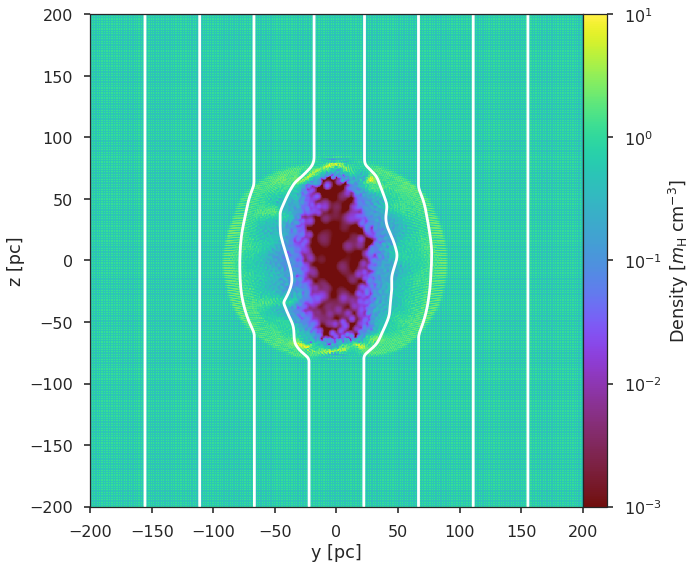

In [25]:
mpl.rcParams['figure.figsize'] = np.array((5,4))*2

# snapshot number *only affects mag field lines*.
# the background density slice is stored in-memory from above.

snapshot_number = 15
num_lines = 8

with sns.plotting_context(font_scale=.5):
    x = np.linspace(-200, 200, old_arr_mhd.shape[0])
    y = np.linspace(-200, 200, old_arr_mhd.shape[1])

    ax = plt.subplot(111, aspect="equal", adjustable='box')

    pcm = ax.pcolormesh(x, y, old_arr_mhd,
                         cmap=plt.get_cmap("arbre"),
                         norm=LogNorm(1e-3, 1e1),
                        )
    pcm.set_rasterized(True)

    cbr = plt.colorbar(pcm,
                       ticks=[10**i for i in range(-3, 2)],
                       label="Density $ [ m_\mathrm{H} \; \mathrm{cm}^{-3} ] $",
                       pad=0,
        )

    tick_step = 50
    ticks = np.arange(min(x), max(x) + tick_step, tick_step)
    plt.gca().set_xticks(ticks)
    plt.gca().set_yticks(ticks)

    plt.xlim(min(ticks), max(ticks))
    plt.ylim(min(ticks), max(ticks))

    plt.xlabel("y [pc]")
    plt.ylabel("z [pc]")
    
    filename = "publication_plots/field_lines/field_lines_snapshot_{:03}.{}.csv".format(snapshot_number, num_lines)
    df_lines = pd.read_csv(filename)
    MHD.plot_field_lines(df_lines, plt.gca(),
                         replace_nans=True)

    plt.tight_layout()
    plot_filename = os.path.join(publication_plots_dir, "density_slice-snapshot_{:03}-200_MHD.{}".format(snapshot_number, num_lines))
    plt.savefig(plot_filename + ".eps", dpi=200)
    plt.savefig(plot_filename + ".pdf")
    plt.savefig(plot_filename + ".png")
    
    plot_filename = os.path.join(publication_plots_dir, "density_slice-snapshot_{:03}-200_MHD.{}.lowres".format(snapshot_number, num_lines))
    plt.savefig(plot_filename + ".eps", dpi=130)
    plt.savefig(plot_filename + ".pdf")
    plt.savefig(plot_filename + ".png")

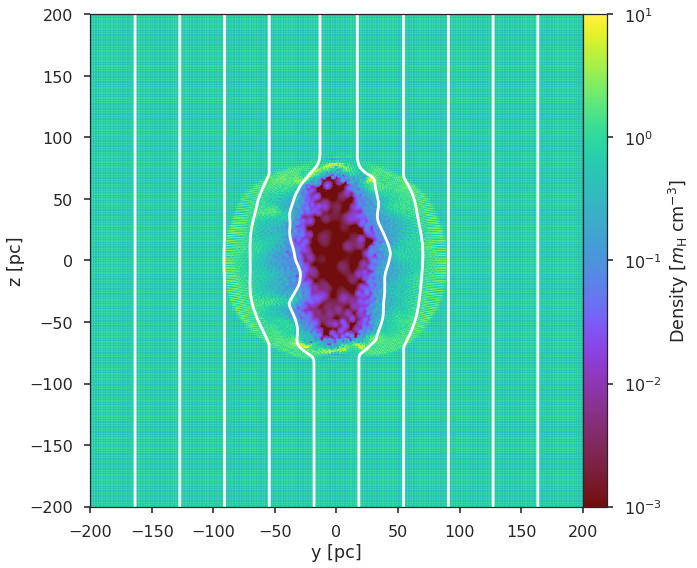

In [26]:
mpl.rcParams['figure.figsize'] = np.array((5,4))*2

# snapshot number *only affects mag field lines*.
# the background density slice is stored in-memory from above.

snapshot_number = 15
num_lines = 10

with sns.plotting_context(font_scale=.5):
    x = np.linspace(-200, 200, old_arr_mhd.shape[0])
    y = np.linspace(-200, 200, old_arr_mhd.shape[1])

    ax = plt.subplot(111, aspect="equal", adjustable='box')

    pcm = ax.pcolormesh(x, y, old_arr_mhd,
                         cmap=plt.get_cmap("arbre"),
                         norm=LogNorm(1e-3, 1e1),
                        )
    pcm.set_rasterized(True)

    cbr = plt.colorbar(pcm,
                       ticks=[10**i for i in range(-3, 2)],
                       label="Density $ [ m_\mathrm{H} \; \mathrm{cm}^{-3} ] $",
                       pad=0,
        )

    tick_step = 50
    ticks = np.arange(min(x), max(x) + tick_step, tick_step)
    plt.gca().set_xticks(ticks)
    plt.gca().set_yticks(ticks)

    plt.xlim(min(ticks), max(ticks))
    plt.ylim(min(ticks), max(ticks))

    plt.xlabel("y [pc]")
    plt.ylabel("z [pc]")
    
    filename = "publication_plots/field_lines/field_lines_snapshot_{:03}.{}.csv".format(snapshot_number, num_lines)
    df_lines = pd.read_csv(filename)
    MHD.plot_field_lines(df_lines, plt.gca(),
                         replace_nans=True)

    plt.tight_layout()
    plot_filename = os.path.join(publication_plots_dir, "density_slice-snapshot_{:03}-200_MHD.{}".format(snapshot_number, num_lines))
    plt.savefig(plot_filename + ".eps", dpi=200)
    plt.savefig(plot_filename + ".pdf")
    plt.savefig(plot_filename + ".png")
    
    plot_filename = os.path.join(publication_plots_dir, "density_slice-snapshot_{:03}-200_MHD.{}.lowres".format(snapshot_number, num_lines))
    plt.savefig(plot_filename + ".eps", dpi=130)
    plt.savefig(plot_filename + ".pdf")
    plt.savefig(plot_filename + ".png")

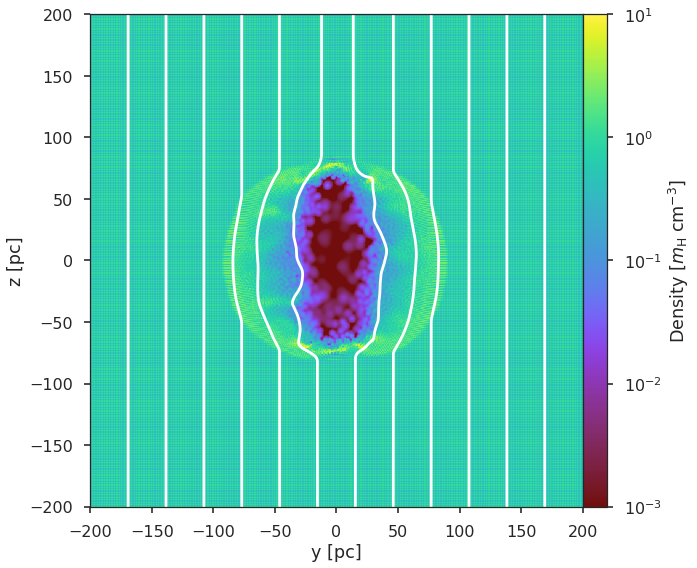

In [27]:
mpl.rcParams['figure.figsize'] = np.array((5,4))*2

# snapshot number *only affects mag field lines*.
# the background density slice is stored in-memory from above.

snapshot_number = 15
num_lines = 12

with sns.plotting_context(font_scale=.5):
    x = np.linspace(-200, 200, old_arr_mhd.shape[0])
    y = np.linspace(-200, 200, old_arr_mhd.shape[1])

    ax = plt.subplot(111, aspect="equal", adjustable='box')

    pcm = ax.pcolormesh(x, y, old_arr_mhd,
                         cmap=plt.get_cmap("arbre"),
                         norm=LogNorm(1e-3, 1e1),
                        )
    pcm.set_rasterized(True)

    cbr = plt.colorbar(pcm,
                       ticks=[10**i for i in range(-3, 2)],
                       label="Density $ [ m_\mathrm{H} \; \mathrm{cm}^{-3} ] $",
                       pad=0,
        )

    tick_step = 50
    ticks = np.arange(min(x), max(x) + tick_step, tick_step)
    plt.gca().set_xticks(ticks)
    plt.gca().set_yticks(ticks)

    plt.xlim(min(ticks), max(ticks))
    plt.ylim(min(ticks), max(ticks))

    plt.xlabel("y [pc]")
    plt.ylabel("z [pc]")
    
    filename = "publication_plots/field_lines/field_lines_snapshot_{:03}.{}.csv".format(snapshot_number, num_lines)
    df_lines = pd.read_csv(filename)
    MHD.plot_field_lines(df_lines, plt.gca(),
                         replace_nans=True)

    plt.tight_layout()
    plot_filename = os.path.join(publication_plots_dir, "density_slice-snapshot_{:03}-200_MHD.{}".format(snapshot_number, num_lines))
    plt.savefig(plot_filename + ".eps", dpi=200)
    plt.savefig(plot_filename + ".pdf")
    plt.savefig(plot_filename + ".png")
    
    plot_filename = os.path.join(publication_plots_dir, "density_slice-snapshot_{:03}-200_MHD.{}.lowres".format(snapshot_number, num_lines))
    plt.savefig(plot_filename + ".eps", dpi=130)
    plt.savefig(plot_filename + ".pdf")
    plt.savefig(plot_filename + ".png")

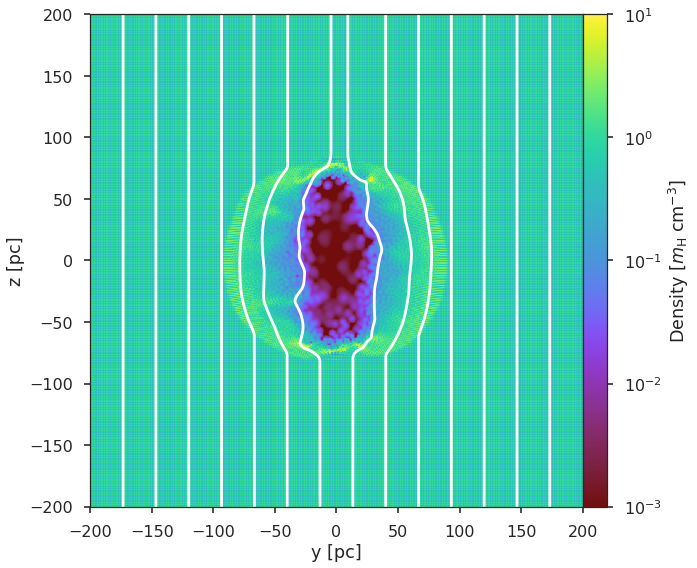

In [28]:
mpl.rcParams['figure.figsize'] = np.array((5,4))*2

# snapshot number *only affects mag field lines*.
# the background density slice is stored in-memory from above.

snapshot_number = 15
num_lines = 14

with sns.plotting_context(font_scale=.5):
    x = np.linspace(-200, 200, old_arr_mhd.shape[0])
    y = np.linspace(-200, 200, old_arr_mhd.shape[1])

    ax = plt.subplot(111, aspect="equal", adjustable='box')

    pcm = ax.pcolormesh(x, y, old_arr_mhd,
                         cmap=plt.get_cmap("arbre"),
                         norm=LogNorm(1e-3, 1e1),
                        )
    pcm.set_rasterized(True)

    cbr = plt.colorbar(pcm,
                       ticks=[10**i for i in range(-3, 2)],
                       label="Density $ [ m_\mathrm{H} \; \mathrm{cm}^{-3} ] $",
                       pad=0,
        )

    tick_step = 50
    ticks = np.arange(min(x), max(x) + tick_step, tick_step)
    plt.gca().set_xticks(ticks)
    plt.gca().set_yticks(ticks)

    plt.xlim(min(ticks), max(ticks))
    plt.ylim(min(ticks), max(ticks))

    plt.xlabel("y [pc]")
    plt.ylabel("z [pc]")
    
    filename = "publication_plots/field_lines/field_lines_snapshot_{:03}.{}.csv".format(snapshot_number, num_lines)

    df_lines = pd.read_csv(filename)
    MHD.plot_field_lines(df_lines, plt.gca(),
                         replace_nans=True)

    plt.tight_layout()
    plot_filename = os.path.join(publication_plots_dir, "density_slice-snapshot_{:03}-200_MHD.{}".format(snapshot_number, num_lines))
    plt.savefig(plot_filename + ".eps", dpi=200)
    plt.savefig(plot_filename + ".pdf")
    plt.savefig(plot_filename + ".png")
    
    plot_filename = os.path.join(publication_plots_dir, "density_slice-snapshot_{:03}-200_MHD.{}.lowres".format(snapshot_number, num_lines))
    plt.savefig(plot_filename + ".eps", dpi=130)
    plt.savefig(plot_filename + ".pdf")
    plt.savefig(plot_filename + ".png")

### Just curious, but what does a non-MHD run look like at this time?

In [6]:
run_name = "cluster_cooling_200-small_steps-early"
inputs_dir, outputs_dir = get_dirs(run_name)

In [7]:
ts = load_snapshots(outputs_dir)
snapshot_filenames = get_snapshot_filenames(outputs_dir)

snapshot_number_to_index_map = {snapshot_filename_to_number(filename) : i
                                for i,filename in enumerate(snapshot_filenames) }

uncompressed_snapshot_numbers = sorted(list(snapshot_number_to_index_map.keys()))


yt : [INFO     ] 2018-01-10 15:03:33,812 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2018-01-10 15:03:33,864 Parameters: current_time              = 2.55999999997
yt : [INFO     ] 2018-01-10 15:03:33,865 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2018-01-10 15:03:33,867 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2018-01-10 15:03:33,870 Parameters: domain_right_edge         = [ 600.  600.  600.]
yt : [INFO     ] 2018-01-10 15:03:33,872 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2018-01-10 15:03:35,378 Allocating for 2.700e+07 particles
Initializing refined index: 100%|██████████| 103/103 [00:05<00:00, 20.34it/s]
yt : [INFO     ] 2018-01-10 15:03:58,483 xlim = 100.000000 500.000000
yt : [INFO     ] 2018-01-10 15:03:58,491 ylim = 100.000000 500.000000
yt : [INFO     ] 2018-01-10 15:03:58,494 xlim = 100.000000 500.000000
yt : [INFO     ] 2018-01-10 15:03:58,494 ylim = 100.000000 500.000000
yt : [IN


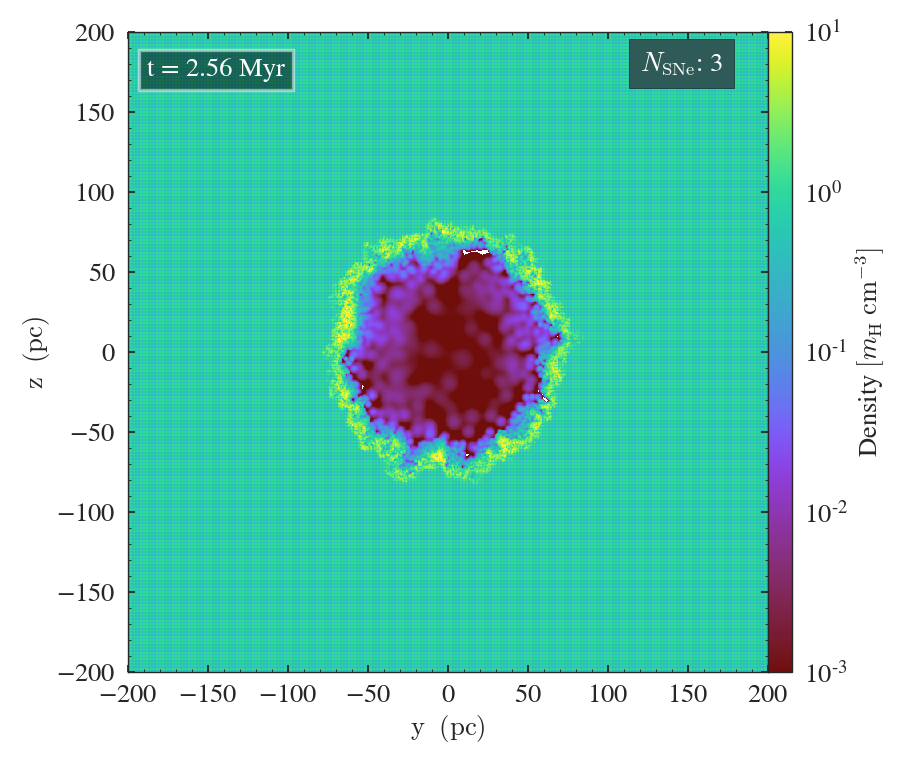

In [9]:
snapshot_number = 15

sp = plot_sliced_field(
    ts = (ts),
    snapshot_number = snapshot_number,
    snapshot_number_to_index_map = (snapshot_number_to_index_map),
    field = "density",
    SN_times  = (SN_times),
    plots_dir = (publication_plots_dir),
    save_plot = (False),
    show_plot = (False),
    seaborn_style = ("ticks"),
    add_magnetic_field_lines = (False), # I'll handle this on my own
    font_size=24,
    SlicePlot_kwargs={"width":((2*200,"pc"))}
);

sp.set_zlim("density", 1e-3, 1e1)

p = sp.plots[("gas", "density")]
im = p.axes.get_images()[0]

old_arr_hd_early = im.get_array()
old_arr_hd_early[old_arr_hd_early < 1e-3] = 1e-3 # clip at bottom of colormap

sp.show()
    

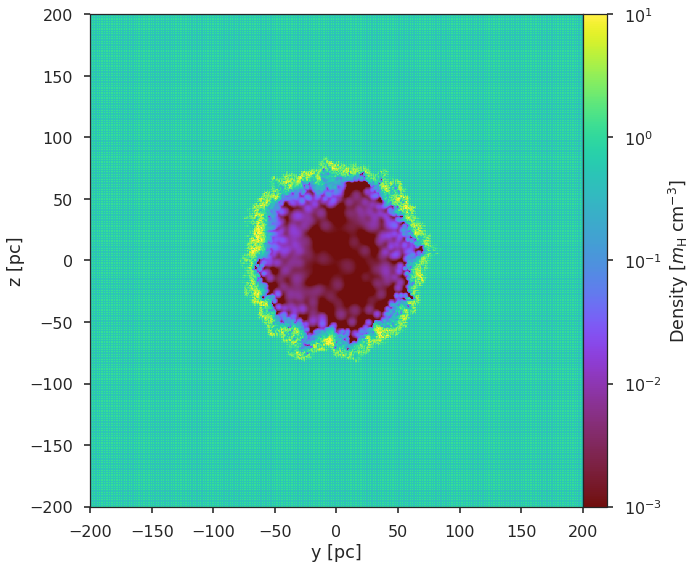

In [11]:
mpl.rcParams['figure.figsize'] = np.array((5,4))*2

# snapshot number *only affects mag field lines*.
# the background density slice is stored in-memory from above.

snapshot_number = 15

with sns.plotting_context(font_scale=.5):
    x = np.linspace(-200, 200, old_arr_hd_early.shape[0])
    y = np.linspace(-200, 200, old_arr_hd_early.shape[1])

    ax = plt.subplot(111, aspect="equal", adjustable='box')

    pcm = ax.pcolormesh(x, y, old_arr_hd_early,
                         cmap=plt.get_cmap("arbre"),
                         norm=LogNorm(1e-3, 1e1),
                        )
    pcm.set_rasterized(True)

    cbr = plt.colorbar(pcm,
                       ticks=[10**i for i in range(-3, 2)],
                       label="Density $ [ m_\mathrm{H} \; \mathrm{cm}^{-3} ] $",
                       pad=0,
        )

    tick_step = 50
    ticks = np.arange(min(x), max(x) + tick_step, tick_step)
    plt.gca().set_xticks(ticks)
    plt.gca().set_yticks(ticks)

    plt.xlim(min(ticks), max(ticks))
    plt.ylim(min(ticks), max(ticks))

    plt.xlabel("y [pc]")
    plt.ylabel("z [pc]")


    plt.tight_layout()


# Figure A1 (Appendix) - Effects of perturbations

In [15]:
SNe_dir = "../runs/cluster_cooling_100/inputs"
SNe = get_SNe(SNe_dir)
SN_times_3D = np.array([SN.time for SN in SNe])

In [17]:
df_100 = copy_and_get_DataFrames("cluster_cooling_100")
df_200 = copy_and_get_DataFrames("cluster_cooling_200")
df_400 = copy_and_get_DataFrames("cluster_cooling_400")


df_100_perturbed = copy_and_get_DataFrames("cluster_cooling_100-perturbed")
df_200_perturbed = copy_and_get_DataFrames("cluster_cooling_200-perturbed")
df_400_perturbed = copy_and_get_DataFrames("cluster_cooling_400-perturbed")

In [18]:
dx_to_color = Dx_To_Color()

color_100 = dx_to_color(4)
color_200 = dx_to_color(2) 
color_400 = dx_to_color(1) 

linestyle_original = "solid"
linestyle_perturbed = "dashed"

label_100_original = "$\Delta x$ = 4.0 pc"
label_200_original = "$\Delta x$ = 2.0 pc"
label_400_original = "$\Delta x$ = 1.0 pc"

label_100_perturbed = "$\Delta x$ = 4.0 pc (perturbed)"
label_200_perturbed = "$\Delta x$ = 2.0 pc (perturbed)"
label_400_perturbed = "$\Delta x$ = 1.0 pc (perturbed)"

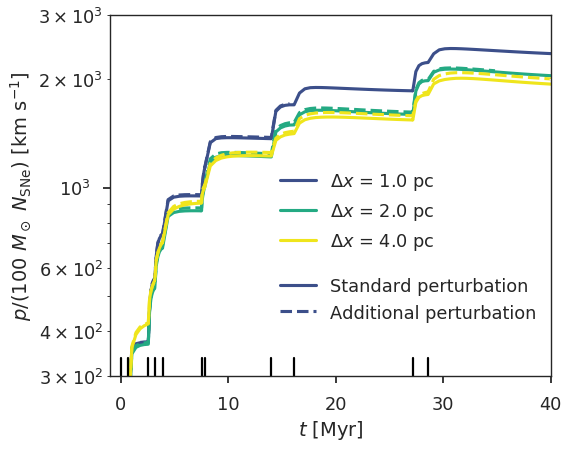

In [19]:
plt.plot(df_400.time, 
         df_400.momentum / (100 * M_solar * 1e5 * SN_times_3D.size),
         color = color_400,
         linestyle = linestyle_original,
         label = label_400_original
        )

plt.plot(df_400_perturbed.time, 
         df_400_perturbed.momentum / (100 * M_solar * 1e5 * SN_times_3D.size),
         color = color_400,
         linestyle = linestyle_perturbed,
         label="",
#          label = label_400_perturbed
        )


plt.plot(df_200.time, 
         df_200.momentum / (100 * M_solar * 1e5 * SN_times_3D.size),
         color = color_200,
         linestyle = linestyle_original,
         label = label_200_original
        )

plt.plot(df_200_perturbed.time, 
         df_200_perturbed.momentum / (100 * M_solar * 1e5 * SN_times_3D.size),
         color = color_200,
         linestyle = linestyle_perturbed,
         label="",
#          label = label_200_perturbed
        )

plt.plot(df_100.time, 
         df_100.momentum / (100 * M_solar * 1e5 * SN_times_3D.size),
         color=color_100,
         linestyle=linestyle_original,
         label = label_100_original
        )

plt.plot(df_100_perturbed.time, 
         df_100_perturbed.momentum / (100 * M_solar * 1e5 * SN_times_3D.size),
         color=color_100,
         linestyle=linestyle_perturbed,
         label="",
#          label = label_100_perturbed
        )


sns.rugplot(SN_times_3D,
            color="black",
            linestyle="solid",
            linewidth=2,
           )

plt.xlabel(r"$t$ $[\mathrm{Myr}]$")
plt.ylabel(r"$p / (100$ $M_\odot$ $N_\mathrm{SNe})$ $[\mathrm{km}$ $\mathrm{s}^{-1}]$")


plt.xlim(xmin=-1,
         xmax=40)
plt.ylim(ymin=300,
         ymax=3000,
        )

plt.yscale("log")

resolution_legend = plt.legend(loc="lower left", bbox_to_anchor=[.35, .3])
ax = plt.gca()
ax.add_artist(resolution_legend)
l = ax.get_lines()


perturb_legend = plt.legend(
    l[0:2],
    ["Standard perturbation", "Additional perturbation"],
    loc="upper left", bbox_to_anchor = [.35, .32]
)

plt.tight_layout()
plot_filename = os.path.join(publication_plots_dir, "momentum_evolution-3D-perturbation")
plt.savefig(plot_filename + ".eps")
plt.savefig(plot_filename + ".pdf")
plt.savefig(plot_filename + ".png")


# Appendix C: Cooling Rate Comparisons

## C1: 1D Lagrangian
Taken from `shock cooling.ipynb`

In [21]:
_data_dir_1D = "1D_data/"

run_summary = RunSummary(_data_dir_1D, "F5509BF1-3F9E-4008-B795-0482ECED199B")

run_summary.df.head()

Radius        dR            dV       Density      Pressure  Velocity  \
k i                                                                           
0 0  1.316726  0.626294  2.404438e+56  5.726431e-23  2.772651e-06       0.0   
  1  1.943019  0.626294  6.218104e+56  2.224587e-24  5.187139e-14       0.0   
  2  2.569313  0.626294  1.184572e+57  2.224587e-24  5.187139e-14       0.0   
  3  3.195607  0.626294  1.928729e+57  2.224587e-24  5.187139e-14       0.0   
  4  3.821900  0.626294  2.854280e+57  2.224587e-24  5.187139e-14       0.0   

            Z      Mass      M_int   Temperature        Energy    Entropy  \
k i                                                                         
0 0  0.952283  6.924323   6.924323  3.486347e+08  7.262773e+16  73.863802   
  1  0.020000  0.695644   7.619967  1.678950e+02  3.497596e+10  55.292614   
  2  0.020000  1.325228   8.945196  1.678950e+02  3.497596e+10  55.292614   
  3  0.020000  2.157746  11.102942  1.678950e+02  3.497596e+10  55.292614   
  4  0.020000  3.193198  14.296140  1.678950e+02  3.497596e+10  55.292614   

             C_ad  Crossing_time  zones  
k i                                      
0 0  2.840730e+08   6.802969e+09      0  
  1  1.971349e+05   9.803133e+12      1  
  2  1.971349e+05   9.803133e+12      2  
  3  1.971349e+05   9.803133e+12      3  
  4  1.971349e+05   9.803133e+12      4

In [22]:
def shock_cooling_model(run_summary):
    """Calculate 1st order model for luminosity due to shocking new material
    
    Inputs
    ------
    run_summary - instance of RunSummary
         
    Returns
    -------
    E_dot_cool_shock - np.ndarray
        dtype: float
        shape: len(run_summary.times)
    """
    
    # skip 1st checkpoint to give us the same length as V_shock below
    R_shock = run_summary.R_shock[1:]
    
    V_shock = np.diff(run_summary.R_shock) / np.diff(run_summary.times)

    rho_ISM = run_summary.overview.background_density
    e_int_ISM = run_summary.df.iloc[-1].Energy
    
    
    
#     E_dot_cool_shock = 4 * np.pi * R_shock**2 * V_shock * rho_ISM \
#                          * (.5*V_shock**2  + e_int_ISM)
        
    E_dot_cool_shock = 4 * np.pi * R_shock**2 * V_shock * rho_ISM \
                         * (.5*V_shock**2)
        
    # pad E_dot_cool_shock so that it's length matches `run_summary.times` again
    # (E_dot_cool = 0 at the start anyway, since V_shock = 0 at that time)
    E_dot_cool_shock = np.concatenate([
        np.array([0]),
        E_dot_cool_shock
    ])
    
    return E_dot_cool_shock
    
E_dot_cool_shock = shock_cooling_model(run_summary)

In [23]:
from visualize_helpers import grackle_temperature_1D, grackle_cooling_rate_1D

E_dot_cool_grackle = np.zeros_like(run_summary.times)

for k in range(len(E_dot_cool_grackle)):
    df_tmp  = run_summary.df.loc[k]
    E_dot_cool_grackle[k] = grackle_cooling_rate_1D(df_tmp).sum()


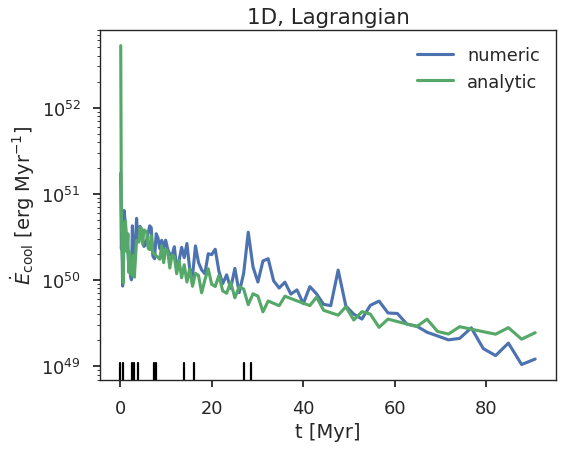

In [37]:
mpl.rcParams['figure.figsize'] = np.array((5,4))*1.5


plt.plot((run_summary.times[1:] - run_summary.times[0]) / Myr,
         E_dot_cool_grackle[1:] * Myr,
         label="numeric"
         )

plt.plot((run_summary.times[1:] - run_summary.times[0]) / Myr,
         E_dot_cool_shock[1:] * Myr,
         label="analytic"
         )

plt.yscale("log")

plt.xlabel("t [Myr]")
plt.ylabel("$\dot{E}_\mathrm{cool}$ [erg Myr$^{-1}$]")

sns.rugplot((run_summary.overview.SNe_times - run_summary.overview.SNe_times[0]) / Myr, 
            color="k",
            linewidth=2)

plt.legend(loc="best")

plt.title("1D, Lagrangian")

plt.tight_layout()
plot_filename = os.path.join(publication_plots_dir, "shock_cooling-1D-Lagrangian")
plt.savefig(plot_filename + ".eps")
plt.savefig(plot_filename + ".pdf")
plt.savefig(plot_filename + ".png")

## 1D Eulerian

In [26]:
data_dir_1D_euler = "/pfs/home/egentry/data/clustered_SNe/10_hires_euler"

run_summary_euler = RunSummary(data_dir_1D_euler, "")

run_summary_euler.df.head()

Radius        dR            dV       Density      Pressure  Velocity  \
k i                                                                           
0 0  1.316726  0.626294  2.404438e+56  5.726431e-23  2.772654e-06       0.0   
  1  1.943019  0.626294  6.218104e+56  2.224587e-24  3.089513e-12       0.0   
  2  2.569313  0.626294  1.184572e+57  2.224587e-24  3.089513e-12       0.0   
  3  3.195607  0.626294  1.928729e+57  2.224587e-24  3.089513e-12       0.0   
  4  3.821900  0.626294  2.854280e+57  2.224587e-24  3.089513e-12       0.0   

            Z      Mass      M_int   Temperature        Energy    Entropy  \
k i                                                                         
0 0  0.952283  6.924323   6.924323  3.486351e+08  7.262781e+16  73.863804   
  1  0.020000  0.695644   7.619967  1.000000e+04  2.083204e+12  61.423116   
  2  0.020000  1.325228   8.945196  1.000000e+04  2.083204e+12  61.423116   
  3  0.020000  2.157746  11.102942  1.000000e+04  2.083204e+12  61.423116   
  4  0.020000  3.193198  14.296140  1.000000e+04  2.083204e+12  61.423116   

             C_ad  Crossing_time  zones  
k i                                      
0 0  2.840732e+08   6.802965e+09      0  
  1  1.521404e+06   1.270234e+12      1  
  2  1.521404e+06   1.270234e+12      2  
  3  1.521404e+06   1.270234e+12      3  
  4  1.521404e+06   1.270234e+12      4

In [27]:
E_dot_cool_shock_euler = shock_cooling_model(run_summary_euler)

In [28]:
E_dot_cool_grackle_euler = np.zeros_like(run_summary_euler.times)

for k in range(len(E_dot_cool_grackle_euler)):
    df_tmp  = run_summary_euler.df.loc[k]
    E_dot_cool_grackle_euler[k] = grackle_cooling_rate_1D(df_tmp).sum()


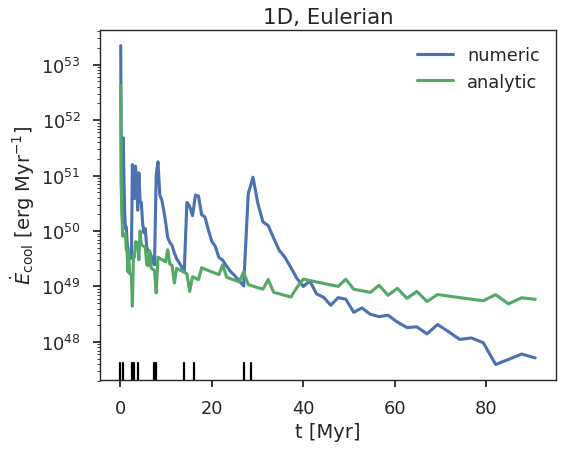

In [36]:
mpl.rcParams['figure.figsize'] = np.array((5,4))*1.5


plt.plot((run_summary_euler.times[1:] - run_summary_euler.times[0]) / Myr,
         E_dot_cool_grackle_euler[1:] * Myr,
         label="numeric"
         )

plt.plot((run_summary_euler.times[1:] - run_summary_euler.times[0]) / Myr,
         E_dot_cool_shock_euler[1:] * Myr,
         label="analytic"
         )

plt.yscale("log")

plt.xlabel("t [Myr]")
plt.ylabel("$\dot{E}_\mathrm{cool}$ [erg Myr$^{-1}$]")

sns.rugplot((run_summary_euler.overview.SNe_times - run_summary_euler.overview.SNe_times[0]) / Myr, 
            color="k",
            linewidth=2)

plt.legend(loc="best")

plt.title("1D, Eulerian")

plt.tight_layout()
plot_filename = os.path.join(publication_plots_dir, "shock_cooling-1D-Eulerian")
plt.savefig(plot_filename + ".eps")
plt.savefig(plot_filename + ".pdf")
plt.savefig(plot_filename + ".png")

## 3D Lagrangian

In [30]:
df = open_as_DataFrame("cluster_cooling_200")
df.tail()

number       time         e_kin         e_int  e_mag          mass  \
110     110  38.442815  5.127027e+49  4.839033e+50    0.0  7.097510e+06   
111     111  38.961543  5.094361e+49  4.847882e+50    0.0  7.097510e+06   
112     112  39.480272  5.061391e+49  4.856718e+50    0.0  7.097510e+06   
113     113  39.999000  5.027351e+49  4.865517e+50    0.0  7.097510e+06   
114     114  39.999000  5.027185e+49  4.865599e+50    0.0  7.097510e+06   

         momentum             run_name  
110  4.489051e+44  cluster_cooling_200  
111  4.479237e+44  cluster_cooling_200  
112  4.469928e+44  cluster_cooling_200  
113  4.461177e+44  cluster_cooling_200  
114  4.461122e+44  cluster_cooling_200

In [31]:
df_shock_analytic = pd.read_csv("shock_model_inputs_2pc.csv")
df_shock_analytic = df_shock_analytic.join(df.time)

df_shock_analytic.head()

i_snapshot    R_shock    V_shock         E_dot      time
0           0   0.000000   0.000000  0.000000e+00  0.000000
1           1   0.000000   0.000000  0.000000e+00  0.001000
2           2  29.480673  43.072048  2.916726e+50  0.127017
3           3  36.069255  24.759868  8.293802e+49  0.253034
4           4  40.360067  18.161206  4.098002e+49  0.379051

In [32]:
df_shock_numeric = pd.read_csv("shock_model_2pc - Edot - numeric.csv")
df_shock_numeric = df_shock_numeric.join(df.time)

df_shock_numeric.head()

i_snapshot         E_dot      time
0           0  0.000000e+00  0.000000
1           1  0.000000e+00  0.001000
2           2  1.172874e+51  0.127017
3           3  4.021156e+50  0.253034
4           4  2.280714e+50  0.379051

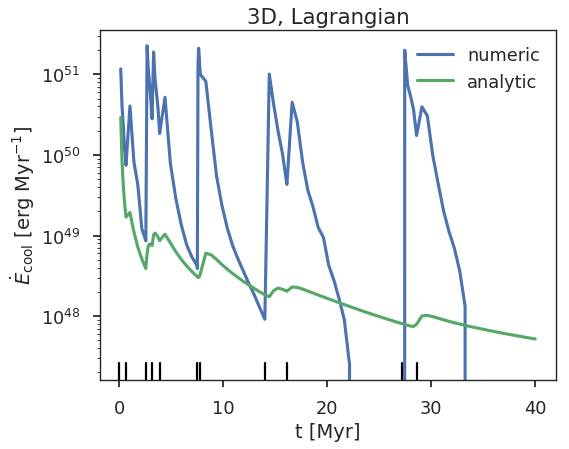

In [38]:
mpl.rcParams['figure.figsize'] = np.array((5,4))*1.5


plt.plot(df_shock_numeric.time[2:], df_shock_numeric.E_dot[2:],
         label="numeric")

plt.plot(df_shock_analytic.time[2:], df_shock_analytic.E_dot[2:],
         label="analytic")

sns.rugplot((run_summary_euler.overview.SNe_times - run_summary_euler.overview.SNe_times[0]) / Myr, 
            color="k",
            linewidth=2)

plt.yscale("log")

plt.xlabel("t [Myr]")
plt.ylabel("$\dot{E}_\mathrm{cool}$ [erg Myr$^{-1}$]")

plt.legend()

plt.title("3D, Lagrangian")


plt.tight_layout()
plot_filename = os.path.join(publication_plots_dir, "shock_cooling-3D-Lagrangian")
plt.savefig(plot_filename + ".eps")
plt.savefig(plot_filename + ".pdf")
plt.savefig(plot_filename + ".png")

# RBF-interpolated slices
Extract a sphere of nearby particles, create a grid of the coordinates of the slice, at each grid location find the 32 nearest neighbors, interpolate fluid values using cubic spline weights.

In [12]:
run_name = "cluster_cooling_600"
inputs_dir, outputs_dir = get_dirs(run_name)


ts = load_snapshots(outputs_dir)
snapshot_filenames = get_snapshot_filenames(outputs_dir)

snapshot_number_to_index_map = {snapshot_filename_to_number(filename) : i
                                for i,filename in enumerate(snapshot_filenames) }

snapshot_number = 8
ds = load_ds_from_ts(ts, snapshot_number_to_index_map[snapshot_number])
center = ds.domain_center.value[0]

radius = 80
radius *= 1.1 * np.sqrt(3) # to get the corners + provide enough margin
region = ds.sphere([center,center,center], (radius, "pc"))

coords = region["all", "Coordinates"].value - center
x, y, z = coords.T
scales = region["all", "smoothing_length"].value
temps = region["all", "temperature"].value
densities = region["all", "density"].value / m_proton

from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=32, n_jobs=4)
knn = knn.fit(coords)

yt : [INFO     ] 2018-10-02 12:03:50,684 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2018-10-02 12:03:50,724 Parameters: current_time              = 1.0148989313228363
yt : [INFO     ] 2018-10-02 12:03:50,725 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2018-10-02 12:03:50,727 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2018-10-02 12:03:50,729 Parameters: domain_right_edge         = [300. 300. 300.]
yt : [INFO     ] 2018-10-02 12:03:50,731 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2018-10-02 12:03:54,196 Allocating for 9.113e+07 particles
Initializing refined index: 100%|██████████| 348/348 [00:37<00:00,  7.04it/s]


In [14]:
y_out = np.linspace(-80, 80, num=800)
z_out = np.linspace(-80, 80, num=800)

YY, ZZ = np.meshgrid(y_out, z_out, indexing="xy")
XX = np.full_like(YY, 0)

coords_test = np.array([XX.flatten(), YY.flatten(), ZZ.flatten()]).T

distances, indices = knn.kneighbors(X=coords_test)

temps_interp = np.array([rbf(distances[i], indices[i], 
                             temps, scales,
                             knn)
                         for i in range(distances.shape[0])
])
temps_interp = temps_interp.reshape(y_out.size, z_out.size)


densities_interp = np.array([rbf(distances[i], indices[i], 
                                 densities, scales,
                                 knn)
                             for i in range(distances.shape[0])
])
densities_interp = densities_interp.reshape(y_out.size, z_out.size)


## Temperature Slice

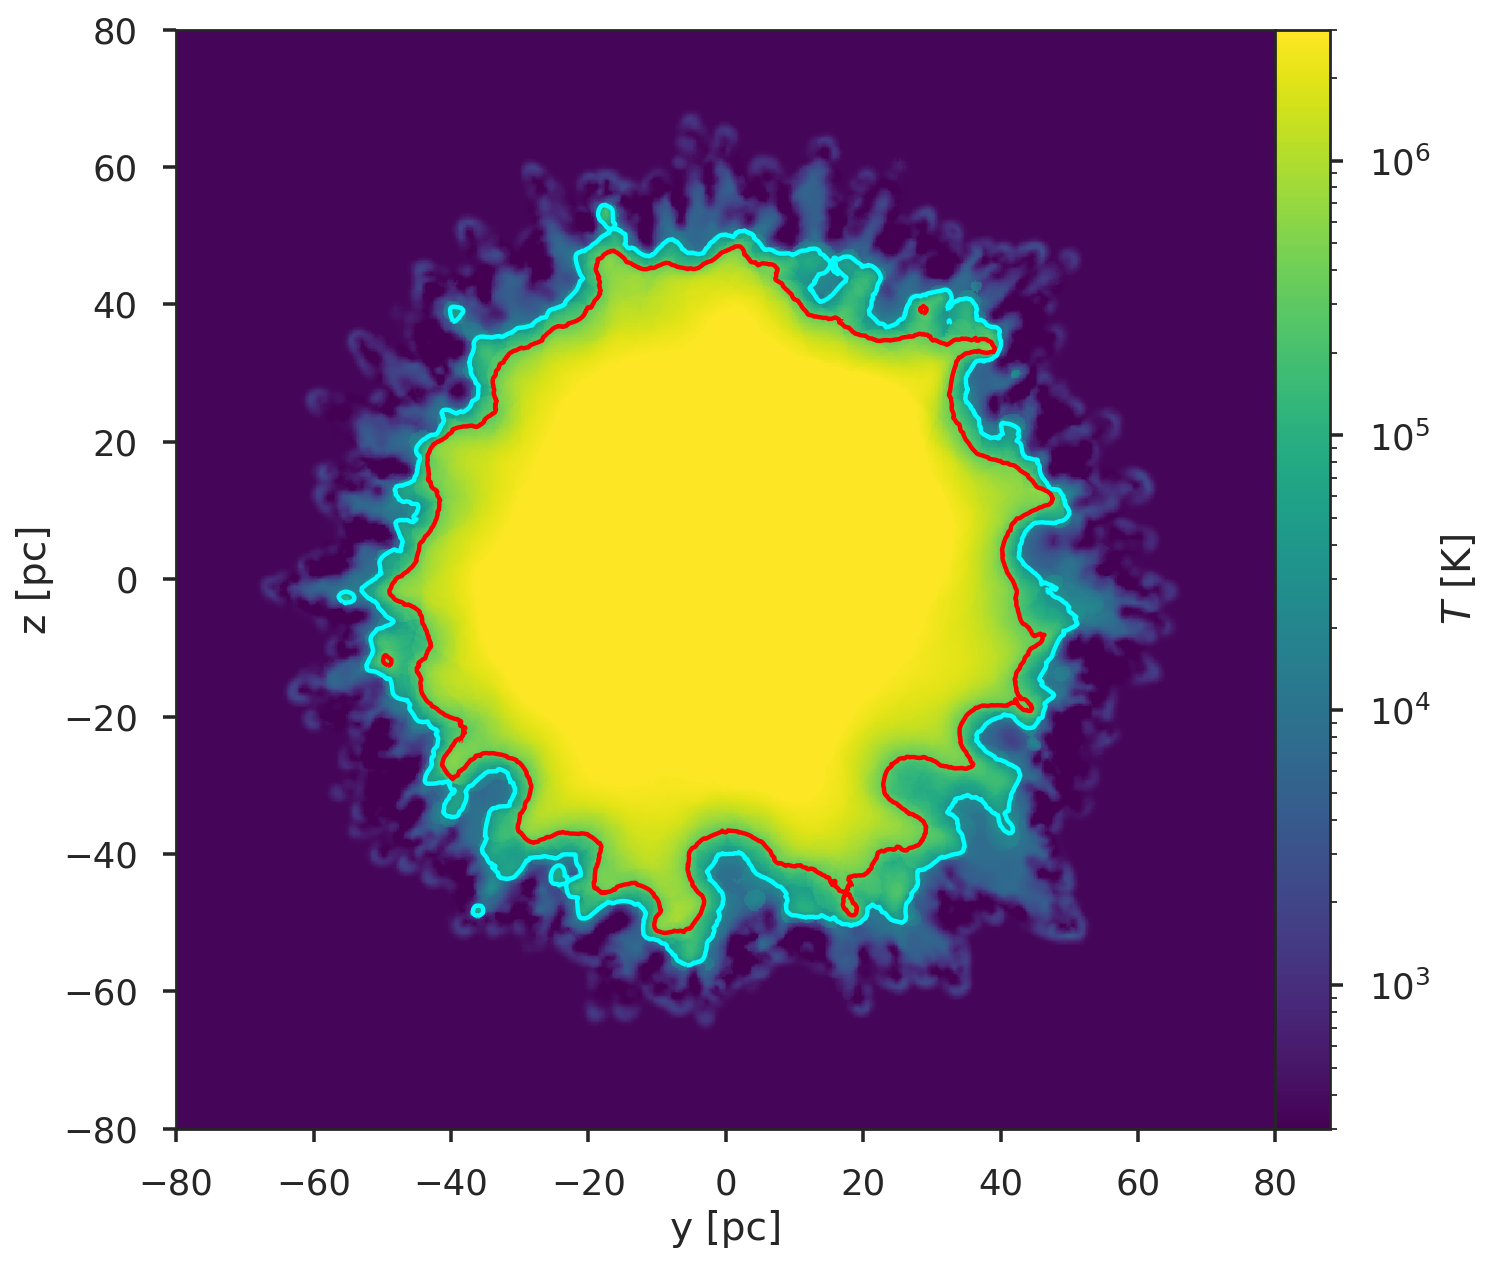

In [17]:
# plot: the color image
with mpl.rc_context(rc={"figure.dpi":160, "savefig.dpi":160,
                        'figure.figsize': np.array((5,4))*2}):

    ax = plt.subplot(111, aspect="equal", adjustable='box')

    min_value = 3e2
    max_value = 3e6
    pcm = ax.pcolor(YY, ZZ, temps_interp, 
                    cmap=plt.cm.viridis, 
                    norm=LogNorm(vmin=min_value, vmax=max_value),
                    edgecolors="none")

    pcm.set_rasterized(True)

    cbr = plt.colorbar(pcm, 
                       label=r"$T$ [K]",
                       pad=0,
                )

    plt.contour(YY, ZZ,
                temps_interp,
                levels=[3e4, 3e5], 
                colors=["cyan", "red"],
                linewidths=2,
           )

    tick_step = 20
    ticks = np.arange(min(y_out), max(y_out) + tick_step, tick_step)
    plt.gca().set_xticks(ticks)
    plt.gca().set_yticks(ticks)

    plt.xlim(min(ticks), max(ticks))
    plt.ylim(min(ticks), max(ticks))

    plt.xlabel("y [pc]")
    plt.ylabel("z [pc]")

    plt.tight_layout()
    plot_filename = os.path.join("publication_plots",
                                 "slice-temperature-snapshot_008-600_HD")
#     plt.savefig(plot_filename + ".eps")
    plt.savefig(plot_filename + ".pdf")
    plt.savefig(plot_filename + ".png")


## Density slice

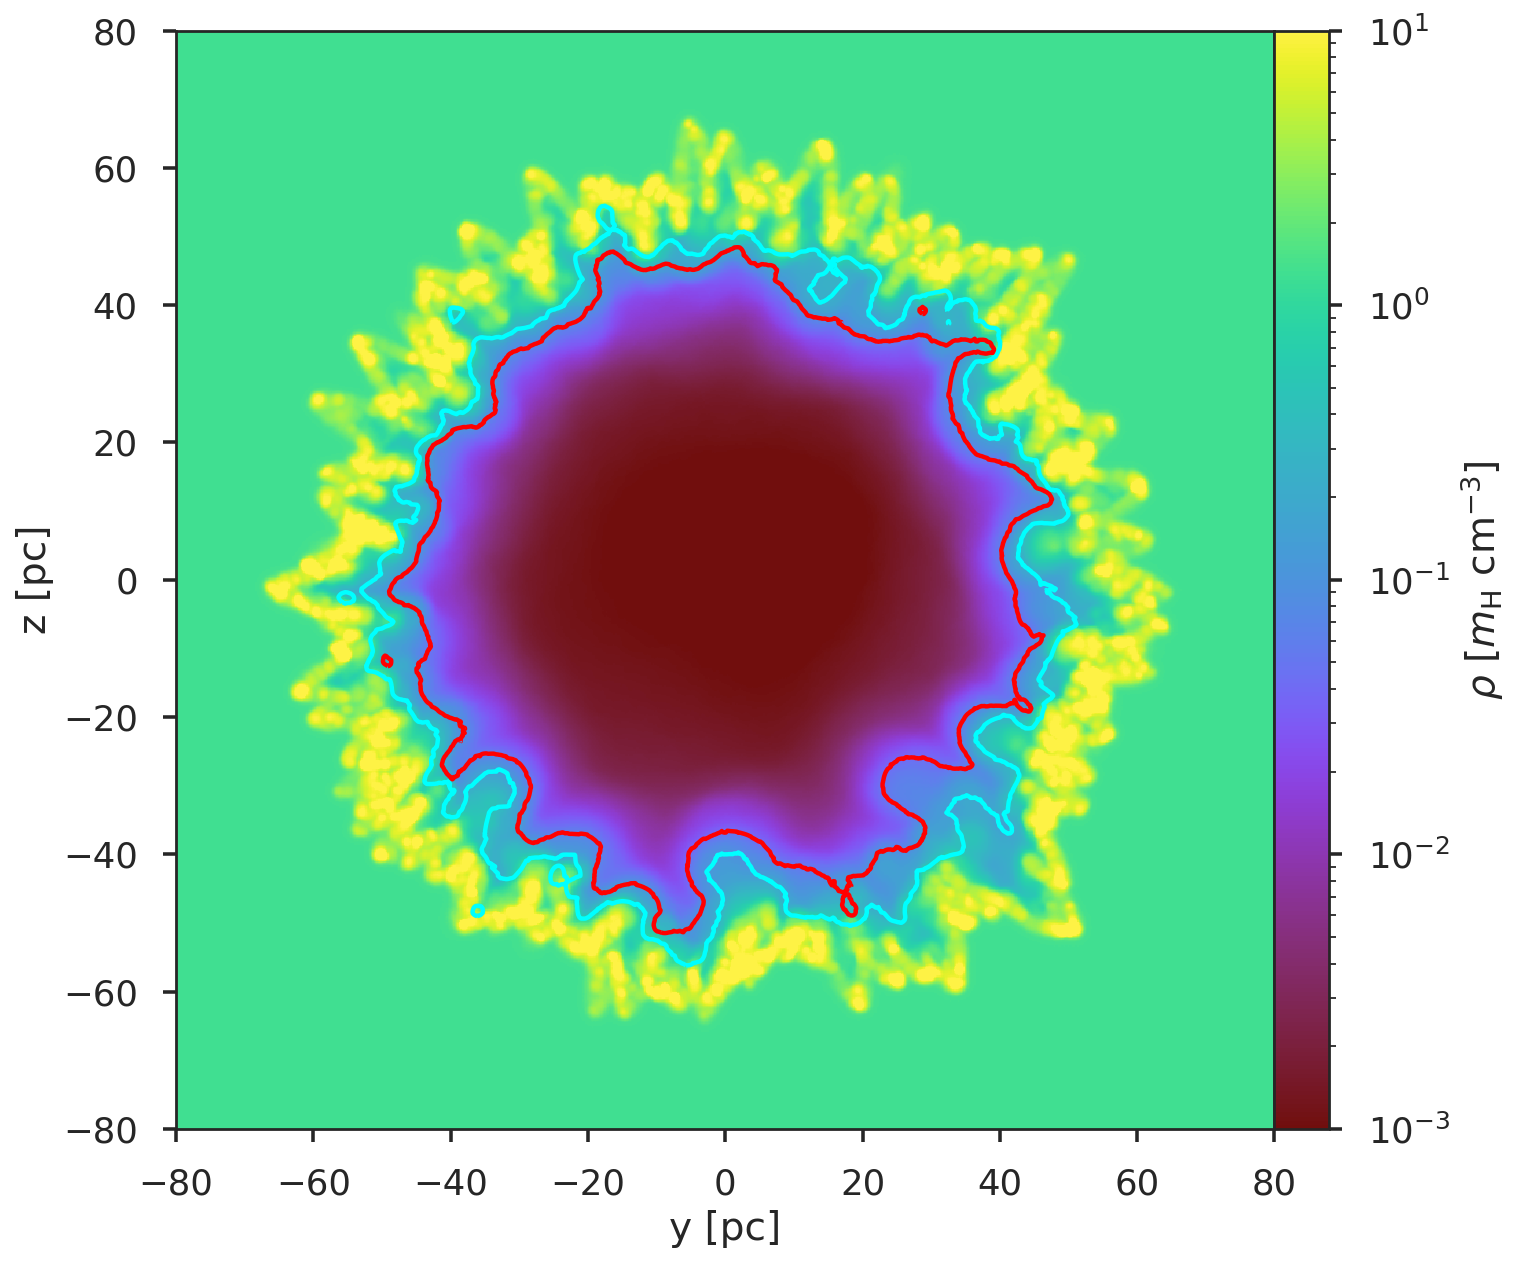

In [18]:
# plot: the color image
with mpl.rc_context(rc={"figure.dpi":160, "savefig.dpi":160,
                        'figure.figsize': np.array((5,4))*2}):

    ax = plt.subplot(111, aspect="equal", adjustable='box')

    min_value = 1e1
    max_value = 1e-3
    pcm = ax.pcolor(YY, ZZ, densities_interp, 
#                     cmap=plt.cm.viridis, 
                         cmap=plt.get_cmap("arbre"),
                    norm=LogNorm(vmin=min_value, vmax=max_value),
                    edgecolors="none")

    pcm.set_rasterized(True)

    cbr = plt.colorbar(pcm, 
                       label=r"$\rho$ [$m_\mathrm{H}$ cm$^{-3}$]",
                       pad=0,
                )

    plt.contour(YY, ZZ,
                temps_interp,
                levels=[3e4, 3e5], 
                colors=["cyan", "red"],
                linewidths=2,
           )

    tick_step = 20
    ticks = np.arange(min(y_out), max(y_out) + tick_step, tick_step)
    plt.gca().set_xticks(ticks)
    plt.gca().set_yticks(ticks)

    plt.xlim(min(ticks), max(ticks))
    plt.ylim(min(ticks), max(ticks))

    plt.xlabel("y [pc]")
    plt.ylabel("z [pc]")

    plt.tight_layout()
    plot_filename = os.path.join("publication_plots",
                                 "slice-density-rbf-snapshot_008-600_HD")
#     plt.savefig(plot_filename + ".eps")
    plt.savefig(plot_filename + ".pdf")
    plt.savefig(plot_filename + ".png")


In [ ]:
# Momentum as a function of resolution